# Introduction
This notebook analyses the relationship of measures against COVID-19 (Coronavirus disease 2019) and the number of infected cases. The goal is to find measures which enables to settle the situation more quickly.

We will use SIR-F model that is a customized ODE model derived from SIR model. To evaluate the effect of measures, parameter estimation of SIR-F will be applied to subsets of time series data in each country. Parameter change points will be determined by S-R trend analysis. The details will be explained in "Method" part.

1. Preparation
   * [Dataset and tools](#1)
   * [Grouping by growth factor](#2)

2. Method
   * [SIR to SIR-F](#4)
   * [SIR-F with exposed/waiting cases](#5)
   * [Factors of model parameters](#6)
   * [S-R trend analysis](#10)

3. Scenario analysis
   * [Scenario in Italy](#7)
   * [Scenario in Japan](#8)

4. Monitoring
   * [Scenario in India](#12)
   * [Scenario in USA](#14)
   * [Scenario in New Zealand](#15)

5. Remarks
   * [Conclusion](#9)
   * [Acknowledgement](#3)
   * [Change log](#11)

Note:  
"Infected" means the currently infected and confirmed cases.  
This can be calculated  as "Confirmed" - "Deaths" - "Recovered" in [COVID-19 Data Repository by CSSE at Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19).

In [ ]:
from datetime import datetime
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

'06May2020 08:52'

## Updates
 * 13Feb2020-18Apr2020: (Please read [Change log](#11) subsection.)
 
 * 27Apr2020: "S-R trend analysis" section
 * 28Apr2020: In scenario analysis, Exponential trend analysis was replaced with S-R trend analysis
 * 28Apr2020: Add scenario analysis in India and USA
 * 29Apr2020: Add scenario analysis in New Zealand
 * 01May2020: Change assumed parameter values in "Factors of model parameters" section
 * 01May2020: Fix bag of SIR-FV model, calculation of Vaccinated (Immuned)
 * 03May2020: Random seed was fixed in S-R trend analysis
 * 03May2020: Error function of S-R trend anaysis was changed from squared error to weghtend squared error with day numbers
 * 03May2020: Fix bag of Scenario class, the start point of prediction
 * 03May2020: The result of un-controlled clinical study of Remdesivir was applied to scenario analysis in Italy

<!--
* 04May2020: Weights of error function of S-R trend anaysis was changed to exponential values of day numbers
-->

# Dataset and tools<a id="1"></a>

## Package

In [ ]:
from collections import defaultdict
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import functools
from IPython.display import display, Markdown
import math
import os
from pprint import pprint
import warnings
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import pystan.misc # in model.fit(): AttributeError: module 'pystan' has no attribute 'misc'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import numpy as np
import optuna
optuna.logging.disable_default_handler()
import pandas as pd
import dask.dataframe as dd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
import scipy as sci
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import sympy as sym

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
pip install optuna

     |████████████████████████████████| 163kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 12.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 7.9MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 112kB 16.7MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=fa899ab051766797d0d11ce89eededac0ec9eedac7888c72c440707d1cc304b3
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-1.3.0-cp36-none-any.whl size=221121 sha256=51160b056a5690cec78c80d90f028aae094d81569352f7a516742c71ea8559ce
  Stored in directory: /root/.cache/pip/wheels/62/f

In [ ]:
pip install optuna

     |████████████████████████████████| 163kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 8.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 8.0MB/s 
     |████████████████████████████████| 81kB 7.2MB/s 
     |████████████████████████████████| 112kB 16.3MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=59d274bed4712ee4cc9f77ff1b3420703a051e27d1814ec15784ee75592d4d41
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-1.3.0-cp36-none-any.whl size=221121 sha256=8a256eacdc9306f39a4d67a21cef11b6b2bd29b09a8e1d7ea582151b85bb8392
  Stored in directory: /root/.cache/pip/wheels/62/fd

In [ ]:
pip install optuna

     |████████████████████████████████| 163kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 40.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 81kB 9.5MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 112kB 48.7MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=c620789b6364ef5d5a26be06493e3f4b366529e1a32569bcb1a01c5667e9a4b7
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-1.3.0-cp36-none-any.whl size=221121 sha256=bba996209e488acd0c5cece8d319241c77d6f0f9f8c44e47f7753786afe505d8
  Stored in directory: /root/.cache/pip/wheels/62/f

In [ ]:
# Ramdam
np.random.seed(123)
os.environ["PYTHONHASHSEED"] = "123"
# Matplotlib
plt.style.use("seaborn-ticks")
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 11.0
plt.rcParams["figure.figsize"] = (9, 6)
# Pandas
pd.set_option("display.max_colwidth", 1000)

In [ ]:
!pip install japanmap
import japanmap

     |████████████████████████████████| 174kB 2.7MB/s 
  Created wheel for japanmap: filename=japanmap-0.0.21-cp36-none-any.whl size=166793 sha256=744cba609073594200490fbd70c03f3166901bc21e789ce62b7dda433982abc4
  Stored in directory: /root/.cache/pip/wheels/a0/7b/2b/331437760ae95113fa973e5ad7af111588ce9c7e76feb14f56
Successfully built japanmap


## List of dataset

In [ ]:
for dirname, _, filenames in os.walk("/content/drive/My Drive/covid 2020/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Total population

In [ ]:
population_raw = pd.read_csv(
    "/content/drive/My Drive/covid 2020/locations_population (1) (1).csv"
)

In [ ]:
population_raw.head()

Province.State       Country.Region  Population Provenance
0            NaN          Afghanistan    35530000        NaN
1            NaN              Albania     2877000        NaN
2            NaN              Algeria    41320000        NaN
3            NaN              Andorra       78000        NaN
4            NaN  Antigua and Barbuda      102012        NaN

In [ ]:
pd.DataFrame(population_raw.isnull().sum()).T

Province.State  Country.Region  Population  Provenance
0             196               0           0         314

In [ ]:
df = population_raw.copy()
df = df.rename({"Province.State": "Province", "Country.Region": "Country"}, axis=1)
cols = ["Country", "Province", "Population"]
df = df.loc[:, cols].fillna("-")
df.loc[df["Country"] == df["Province"], "Province"] = "-"
# Add total records
_total_df = df.loc[df["Province"] != "-", :].groupby("Country").sum()
_total_df = _total_df.reset_index().assign(Province="-")
df = pd.concat([df, _total_df], axis=0, sort=True)
df = df.drop_duplicates(subset=["Country", "Province"], keep="first")
# Global
global_value = df.loc[df["Province"] == "-", "Population"].sum()
df = df.append(pd.Series(["Global", "-", global_value], index=cols), ignore_index=True)
# Correct country name
df.loc[df["Country"] == "Korea, South", "Country"] = "South Korea"
# Sorting
df = df.sort_values("Population", ascending=False).reset_index(drop=True)
df = df.loc[:, cols]
population_df = df.copy()
population_df.head()

Country Province  Population
0     Global        -  7454412229
1      China        -  1376807262
2      India        -  1339000000
3         US        -   327200000
4  Indonesia        -   264000000

In [ ]:
df = population_df.loc[population_df["Province"] == "-", :]
population_dict = df.set_index("Country").to_dict()["Population"]
population_dict

{'Afghanistan': 35530000,
 'Albania': 2877000,
 'Algeria': 41320000,
 'Andorra': 78000,
 'Angola': 29780000,
 'Antigua and Barbuda': 102012,
 'Argentina': 44270000,
 'Armenia': 2973000,
 'Aruba': 105264,
 'Australia': 25359862,
 'Austria': 8822000,
 'Azerbaijan': 9898000,
 'Bahamas': 395361,
 'Bahrain': 1493000,
 'Bangladesh': 164700000,
 'Barbados': 285719,
 'Belarus': 9508000,
 'Belgium': 11400000,
 'Belize': 374681,
 'Benin': 11180000,
 'Bhutan': 807610,
 'Bolivia': 11050000,
 'Bosnia and Herzegovina': 3507000,
 'Botswana': 2350000,
 'Brazil': 209300000,
 'Brunei': 428697,
 'Bulgaria': 7050000,
 'Burkina Faso': 19190000,
 'Burma': 54319034,
 'Burundi': 11890784,
 'Cabo Verde': 546388,
 'Cambodia': 16010000,
 'Cameroon': 24050000,
 'Canada': 37855939,
 'Central African Republic': 4659000,
 'Chad': 14900000,
 'Chile': 18050000,
 'China': 1376807262,
 'Colombia': 49070000,
 'Congo (Brazzaville)': 2308000,
 'Congo (Kinshasa)': 11855000,
 'Costa Rica': 4906000,
 "Cote d'Ivoire": 24290000

## Population pyramid

In [ ]:
pyramid_csv_list = list()
for dirname, _, filenames in os.walk("/content/drive/My Drive/pyramide"):
    for filename in filenames:
        name = os.path.join(dirname, filename)
        df = pd.read_csv(name)
        df["Country"], df["Year"], _ = filename.replace(".", "-").split("-")
        pyramid_csv_list.append(df)
pyramid_raw = pd.concat(pyramid_csv_list, sort=True)
pyramid_raw.head()

Age Country        F        M      Year
0    0-4  Canada   965981  1013876  2019 (1)
1    5-9  Canada   967470  1012761  2019 (1)
2  10-14  Canada   961187  1006817  2019 (1)
3  15-19  Canada   978597  1027473  2019 (1)
4  20-24  Canada  1176141  1231211  2019 (1)

In [ ]:
pyramid_raw["Country"].unique()

array(['Canada', 'France', 'Germany', 'India', 'Iran', 'Italy', 'Japan',
       'Spain', 'United Kingdom'], dtype=object)

In [ ]:
df = pyramid_raw.copy()
df["Country"] = df["Country"].replace(
    {
        "United States of America": "US",
        "United Kingdom": "UK",
    }
)
# Global (WORLD)
_male = [
    349432556, 342927576, 331497486, 316642222, 308286775, 306059387, 309236984,
    276447037, 249389688, 241232876, 222609691, 192215395, 157180267, 128939392,
    87185982, 54754941, 33648953, 15756942, 5327866, 1077791, 124144
]
_female = [
    328509234, 321511867, 309769906, 295553758, 289100903, 288632766, 296293748,
    268371754, 244399176, 238133281, 223162982, 195633743, 164961323, 140704320,
    101491347, 69026831, 48281201, 26429329, 11352182, 3055845, 449279
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Global",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Sweden
_male = [
    307116,
    304759,
    296771,
    270840,
    291723,
    376952,
    343311,
    315086,
    312017,
    336452,
    342117,
    306949,
    279609,
    265511,
    273061,
    195029,
    113166,
    61775,
    26170,
    6768,
    415
]
_female = [
    290553,
    288817,
    280944,
    257677,
    274760,
    361526,
    330153,
    300752,
    301288,
    327453,
    331458,
    300084,
    280009,
    272149,
    286879,
    212480,
    143654,
    97633,
    52624,
    18130,
    1771
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Sweden",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Philippines
_male = [
    5534962,
    5820604,
    5538414,
    5383822,
    5149849,
    4710777,
    4061897,
    3581091,
    3237426,
    2832825,
    2482953,
    2015857,
    1556935,
    1082875,
    668107,
    364200,
    199400,
    73508,
    17327,
    3035,
    208
]
_female = [
    5240508,
    5541514,
    5273495,
    5029137,
    4896316,
    4589506,
    3982681,
    3544279,
    3191565,
    2825286,
    2521463,
    2112380,
    1714689,
    1285782,
    895866,
    567282,
    360751,
    155294,
    57969,
    13376,
    1411
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Philippines",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Arrange
df["Population"] = df["F"] + df["M"]
df = df.pivot_table(
    index="Age", columns=["Country"], values="Population", aggfunc="last"
)
df = df.astype(np.int64).reset_index().rename({"Age": "Age_bin"}, axis=1)
series = df["Age_bin"].str.replace("+", "-122")
df[["Age_first", "Age_last"]] = series.str.split("-", expand=True).astype(np.int64)
df = df.drop("Age_bin", axis=1)
series = df["Age_last"]
df = df.apply(lambda x: x[:-2] / (x[-1] - x[-2] + 1), axis=1)
df["Age"] = series
df = pd.merge(df, pd.DataFrame({"Age": np.arange(0, 123, 1)}), on="Age", how="right", sort=True)
df = df.fillna(method="bfill").astype(np.int64)
df = df.set_index("Age")
pyramid_df = df.copy()
pyramid_df

Canada  France  Germany     Global  ...  Philippines   Spain  Sweden      UK
Age                                      ...                                     
0    395971  733844   797488  135588358  ...      2155094  403236  119533  790209
1    395971  733844   797488  135588358  ...      2155094  403236  119533  790209
2    395971  733844   797488  135588358  ...      2155094  403236  119533  790209
3    395971  733844   797488  135588358  ...      2155094  403236  119533  790209
4    395971  733844   797488  135588358  ...      2155094  403236  119533  790209
..      ...     ...      ...        ...  ...          ...     ...     ...     ...
118     352     808      769      24931  ...           70     535      95     667
119     352     808      769      24931  ...           70     535      95     667
120     352     808      769      24931  ...           70     535      95     667
121     352     808      769      24931  ...           70     535      95     667
122     352     808      769      24931  ...           70     535      95     667

[123 rows x 12 columns]

## The number of days go out (template data)
**As a comment of this notebook, @marcoferrante estimated the number of days persons of each age group usually go out. Thank you for your kind cooperation!!**

In [ ]:
# @marcoferrante estimation
_period_of_life_list = [
    "nursery", "nursery school", "elementary school", "middle school",
    "high school", "university/work", "work", "work", "work", "work",
    "retired", "retired", "retired"
]
df = pd.DataFrame(
    {
        "Age_first": [0, 3, 6, 11, 14, 19, 26, 36, 46, 56, 66, 76, 86],
        "Age_last": [2, 5, 10, 13, 18, 25, 35, 45, 55, 65, 75, 85, 95],
        "Period_of_life": _period_of_life_list,
        "Days": [3, 5, 6, 6, 7, 7, 6, 5, 5, 5, 4, 3, 2]
    }
)
# Adjustment by author
df["Types"] = df["Period_of_life"].replace(
    {
        "nursery": "school",
        "nursery school": "school",
        "elementary school": "school",
        "middle school": "school",
        "high school": "school",
        "university/work": "school/work"
    }
)
df["School"] = df[["Types", "Days"]].apply(lambda x: x[1] if "school" in x[0] else 0, axis=1)
df["Office"] = df[["Types", "Days"]].apply(lambda x: x[1] if "work" in x[0] else 0, axis=1)
df["Others"] = df["Days"] - df[["School", "Office"]].sum(axis=1)
df.loc[df["Others"] < 0, "Others"] = 0
df.loc[df.index[1:5], "School"] -= 1
df.loc[df.index[1:5], "Others"] += 1
df.loc[df.index[5], ["School", "Office", "Others"]] = [3, 3, 1]
df[["School", "Office", "Others"]] = df[["Days", "School", "Office", "Others"]].apply(
    lambda x: x[1:] / sum(x[1:]) * x[0], axis=1
).astype(np.int64)
df.loc[df.index[6:10], "Others"] += 1
df = df.drop(["Days", "Types"], axis=1)
# Show dataset
_out_df = df.copy()
_out_df

Age_first  Age_last     Period_of_life  School  Office  Others
0           0         2            nursery       3       0       0
1           3         5     nursery school       4       0       1
2           6        10  elementary school       5       0       1
3          11        13      middle school       5       0       1
4          14        18        high school       6       0       1
5          19        25    university/work       3       3       1
6          26        35               work       0       6       1
7          36        45               work       0       5       1
8          46        55               work       0       5       1
9          56        65               work       0       5       1
10         66        75            retired       0       0       4
11         76        85            retired       0       0       3
12         86        95            retired       0       0       2

For each country, population pyramid data will be combined to the table. The columns with countriy names are the portion of the total population.

In [ ]:
df = pyramid_df.cumsum()
countries = df.columns[:]
df = pd.merge(_out_df, df, left_on="Age_last", right_on="Age", how="left")
_first = df.loc[df.index[0], countries]
df[countries] = df[countries].diff()
df.loc[df.index[0], countries] = _first
df[countries] = df[countries].apply(lambda x: x / x.sum(), axis=0)
out_df = df.copy()
out_df

Age_first  Age_last     Period_of_life  ...     Spain    Sweden        UK
0           0         2            nursery  ...  0.025943  0.035809  0.035174
1           3         5     nursery school  ...  0.027265  0.035727  0.035658
2           6        10  elementary school  ...  0.050480  0.058956  0.060363
3          11        13      middle school  ...  0.031812  0.034614  0.034583
4          14        18        high school  ...  0.048522  0.053759  0.055262
5          19        25    university/work  ...  0.068295  0.081871  0.085452
6          26        35               work  ...  0.113973  0.138543  0.136443
7          36        45               work  ...  0.162583  0.123699  0.129938
8          46        55               work  ...  0.158071  0.132422  0.134289
9          56        65               work  ...  0.128555  0.115113  0.119465
10         66        75            retired  ...  0.094637  0.107004  0.096797
11         76        85            retired  ...  0.061907  0.061383  0.056187
12         86        95            retired  ...  0.027957  0.021099  0.020388

[13 rows x 18 columns]

In [ ]:
def go_out(country, out_df=out_df):
    """
    Return the estimated number of days people usually go out.
    @country <str>: coutry name
    @out_df <pd.DataFrame>: template dataframe
    """
    df = out_df.copy()
    try:
        series = df[country]
    except KeyError:
        raise KeyError(f"Population pyramid data of {country} is not defined!")
    df = df.iloc[:, :6]
    df["Portion"] = series
    return df

In [ ]:
go_out("Global")

Age_first  Age_last     Period_of_life  School  Office  Others   Portion
0           0         2            nursery       3       0       0  0.052210
1           3         5     nursery school       4       0       1  0.051864
2           6        10  elementary school       5       0       1  0.084689
3          11        13      middle school       5       0       1  0.049386
4          14        18        high school       6       0       1  0.079324
5          19        25    university/work       3       3       1  0.107659
6          26        35               work       0       6       1  0.152774
7          36        45               work       0       5       1  0.131630
8          46        55               work       0       5       1  0.116396
9          56        65               work       0       5       1  0.088096
10         66        75            retired       0       0       4  0.055083
11         76        85            retired       0       0       3  0.024309
12         86        95            retired       0       0       2  0.006579

## Functions
Here, we define the functions used repeatedly in this notebook.

### Data visualization and data arrangement
Plotting, data selection at country/province level, data arrangement for math models.

In [ ]:
def line_plot(df, title, xlabel=None, ylabel="Cases",
              h=None, v=None, xlim=(None, None), ylim=(0, None),
              math_scale=True, x_logscale=False, y_logscale=False, y_integer=False,
              show_legend=True, bbox_to_anchor=(1.02, 0),  bbox_loc="lower left"):
    """
    Show chlonological change of the data.
    """
    ax = df.plot()
    # Scale
    if math_scale:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style="sci",  axis="y",scilimits=(0, 0))
    if x_logscale:
        ax.set_xscale("log")
        if xlim[0] == 0:
            xlim = (None, None)
    if y_logscale:
        ax.set_yscale("log")
        if ylim[0] == 0:
            ylim = (None, None)
    if y_integer:
        fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
        fmt.set_scientific(False)
        ax.yaxis.set_major_formatter(fmt)
    # Set metadata of figure
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    if show_legend:
        ax.legend(bbox_to_anchor=bbox_to_anchor, loc=bbox_loc, borderaxespad=0)
    else:
        ax.legend().set_visible(False)
    if h is not None:
        ax.axhline(y=h, color="black", linestyle=":")
    if v is not None:
        if not isinstance(v, list):
            v = [v]
        for value in v:
            ax.axvline(x=value, color="black", linestyle=":")
    plt.tight_layout()
    plt.show()

In [ ]:
def jpn_map(prefectures, values, title, cmap_name="Reds"):
    """
    Show colored Japan prefecture map.
    @prefectures <list/pd.Series[str]>: prefecture name.
    @values <int/float>: value of each prefectures
    @title <str>: title of the figure
    @cmap_name <str>: Please refere to
        - https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
    """
    # Prefecture code created in
    # https://www.kaggle.com/lisphilar/eda-of-japan-dataset
    # Primary data: http://nlftp.mlit.go.jp/ksj/gml/codelist/PrefCd.html
    # cf. https://www.japanvisitor.com/japan-travel/prefectures-map
    pref_code_dict = dict(
        [
            ('Hokkaido', 1), ('Aomori', 2), ('Iwate', 3),
            ('Miyagi', 4), ('Akita', 5), ('Yamagata', 6),
            ('Fukushima', 7), ('Ibaraki', 8), ('Tochigi', 9),
            ('Gunma', 10), ('Saitama', 11), ('Chiba', 12),
            ('Tokyo', 13), ('Kanagawa', 14), ('Niigata', 15),
            ('Toyama', 16), ('Ishikawa', 17), ('Fukui', 18),
            ('Yamanashi', 19), ('Nagano', 20), ('Gifu', 21),
            ('Shizuoka', 22), ('Aichi', 23), ('Mie', 24),
            ('Shiga', 25), ('Kyoto', 26), ('Osaka', 27), ('Hyogo', 28),
            ('Nara', 29), ('Wakayama', 30), ('Tottori', 31),
            ('Shimane', 32), ('Okayama', 33), ('Hiroshima', 34),
            ('Yamaguchi', 35), ('Tokushima', 36), ('Kagawa', 37),
            ('Ehime', 38), ('Kochi', 39), ('Fukuoka', 40),
            ('Saga', 41), ('Nagasaki', 42), ('Kumamoto', 43),
            ('Oita', 44), ('Miyazaki', 45), ('Kagoshima', 46),
            ('Okinawa', 47)
        ]
    )
    # Data to dataframe
    df = pd.DataFrame({"Name": prefectures, "Value": values})
    df["Code"] = df["Name"].map(pref_code_dict)
    df = df.set_index("Code")
    # Color code
    cmap = plt.get_cmap("Reds")
    norm = plt.Normalize(vmin=df["Value"].min(), vmax=df["Value"].max())
    fcol = lambda x: "#" + bytes(cmap(norm(x), bytes=True)[:3]).hex()
    # Show figure
    plt.xticks(color="None")
    plt.yticks(color="None")
    plt.tick_params(length=0)
    plt.colorbar(plt.cm.ScalarMappable(norm, cmap))
    plt.imshow(japanmap.picture(df["Value"].apply(fcol)))
    plt.title(title)
    plt.show()

In [ ]:
def select_area(ncov_df, group="Date", places=None, areas=None, excluded_places=None,
                start_date=None, end_date=None, date_format="%d%b%Y"):
    """
    Select the records of the palces.
    @ncov_df <pd.DataFrame>: the clean data
    @group <str or None>: group-by the group, or not perform (None)
    @area or @places:
        if ncov_df has Country and Province column,
            @places <list[tuple(<str/None>, <str/None>)]: the list of places
                - if the list is None, all data will be used
                - (str, str): both of country and province are specified
                - (str, None): only country is specified
                - (None, str) or (None, None): Error
        if ncov_df has Area column,
            @areas <list[str]>: the list of area names
                - if the list is None, all data will be used
                - eg. Japan
                - eg. US/California
    @excluded_places <list[tuple(<str/None>, <str/None>)]: the list of excluded places
        - if the list is None, all data in the "places" will be used
        - (str, str): both of country and province are specified
        - (str, None): only country is specified
        - (None, str) or (None, None): Error
    @start_date <str>: the start date or None
    @end_date <str>: the start date or None
    @date_format <str>: format of @start_date and @end_date
    @return <pd.DataFrame>: index and columns are as same as @ncov_df
    """
    # Select the target records
    df = ncov_df.copy()
    if (places is not None) or (excluded_places is not None):
        c_series = df["Country"]
        p_series = df["Province"]
        if places is not None:
            df = pd.DataFrame(columns=ncov_df.columns)
            for (c, p) in places:
                if c is None:
                    raise Exception("places: Country must be specified!")
                if p is None:
                    new_df = ncov_df.loc[c_series == c, :]
                else:
                    new_df = ncov_df.loc[(c_series == c) & (p_series == p), :]
                df = pd.concat([df, new_df], axis=0)
        if excluded_places is not None:
            for (c, p) in excluded_places:
                if c is None:
                    raise Exception("excluded_places: Country must be specified!")
                if p is None:
                    df = df.loc[c_series != c, :]
                else:
                    c_df = df.loc[(c_series == c) & (p_series != p), :]
                    other_df = df.loc[c_series != c, :]
                    df = pd.concat([c_df, other_df], axis=0)
    if areas is not None:
        df = df.loc[df["Area"].isin(areas), :]
    if group is not None:
        df = df.groupby(group).sum().reset_index()
    # Range of date
    if start_date is not None:
        df = df.loc[df["Date"] >= datetime.strptime(start_date, date_format), :]
    if end_date is not None:
        df = df.loc[df["Date"] <= datetime.strptime(end_date, date_format), :]
    # Only use the records with Confirmed > 0
    try:
        df = df.loc[df["Recovered"] > 0, :]
    except KeyError:
        pass
    # Aleart empty
    if df.empty:
        raise Exception("The output dataframe is empty!")
    return df

In [ ]:
def create_target_df(ncov_df, total_population,
                     confirmed="Confirmed", recovered="Recovered", fatal="Deaths", **kwargs):
    """
    Select the records of the places, calculate the number of susceptible people,
     and calculate the elapsed time [day] from the start date of the target dataframe.
    @ncov_df <pd.DataFrame>: the clean data
    @total_population <int>: total population in the places
    column names in @ncov_df:
        @confirmed <str>: column name of the number of confirmed cases
        @recovered <str>: column name of the number of recovered cases
        @fatal <str>: column name of the number of fatal cases
    @kwargs: keword arguments of select_area()
    @return <tuple(2 objects)>:
        - 1. first_date <pd.Timestamp>: the first date of the selected records
        - 2. target_df <pd.DataFrame>:
            - column T: elapsed time [min] from the start date of the dataset
            - column Susceptible: the number of patients who are in the palces but not infected/recovered/died
            - column Infected: the number of infected cases
            - column Recovered: the number of recovered cases
            - column Deaths: the number of death cases
    """
    # Select the target records
    df = select_area(ncov_df, **kwargs)
    first_date = df.loc[df.index[0], "Date"]
    # column T
    df["T"] = ((df["Date"] - first_date).dt.total_seconds() / 60).astype(int)
    # coluns except T
    df = df.rename({"Fatal": fatal}, axis=1)
    cols = [confirmed, recovered, fatal]
    if not set(cols).issubset(set(df.columns)):
        raise KeyError(f"ncov_df must have {', '.join(cols)} column!")
    df["Susceptible"] = total_population - df[confirmed]
    df["Infected"] = df[confirmed] - df[recovered] - df[fatal]
    df["Recovered"] = df[recovered]
    df["Fatal"] = df.loc[:, fatal]
    response_variables = ["Susceptible", "Infected", "Recovered", "Fatal"]
    # Return
    target_df = df.loc[:, ["T", *response_variables]]
    return (first_date, target_df)

### Trend analysis
Exponential trend analysis (convensional type), S-R trend analysis.

In [ ]:
def show_trend(ncov_df, name=None, variable="Confirmed", n_changepoints=2, **kwargs):
    """
    Exponential trend analysis:
    Show trend of log10(@variable) using fbprophet package.
    @ncov_df <pd.DataFrame>: the clean data
    @variable <str>: variable name to analyse
        - if Confirmed, use Infected + Recovered + Deaths
    @n_changepoints <int>: max number of change points
    @kwargs: keword arguments of select_area()
    """
    # Data arrangement
    df = select_area(ncov_df, **kwargs)
    df = df.loc[:, ["Date", variable]]
    df.columns = ["ds", "y"]
    # Log10(x)
    warnings.resetwarnings()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df["y"] = np.log10(df["y"]).replace([np.inf, -np.inf], 0)
    # fbprophet
    model = Prophet(growth="linear", daily_seasonality=False, n_changepoints=n_changepoints)
    model.fit(df)
    future = model.make_future_dataframe(periods=0)
    forecast = model.predict(future)
    # Create figure
    fig = model.plot(forecast)
    _ = add_changepoints_to_plot(fig.gca(), model, forecast)
    if name is None:
        try:
            name = f"{kwargs['places'][0][0]}: "
        except Exception:
            name = str()
    else:
        name = f"{name}: "
    plt.title(f"{name}log10({variable}) over time and chainge points")
    plt.ylabel(f"log10(the number of cases)")
    plt.xlabel("")

In [ ]:
class Trend(object):
    """
    Class for S-R trend analysis.
    """
    SUFFIX_DICT = defaultdict(lambda: "th")
    SUFFIX_DICT.update({1: "st", 2: "nd", 3: "rd"})

    def __init__(self, ncov_df, total_population, name=None, **kwargs):
        """
        @ncov_df <pd.DataFrame>: the clean data
        @total_population <int>: total population in the target area
        @name <str>: name of the area
        @kwargs: keword arguments of select_area()
        """
        df = select_area(ncov_df, **kwargs)
        # Timedelta from the first record date
        self.start_date = df["Date"].min()
        series = (df["Date"] - self.start_date).dt.total_seconds()
        df["day"] = (series / 24 / 60 / 60).astype(np.int64)
        df = df.groupby("day").sum()
        # Variables
        df["Susceptible"] = total_population - df["Confirmed"]
        df = df.loc[:, ["Recovered", "Susceptible"]]
        df = df.rename({"Susceptible": "Actual"}, axis=1)
        # Set to self
        self.all_df = df.copy()
        self.subsets = [df.copy()]
        self.total_population = total_population
        # Name
        if name is None:
            try:
                self.title = f"{kwargs['places'][0][0]}: "
            except Exception:
                self.title = str()
        else:
            self.title = f"{name}: "
        # Initiation
        self.n_points = 0
        self.study = None
        # Debug
        self.n_trials_performed = 0

    def _num2str(self, num):
        """
        Convert numbers to 1st, 2nd etc.
        @num <int>: number
        @return <str>
        """
        q, mod = divmod(num, 10)
        suffix = "th" if q == 1 else self.SUFFIX_DICT[mod]
        return f"{num}{suffix}"

    def curve_fit(self, subset_df, num):
        """
        Peform curve fitting and return the predicted values.
        @subset_df <pd.DataFrame>: subset of data to fit
        @num <int>: the number of subset
        @return <pd.DataFrame>:
            - index: elapsed time [day] from the start date
            - Recovered: actual number of Recovered
            - Actual: actual number of Susceptible
            - {num}th_phase: predicted number of Susceptible
        """
        # Arguments
        df = subset_df.copy()
        title = self._num2str(num)
        # Curve fitting
        # S = a * np.exp(-b * R)
        # dS/dR = - b * S
        f = lambda x, a, b: a * np.exp(-b * x)
        a_ini = self.total_population
        b_ini = - df["Actual"].diff().reset_index(drop=True)[1] / a_ini
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            param, _ = curve_fit(f, df["Recovered"], df["Actual"], p0=[a_ini, b_ini])
        # Predict Susceptible
        f_partial = functools.partial(f, a=param[0], b=param[1])
        df[f"{title}_phase"] = df["Recovered"].apply(lambda x: f_partial(x))
        return df

    def _show_figure(self, pred_df, day_list):
        """
        SHow trend.
        @pred_df <pd.DataFrame>: predicted data
            -index: timedelta from the first record date
            -columns: Recovered, Actual, __th_phase
        @day_list <list[datetime.date]>: change points
        @return <list[str]>: list of change points in string
        """
        df = pred_df.copy()
        # List of change points in string
        dates = [
            (self.start_date + timedelta(days=day))
            for day in day_list[1:]
        ]
        str_dates = [d.strftime("%d%b%Y") for d in dates]
        # Plotting
        for col in df.columns:
            if col == "Recovered":
                continue
            elif col == "Actual":
                plt.plot(
                    df["Recovered"], df["Actual"],
                    label=col, color="black", marker=".", markeredgewidth=0, linewidth=0
                )
            else:
                plt.plot(df["Recovered"], df[col], label=col)
        # y-axis
        plt.ylabel("Susceptible")
        plt.yscale("log")
        ymin, ymax = df["Actual"].min(), df["Actual"].max()
        ydiff_scale = int(np.log10(ymax - ymin))
        yticks = np.linspace(round(ymin, - ydiff_scale), round(ymax, - ydiff_scale), 5)
        plt.yticks([v.round() for v in yticks])
        # x-axis
        plt.xlabel("Recovered")
        plt.xlim(0, None)
        # Offset in x/y axis
        fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
        fmt.set_scientific(False)
        plt.gca().xaxis.set_major_formatter(fmt)
        plt.gca().yaxis.set_major_formatter(fmt)
        # Vertical lines with change points
        if len(day_list) > 1:
            for day in day_list[1:]:
                value = df.loc[df.index[day], "Recovered"]
                plt.axvline(x=value, color="black", linestyle=":")
        # Legend
        plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
        # Title
        if str_dates:
            plt.title(f"{self.title}S-R trend change at {','.join(str_dates)}")
        else:
            plt.title(f"{self.title}S-R trend without change points")
        # Show figure
        plt.show()
        # Return the list of change points in string
        return str_dates


    def show(self):
        """
        Show trend and return list of change points.
        @return <list[str]>: list of change points, like ['30Jan2020', '31Mar2020']
        """
        fixed_cols = ["Recovered", "Actual"]
        # Predict the future with curve fitting
        df_list = [
            self.curve_fit(df, num).drop(fixed_cols, axis=1)
            for (num, df) in enumerate(self.subsets)
        ]
        pred_df = pd.concat(df_list, axis=1)
        pred_df[fixed_cols] = self.all_df[fixed_cols]
        phase0_name = "Initial_phase" if "1st_phase" in pred_df.columns else "Regression"
        pred_df = pred_df.rename({"0th_phase": phase0_name}, axis=1)
        # The list of change points
        day_list = [df.index.min() for df in df_list]
        # Show figure and the list of change points in string
        str_dates = self._show_figure(pred_df, day_list)
        return str_dates

    def analyse(self, n_points=0, n_trials_cycle=10, allowance=0, n_trials_max=500):
        """
        Find change points and return list of change points.
        @n_points <int>: the number of change points
        @n_trials_cycle <int>: the number of trials in one cycle
            - When one cycle will ended,
            - check whether the list of estimated time points is
               equal to that of the last cycle with @allowance
        @allowance <int>: allowance of the check of @n_trial_cycle
        @n_trials_max <int>: max value of the number of trials
        @return: the same as self.show()
        """
        if len(self.all_df) < (n_points + 1) * 3:
            raise Exception("Get more data or reduce n_points!")
        # Without change points
        if n_points <= 0 or not isinstance(n_points, int):
            self.subsets = [self.all_df.copy()]
            return self.show()
        # Find change points using Optuna
        self.n_points = n_points
        last_start_ids  = list()
        n_trials_performed = 0
        while True:
            self.run(n_trials=n_trials_cycle)
            n_trials_performed += n_trials_cycle
            # Check the result with allowance
            param_dict = self.study.best_params.copy()
            start_ids = list(param_dict.values()) # 0 is not included
            if last_start_ids:
                are_settled = [
                    abs(this - last) <= allowance
                    for (this, last) in zip(start_ids, last_start_ids)
                ]
                if all(are_settled) or n_trials_performed > n_trials_max:
                    break
            last_start_ids = start_ids[:]
        # Update the list of subsets
        self.subsets = self.create_subsets(start_ids)
        self.n_trials_performed = n_trials_performed
        return self.show()
    
    def create_subsets(self, start_ids):
        """
        Create the list of subsets using a list of the first row IDs.
        @star_ids <list[int]>: list of the first row IDs
        """
        subsets = list()
        df = self.all_df.copy()
        for sid in start_ids:
            df2 = df.loc[sid:, :]
            subsets.append(df.drop(df2.index, axis=0))
            df = df2.copy()
        subsets.append(df)
        return subsets

    def run(self, n_trials=10):
        """
        Try optimization using Optuna.
        @n_trials <int>: the number of trials
        """
        # Create study object
        if self.study is None:
            self.study = optuna.create_study(
                direction="minimize",
                sampler=optuna.samplers.RandomSampler(seed=123)
            )
        # Run trials
        self.study.optimize(
            lambda x: self.objective(x),
            n_trials=n_trials,
            n_jobs=-1
        )

    def objective(self, trial):
        """
        Objective function for Optuna study.
        @trial <Optuna.trial object>
        """
        # Suggest start row IDs
        start_ids = list()
        for i in range(self.n_points):
            id_min = start_ids[-1] + 3 if start_ids else 3
            id_max = self.all_df.index.max() - 3 * (self.n_points + len(start_ids))
            if id_min + 3 > id_max:
                return np.inf
            start_ids.append(trial.suggest_int(str(i), id_min, id_max))
        # Create subsets
        subsets = self.create_subsets(start_ids)
        # Curve fitting for each subset
        df_list = [self.curve_fit(df, num) for (num, df) in enumerate(subsets, start=1)]
        # Calculate the error
        return self.error_f(df_list)

    def error_f(self, df_list):
        """
        Error function of self.objective.
        We need to minimize the difference of actual/predicted Susceptibe.
        """
        diffs = [
            np.average(
                abs(df["Actual"] - df[f"{self._num2str(num)}_phase"]),
                weights=df.index
            )
            for (num, df) in enumerate(df_list, start=1)
        ]
        return sum(diffs)

### Numerical simulation of ODEs with scipy.integrate.solve_ivp

In [ ]:
def simulation(model, initials, step_n, **params):
    """
    Solve ODE of the model.
    @model <ModelBase>: the model
    @initials <tuple[float]>: the initial values
    @step_n <int>: the number of steps
    @params: the paramerters of the model
    """
    tstart, dt, tend = 0, 1, step_n
    sol = solve_ivp(
        fun=model(**params),
        t_span=[tstart, tend],
        y0=np.array(initials, dtype=np.float64),
        t_eval=np.arange(tstart, tend + dt, dt),
        dense_output=False
    )
    t_df = pd.Series(data=sol["t"], name="t")
    y_df = pd.DataFrame(data=sol["y"].T.copy(), columns=model.VARIABLES)
    sim_df = pd.concat([t_df, y_df], axis=1)
    return sim_df

### Description of math models
Basic class of math models, SIR, SIR-D, SIR-F, SIR-FV and SEWIR-F moel.

In [ ]:
class ModelBase(object):
    NAME = "Model"
    VARIABLES = ["x"]
    PRIORITIES = np.array([1])
    QUANTILE_RANGE = [0.3, 0.7]
    MONOTONIC = ["x"]

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        """
        Define parameters without tau. This function should be overwritten.
        @train_df_divided <pd.DataFrame>:
            - column: t and non-dimensional variables
        @q_range <list[float, float]>: quantile rage of the parameters calculated by the data
        @return <dict[name]=(min, max):
            @min <float>: min value
            @max <float>: max value
        """
        param_dict = dict()
        return param_dict

    @staticmethod
    def calc_variables(df):
        """
        Calculate the variables of the model.
        This function should be overwritten.
        @df <pd.DataFrame>
        @return <pd.DataFrame>
        """
        return df

    @staticmethod
    def calc_variables_reverse(df, total_population):
        """
        Calculate measurable variables using the variables of the model.
        This function should be overwritten.
        @df <pd.DataFrame>
        @total_population <int>
        @return <pd.DataFrame>
        """
        return df

    @classmethod
    def create_dataset(cls, ncov_df, total_population, **kwargs):
        """
        Create dataset with the model-specific varibles.
        The variables will be divided by total population.
        The column names (not include T) will be lower letters.
        **kwargs: See the function named create_target_df()
        @return <tuple(objects)>:
            - start_date <pd.Timestamp>
            - initials <tuple(float)>: the initial values
            - Tend <int>: the last value of T
            - df <pd.DataFrame>: the dataset
        """
        start_date, target_df = create_target_df(ncov_df, total_population, **kwargs)
        df = cls.calc_variables(target_df).set_index("T") / total_population
        df.columns = [n.lower() for n in df.columns]
        initials = df.iloc[0, :].values
        df = df.reset_index()
        Tend = df.iloc[-1, 0]
        return (start_date, initials, Tend, df)

    def calc_r0(self):
        """
        Calculate R0. This function should be overwritten.
        """
        return None

    def calc_days_dict(self, tau):
        """
        Calculate 1/beta [day] etc.
        This function should be overwritten.
        @param tau <int>: tau value [hour]
        """
        return dict()

In [ ]:
class SIR(ModelBase):
    NAME = "SIR"
    VARIABLES = ["x", "y", "z"]
    PRIORITIES = np.array([1, 1, 1])
    MONOTONIC = ["z"]

    def __init__(self, rho, sigma):
        super().__init__()
        self.rho = rho
        self.sigma = sigma

    def __call__(self, t, X):
        # x, y, z = [X[i] for i in range(len(self.VARIABLES))]
        # dxdt = - self.rho * x * y
        # dydt = self.rho * x * y - self.sigma * y
        # dzdt = self.sigma * y
        dxdt = - self.rho * X[0] * X[1]
        dydt = self.rho * X[0] * X[1] - self.sigma * X[1]
        dzdt = self.sigma * X[1]
        return np.array([dxdt, dydt, dzdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        if train_df_divided is not None:
            df = train_df_divided.copy()
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = rho_series.quantile(q_range)
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = sigma_series.quantile(q_range)
            return param_dict
        param_dict["rho"] = (0, 1)
        param_dict["sigma"] = (0, 1)
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"] + df["Fatal"]
        return df.loc[:, ["T", "X", "Y", "Z"]]

    @staticmethod
    def calc_variables_reverse(df, total_population):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered/Deaths"] = df["Z"]
        return df

    def calc_r0(self):
        if self.sigma == 0:
            return np.nan
        r0 = self.rho / self.sigma
        return round(r0, 2)

    def calc_days_dict(self, tau):
        _dict = dict()
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

In [ ]:
class SIRD(ModelBase):
    NAME = "SIR-D"
    VARIABLES = ["x", "y", "z", "w"]
    PRIORITIES = np.array([1, 10, 10, 2])
    MONOTONIC = ["z", "w"]

    def __init__(self, kappa, rho, sigma):
        super().__init__()
        self.kappa = kappa
        self.rho = rho
        self.sigma = sigma

    def __call__(self, t, X):
        # x, y, z, w = [X[i] for i in range(len(self.VARIABLES))]
        # dxdt = - self.rho * x * y
        # dydt = self.rho * x * y - (self.sigma + self.kappa) * y
        # dzdt = self.sigma * y
        # dwdt = self.kappa * y
        dxdt = - self.rho * X[0] * X[1]
        dydt = self.rho * X[0] * X[1] - (self.sigma + self.kappa) * X[1]
        dzdt = self.sigma * X[1]
        dwdt = self.kappa * X[1]
        return np.array([dxdt, dydt, dzdt, dwdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        if train_df_divided is not None:
            df = train_df_divided.copy()
            # kappa = (dw/dt) / y
            kappa_series = df["w"].diff() / df["t"].diff() / df["y"]
            param_dict["kappa"] = kappa_series.quantile(q_range)
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = rho_series.quantile(q_range)
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = sigma_series.quantile(q_range)
            return param_dict
        param_dict["kappa"] = (0, 1)
        param_dict["rho"] = (0, 1)
        param_dict["sigma"] = (0, 1)
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"]
        df["W"] = df["Fatal"]
        return df.loc[:, ["T", "X", "Y", "Z", "W"]]

    @staticmethod
    def calc_variables_reverse(df, total_population):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered"] = df["Z"]
        df["Deaths"] = df["W"]
        return df

    def calc_r0(self):
        try:
            r0 = self.rho / (self.sigma + self.kappa)
        except ZeroDivisionError:
            return np.nan
        return round(r0, 2)


    def calc_days_dict(self, tau):
        _dict = dict()
        if self.kappa == 0:
            _dict["1/alpha2 [day]"] = 0
        else:
            _dict["1/alpha2 [day]"] = int(tau / 24 / 60 / self.kappa)
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        if self.sigma == 0:
            _dict["1/gamma [day]"] = 0
        else:
            _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

In [ ]:
class SIRF(ModelBase):
    NAME = "SIR-F"
    VARIABLES = ["x", "y", "z", "w"]
    PRIORITIES = np.array([1, 10, 10, 2])
    MONOTONIC = ["z", "w"]

    def __init__(self, theta, kappa, rho, sigma):
        super().__init__()
        self.theta = theta
        self.kappa = kappa
        self.rho = rho
        self.sigma = sigma

    def __call__(self, t, X):
        # x, y, z, w = [X[i] for i in range(len(self.VARIABLES))]
        # dxdt = - self.rho * x * y
        # dydt = self.rho * (1 - self.theta) * x * y - (self.sigma + self.kappa) * y
        # dzdt = self.sigma * y
        # dwdt = self.rho * self.theta * x * y + self.kappa * y
        dxdt = - self.rho * X[0] * X[1]
        dydt = self.rho * (1 - self.theta) * X[0] * X[1] - (self.sigma + self.kappa) * X[1]
        dzdt = self.sigma * X[1]
        dwdt = self.rho * self.theta * X[0] * X[1] + self.kappa * X[1]
        return np.array([dxdt, dydt, dzdt, dwdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        param_dict["theta"] = (0, 1)
        param_dict["kappa"] = (0, 1)
        if train_df_divided is not None:
            df = train_df_divided.copy()
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = rho_series.quantile(q_range)
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = sigma_series.quantile(q_range)
            return param_dict
        param_dict["rho"] = (0, 1)
        param_dict["sigma"] = (0, 1)
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"]
        df["W"] = df["Fatal"]
        return df.loc[:, ["T", "X", "Y", "Z", "W"]]

    @staticmethod
    def calc_variables_reverse(df, total_population):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered"] = df["Z"]
        df["Fatal"] = df["W"]
        return df

    def calc_r0(self):
        try:
            r0 = self.rho * (1 - self.theta) / (self.sigma + self.kappa)
        except ZeroDivisionError:
            return np.nan
        return round(r0, 2)

    def calc_days_dict(self, tau):
        _dict = dict()
        _dict["alpha1 [-]"] = round(self.theta, 3)
        if self.kappa == 0:
            _dict["1/alpha2 [day]"] = 0
        else:
            _dict["1/alpha2 [day]"] = int(tau / 24 / 60 / self.kappa)
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        if self.sigma == 0:
            _dict["1/gamma [day]"] = 0
        else:
            _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

In [ ]:
class SEWIRF(ModelBase):
    NAME = "SEWIR-F"
    VARIABLES = ["x1", "x2", "x3", "y", "z", "w"]
    PRIORITIES = np.array([0, 0, 0, 10, 10, 2])
    MONOTONIC = ["z", "w"]

    def __init__(self, theta, kappa, rho1, rho2, rho3, sigma):
        super().__init__()
        self.theta = theta
        self.kappa = kappa
        self.rho1 = rho1
        self.rho2 = rho2
        self.rho3 = rho3
        self.sigma = sigma

    def __call__(self, t, X):
        # x1, x2, x3, y, z, w = [X[i] for i in range(len(self.VARIABLES))]
        # dx1dt = - self.rho1 * x1 * (x3 + y)
        # dx2dt = self.rho1 * x1 * (x3 + y) - self.rho2 * x2
        # dx3dt = self.rho2 * x2 - self.rho3 * x3
        # dydt = self.rho3 * (1 - self.theta) * x3 - (self.sigma + self.kappa) * y
        # dzdt = self.sigma * y
        # dwdt = self.rho3 * self.theta * x3 + self.kappa * y
        dx1dt = - self.rho1 * X[0] * (X[2] + X[3])
        dx2dt = self.rho1 * X[0] * (X[2] + X[3]) - self.rho2 * X[1]
        dx3dt = self.rho2 * X[1] - self.rho3 * X[2]
        dydt = self.rho3 * (1 - self.theta) * X[2] - (self.sigma + self.kappa) * X[3]
        dzdt = self.sigma * X[3]
        dwdt = self.rho3 * self.theta * X[2] + self.kappa * X[3]
        return np.array([dx1dt, dx2dt, dx3dt, dydt, dzdt, dwdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        param_dict["theta"] = (0, 1)
        param_dict["kappa"] = (0, 1)
        param_dict["rho1"] = (0, 1)
        param_dict["rho2"] = (0, 1)
        param_dict["rho3"] = (0, 1)
        if train_df_divided is not None:
            df = train_df_divided.copy()
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = sigma_series.quantile(q_range)
            return param_dict
        param_dict["sigma"] = (0, 1)
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X1"] = df["Susceptible"]
        df["X2"] = 0
        df["X3"] = 0
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"]
        df["W"] = df["Fatal"]
        return df.loc[:, ["T", "X1", "X2", "X3", "Y", "Z", "W"]]

    @staticmethod
    def calc_variables_reverse(df, total_population):
        df["Susceptible"] = df["X1"]
        df["Infected"] = df["Y"]
        df["Recovered"] = df["Z"]
        df["Fatal"] = df["W"]
        df["Exposed"] = df["X2"]
        df["Waiting"] = df["X3"]
        return df

    def calc_r0(self):
        try:
            r0 = self.rho1 * (1 - self.theta) / (self.sigma + self.kappa)
        except ZeroDivisionError:
            return np.nan
        return round(r0, 2)

    def calc_days_dict(self, tau):
        _dict = dict()
        _dict["alpha1 [-]"] = round(self.theta, 3)
        if self.kappa == 0:
            _dict["1/alpha2 [day]"] = 0
        else:
            _dict["1/alpha2 [day]"] = int(tau / 24 / 60 / self.kappa)
        _dict["1/beta1 [day]"] = int(tau / 24 / 60 / self.rho1)
        _dict["1/beta2 [day]"] = int(tau / 24 / 60 / self.rho2)
        _dict["1/beta3 [day]"] = int(tau / 24 / 60 / self.rho3)
        if self.sigma == 0:
            _dict["1/gamma [day]"] = 0
        else:
            _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

In [ ]:
class SIRFV(ModelBase):
    NAME = "SIR-FV"
    VARIABLES = ["x", "y", "z", "w"]
    PRIORITIES = np.array([1, 10, 10, 2])
    MONOTONIC = ["z", "w"]

    def __init__(self, theta, kappa, rho, sigma, omega=None, n=None, v_per_day=None):
        """
        (n and v_per_day) or omega must be applied.
        @n <float or int>: total population
        @v_par_day <float or int>: vacctinated persons per day
        """
        super().__init__()
        self.theta = theta
        self.kappa = kappa
        self.rho = rho
        self.sigma = sigma
        if omega is None:
            try:
                self.omega = float(v_per_day) / float(n)
            except TypeError:
                s = "Neither (n and va_per_day) nor omega must be applied!"
                raise TypeError(s)
        else:
            self.omega = float(omega)

    def __call__(self, t, X):
        # x, y, z, w = [X[i] for i in range(len(self.VARIABLES))]
        # x with vacctination
        dxdt = - self.rho * X[0] * X[1] - self.omega
        dxdt = 0 - X[0] if X[0] + dxdt < 0 else dxdt
        # y, z, w
        dydt = self.rho * (1 - self.theta) * X[0] * X[1] - (self.sigma + self.kappa) * X[1]
        dzdt = self.sigma * X[1]
        dwdt = self.rho * self.theta * X[0] * X[1] + self.kappa * X[1]
        return np.array([dxdt, dydt, dzdt, dwdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        param_dict["theta"] = (0, 1)
        param_dict["kappa"] = (0, 1)
        param_dict["omega"] = (0, 1)
        if train_df_divided is not None:
            df = train_df_divided.copy()
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = rho_series.quantile(q_range)
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = sigma_series.quantile(q_range)
            return param_dict
        param_dict["rho"] = (0, 1)
        param_dict["sigma"] = (0, 1)
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"]
        df["W"] = df["Fatal"]
        return df.loc[:, ["T", "X", "Y", "Z", "W"]]

    @staticmethod
    def calc_variables_reverse(df, total_population):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered"] = df["Z"]
        df["Fatal"] = df["W"]
        df["Vaccinated"] = total_population - df[["X", "Y", "Z", "W"]].sum(axis=1)
        return df

    def calc_r0(self):
        try:
            r0 = self.rho * (1 - self.theta) / (self.sigma + self.kappa)
        except ZeroDivisionError:
            return np.nan
        return round(r0, 2)

    def calc_days_dict(self, tau):
        _dict = dict()
        _dict["alpha1 [-]"] = round(self.theta, 3)
        if self.kappa == 0:
            _dict["1/alpha2 [day]"] = 0
        else:
            _dict["1/alpha2 [day]"] = int(tau / 24 / 60 / self.kappa)
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        if self.sigma == 0:
            _dict["1/gamma [day]"] = 0
        else:
            _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

### Parameter Estimation with Optuna

In [ ]:
class Estimator(object):
    def __init__(self, model, ncov_df, total_population, name=None, places=None, areas=None,
                 excluded_places=None, start_date=None, end_date=None, date_format="%d%b%Y", **params):
        """
        Set training data.
        @model <ModelBase>: the model
        @name <str>: name of the area
        @params: fixed parameter of the model
        @the other params: See the function named create_target_df()
        """
        # Fixed parameters
        self.fixed_param_dict = params.copy()
        if None in params.values():
            self.fixed_param_dict = {
                k: v for (k, v) in params.items() if v is not None
            }
        # Register the dataset arranged for the model
        dataset = model.create_dataset(
            ncov_df, total_population, places=places, areas=areas,
            excluded_places=excluded_places,
            start_date=start_date, end_date=end_date, date_format=date_format
        )
        self.start_time, self.initials, self.Tend, self.train_df = dataset
        self.total_population = total_population
        self.name = name
        self.model = model
        self.param_dict = dict()
        self.study = None
        self.optimize_df = None

    def run(self, n_trials=500):
        """
        Try estimation (optimization of parameters and tau).
        @n_trials <int>: the number of trials
        """
        if self.study is None:
            self.study = optuna.create_study(
                direction="minimize",
                # sampler=optuna.samplers.RandomSampler(seed=2019)
            )
        self.study.optimize(
            lambda x: self.objective(x),
            n_trials=n_trials,
            n_jobs=-1
        )
        param_dict = self.study.best_params.copy()
        param_dict.update(self.fixed_param_dict)
        param_dict["R0"] = self.calc_r0()
        param_dict["score"] = self.score()
        param_dict.update(self.calc_days_dict())
        self.param_dict = param_dict.copy()
        return param_dict

    def history_df(self):
        """
        Return the hsitory of optimization.
        @return <pd.DataFrame>
        """
        optimize_df = self.study.trials_dataframe()
        optimize_df["time[s]"] = optimize_df["datetime_complete"] - \
            optimize_df["datetime_start"]
        optimize_df["time[s]"] = optimize_df["time[s]"].dt.total_seconds()
        self.optimize_df = optimize_df.drop(
            ["datetime_complete", "datetime_start", "system_attrs__number"], axis=1)
        return self.optimize_df.sort_values("value", ascending=True)

    def history_graph(self):
        """
        Show the history of parameter search using pair-plot.
        """
        if self.optimize_df is None:
            self.history_df()
        df = self.optimize_df.copy()
        sns.pairplot(df.loc[:, df.columns.str.startswith(
            "params_")], diag_kind="kde", markers="+")
        plt.show()

    def objective(self, trial):
        """
        Objective function for Optuna study.
        @trial <Optuna.trial object>
        """
        # Time
        try:
            tau = self.fixed_param_dict["tau"]
        except KeyError:
            tau = trial.suggest_int("tau", 1, 1440)
        train_df_divided = self.train_df.copy()
        train_df_divided["t"] = (train_df_divided["T"] / tau).astype(np.int64)
        # Parameters
        param_dict = self.model.param_dict(train_df_divided)
        p_dict = {"tau": None}
        p_dict.update(
            {
                k: trial.suggest_uniform(k, *v)
                for (k, v) in param_dict.items()
            }
        )
        p_dict.update(self.fixed_param_dict)
        p_dict.pop("tau")
        # Simulation
        t_end = train_df_divided.loc[train_df_divided.index[-1], "t"]
        sim_df = simulation(self.model, self.initials, step_n=t_end, **p_dict)
        return self.error_f(train_df_divided, sim_df)

    def error_f(self, train_df_divided, sim_df):
        """
        We need to minimize the difference of the observed values and estimated values.
        This function calculate the difference of the estimated value and obsereved value.
        """
        n = self.total_population
        df = pd.merge(train_df_divided, sim_df, on="t", suffixes=("_observed", "_estimated"))
        diffs = [
            # Weighted Average: the recent data is more important
            p * np.average(
                abs(df[f"{v}_observed"] - df[f"{v}_estimated"]) / (df[f"{v}_observed"] * n + 1),
                weights=df["t"]
            )
            for (p, v) in zip(self.model.PRIORITIES, self.model.VARIABLES)
        ]
        return sum(diffs) * n

    def compare_df(self):
        """
        Show the taining data and simulated data in one dataframe.

        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        tau = est_dict["tau"]
        est_dict.pop("tau")
        observed_df = self.train_df.drop("T", axis=1)
        observed_df["t"] = (self.train_df["T"] / tau).astype(int)
        t_end = observed_df.loc[observed_df.index[-1], "t"]
        sim_df = simulation(self.model, self.initials, step_n=t_end, **est_dict)
        df = pd.merge(observed_df, sim_df, on="t", suffixes=("_observed", "_estimated"))
        df = df.set_index("t")
        return df

    def compare_graph(self):
        """
        Compare obsereved and estimated values in graphs.
        """
        df = self.compare_df()
        use_variables = [
            v for (i, (p, v)) in enumerate(zip(self.model.PRIORITIES, self.model.VARIABLES))
            if p != 0 and i != 0
        ]
        val_len = len(use_variables) + 1
        fig, axes = plt.subplots(
            ncols=1, nrows=val_len, figsize=(9, 6 * val_len / 2))
        for (ax, v) in zip(axes.ravel()[1:], use_variables):
            df[[f"{v}_observed", f"{v}_estimated"]].plot.line(
                ax=ax, ylim=(0, None), sharex=True,
                title=f"{self.model.NAME}: Comparison of observed/estimated {v}(t)"
            )
            ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            ax.ticklabel_format(style="sci",  axis="y", scilimits=(0, 0))
            ax.legend(bbox_to_anchor=(1.02, 0),
                      loc="lower left", borderaxespad=0)
        for v in use_variables:
            df[f"{v}_diff"] = df[f"{v}_observed"] - df[f"{v}_estimated"]
            df[f"{v}_diff"].plot.line(
                ax=axes.ravel()[0], sharex=True,
                title=f"{self.model.NAME}: observed - estimated"
            )
        axes.ravel()[0].axhline(y=0, color="black", linestyle="--")
        axes.ravel()[0].yaxis.set_major_formatter(
            ScalarFormatter(useMathText=True))
        axes.ravel()[0].ticklabel_format(
            style="sci",  axis="y", scilimits=(0, 0))
        axes.ravel()[0].legend(bbox_to_anchor=(1.02, 0),
                               loc="lower left", borderaxespad=0)
        fig.tight_layout()
        fig.show()

    def calc_r0(self):
        """
        Calculate R0.
        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        est_dict.pop("tau")
        model_instance = self.model(**est_dict)
        return model_instance.calc_r0()

    def calc_days_dict(self):
        """
        Calculate 1/beta etc.
        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        tau = est_dict["tau"]
        est_dict.pop("tau")
        model_instance = self.model(**est_dict)
        return model_instance.calc_days_dict(tau)

    def predict_df(self, step_n):
        """
        Predict the values in the future.
        @step_n <int>: the number of steps
        @return <pd.DataFrame>: predicted data for measurable variables.
        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        tau = est_dict["tau"]
        est_dict.pop("tau")
        df = simulation(self.model, self.initials, step_n=step_n, **est_dict)
        df["Time"] = (df["t"] * tau).apply(lambda x: timedelta(minutes=x)) + self.start_time
        df = df.set_index("Time").drop("t", axis=1)
        df = (df * self.total_population).astype(np.int64)
        upper_cols = [n.upper() for n in df.columns]
        df.columns = upper_cols
        df = self.model.calc_variables_reverse(df, self.total_population).drop(upper_cols, axis=1)
        return df

    def predict_graph(self, step_n, name=None, excluded_cols=None):
        """
        Predict the values in the future and create a figure.
        @step_n <int>: the number of steps
        @name <str>: name of the area
        @excluded_cols <list[str]>: the excluded columns in the figure
        """
        if self.name is not None:
            name = self.name
        else:
            name = str() if name is None else name
        df = self.predict_df(step_n=step_n)
        if excluded_cols is not None:
            df = df.drop(excluded_cols, axis=1)
        r0 = self.param_dict["R0"]
        title = f"Prediction in {name} with {self.model.NAME} model: R0 = {r0}"
        today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
        line_plot(df, title, v=today, h=self.total_population)

    def rmsle(self, compare_df):
        """
        Return the value of RMSLE.
        @param compare_df <pd.DataFrame>
        """
        df = compare_df.set_index("t") * self.total_population
        score = 0
        for (priority, v) in zip(self.model.PRIORITIES, self.model.VARIABLES):
            if priority == 0:
                continue
            observed, estimated = df[f"{v}_observed"], df[f"{v}_estimated"]
            diff = (np.log10(observed + 1) - np.log10(estimated + 1))
            score += (diff ** 2).sum()
        rmsle = np.sqrt(score / len(df) * 2)
        return rmsle

    def score(self):
        """
        Return the value of RMSLE.
        """
        rmsle = self.rmsle(self.compare_df().reset_index("t"))
        return rmsle

    def info(self):
        """
        Return Estimater information.
        @return <tupple[object]>:
            - <ModelBase>: model
            - <dict[str]=str>: name, total_population, start_time, tau
            - <dict[str]=float>: values of parameters of model
        """
        param_dict = self.study.best_params.copy()
        param_dict.update(self.fixed_param_dict)
        info_dict = {
            "name": self.name,
            "total_population": self.total_population,
            "start_time": self.start_time,
            "tau": param_dict["tau"],
            "initials": self.initials
        }
        param_dict.pop("tau")
        return (self.model, info_dict, param_dict)

### Prediction of the number of cases

In [ ]:
class Predicter(object):
    """
    Predict the future using models.
    """
    def __init__(self, name, total_population, start_time, tau, initials, date_format="%d%b%Y"):
        """
        @name <str>: place name
        @total_population <int>: total population
        @start_time <datatime>: the start time
        @tau <int>: tau value (time step)
        @initials <list/tupple/np.array[float]>: initial values of the first model
        @date_format <str>: date format to display in figures
        """
        self.name = name
        self.total_population = total_population
        self.start_time = start_time.replace(hour=0, minute=0, second=0, microsecond=0)
        self.tau = tau
        self.date_format = date_format
        # Un-fixed
        self.last_time = start_time
        self.axvlines = list()
        self.initials = initials
        self.df = pd.DataFrame()
        self.title_list = list()
        self.reverse_f = lambda x: x
        self.model_names = list()

    def add(self, model, end_day_n=None, count_from_last=False, vline=True, **param_dict):
        """
        @model <ModelBase>: the epidemic model
        @end_day_n <int/None>: day number of the end date (0, 1, 2,...), or None (now)
            - if @count_from_last <bool> is True, start point will be the last date registered to Predicter
        @vline <bool>: if True, vertical line will be shown at the end date
        @**param_dict <dict>: keyword arguments of the model
        """
        # Validate day number, and calculate step number
        vline_yesterday = False
        if end_day_n == 0:
            end_day_n = 1
            vline_yesterday = True
        if end_day_n is None:
            end_time = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
        else:
            if count_from_last:
                end_time = self.last_time + timedelta(days=end_day_n)
            else:
                end_time = self.start_time + timedelta(days=end_day_n)
        if end_time <= self.last_time:
            raise Exception(f"Model on {end_time.strftime(self.date_format)} has been registered!")
        step_n = int((end_time - self.last_time).total_seconds() / 60 / self.tau) + 1
        self.last_time = end_time.replace(hour=0, minute=0, second=0, microsecond=0)
        # Perform simulation
        new_df = simulation(model, self.initials, step_n=step_n, **param_dict)
        new_df["t"] = new_df["t"] + len(self.df)
        self.df = pd.concat([self.df, new_df.iloc[1:, :]], axis=0).fillna(0)
        self.initials = new_df.set_index("t").iloc[-1, :]
        # For title
        self.model_names.append(model.NAME)
        if vline:
            vline_date = end_time.replace(hour=0, minute=0, second=0, microsecond=0)
            if vline_yesterday:
                vline_date -= timedelta(days=1)
            self.axvlines.append(vline_date)
            r0 = model(**param_dict).calc_r0()
            if len(self.axvlines) == 1:
                self.title_list.append(f"{model.NAME}(R0={r0}, -{vline_date.strftime(self.date_format)})")
            else:
                if model.NAME == self.model_names[-2]:
                    self.title_list.append(f"({r0}, -{vline_date.strftime(self.date_format)})")
                else:
                    self.title_list.append(f"{model.NAME}({r0}, -{end_time.strftime(self.date_format)})")
        # Update reverse function (X, Y,.. to Susceptible, Infected,...)
        self.reverse_f = model.calc_variables_reverse
        return self

    def restore_df(self, min_infected=1):
        """
        Return the dimentional simulated data.
        @min_infected <int>: if Infected < min_infected, the records will not be used
        @return <pd.DataFrame>
        """
        df = self.df.copy()
        df["Time"] = self.start_time + df["t"].apply(lambda x: timedelta(minutes=x * self.tau))
        df = df.drop("t", axis=1).set_index("Time") * self.total_population
        df = df.astype(np.int64)
        upper_cols = [n.upper() for n in df.columns]
        df.columns = upper_cols
        df = self.reverse_f(df, self.total_population).drop(upper_cols, axis=1)
        df = df.loc[df["Infected"] >= min_infected, :]
        return df

    def restore_graph(self, drop_cols=None, min_infected=1, **kwargs):
        """
        Show the dimentional simulate data as a figure.
        @drop_cols <list[str]>: the columns not to be shown
        @min_infected <int>: if Infected < min_infected, the records will not be used
        @kwargs: keyword arguments of line_plot() function
        """
        df = self.restore_df(min_infected=min_infected)
        if drop_cols is not None:
            df = df.drop(drop_cols, axis=1)
        today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
        axvlines = [today, *self.axvlines] if len(self.axvlines) == 1 else self.axvlines[:]
        line_plot(
            df,
            title=f"{self.name}: {', '.join(self.title_list)}",
            v=axvlines[:-1],
            h=self.total_population,
            **kwargs
        )

### Scenario analysis

In [ ]:
class Scenario(object):
    """
    Class for scenario analysis.
    """
    SUFFIX_DICT = defaultdict(lambda: "th")
    SUFFIX_DICT.update({1: "st", 2: "nd", 3: "rd"})

    def __init__(self, ncov_df, name, is_country=True, date_format="%d%b%Y",
                 total_population=None, population_dict=None, **kwargs):
        """
        @ncov_df <pd.DataFrame>: the cleaned data
        @name <str>: name of the country/area
        @is_country <bool>: if True, @places arguments can be ommited
        @date_format <str>: string format of date
        @total_population <int>: total population of the area
        @population_dict <dict[country] = int>: dictionary of total population of each country
        @kwargs: keyword arguments of select_area() function
        """
        # Select area
        kwargs_key_set = set(kwargs.keys())
        if is_country and not set(["places", "excluded_places", "areas"]).issubset(kwargs_key_set):
            record_df = select_area(
                ncov_df, places=[(name, None)], areas=None, excluded_places=None,
                **kwargs
            )
        else:
            record_df = select_area(ncov_df, **kwargs)
        # Total population
        try:
            total_population = population_dict[name]
        except (TypeError, KeyError):
            pass
        if not isinstance(total_population, int) and total_population is not None:
            raise TypeError("total_population must be a integer!")
        self.total_population = total_population
        # Arrange dataset
        record_df = record_df.set_index("Date").resample("D").last()
        record_df = record_df.interpolate(method="linear")
        record_df = record_df.loc[:, ["Confirmed", "Infected", "Deaths", "Recovered"]]
        self.record_df = record_df.reset_index()
        self.name = name
        self.date_format = date_format
        self.phase_dict = dict()
        self.estimator_dict = dict()
        self.param_df = pd.DataFrame()
        self.future_phase_dict = dict()
        self.future_param_dict = dict()
        self.phases_without_vline = list()
        self.last_model = ModelBase

    def show_record(self):
        """
        Show the records.
        """
        line_plot(
            self.record_df.drop("Confirmed", axis=1).set_index("Date"),
            f"{self.name}: Cases over time",
            y_integer=True
        )
        return self.record_df

    def growth_factor(self, days_to_predict=0, until_stopping=False, show_figure=True):
        """
        Return growth factor group and the history of growth factor values.
        @days_to_predict <int>: how many days to predict
        @until_stopping <bool>:
            if True and days_to_predict > 0,
            calculate growth factor values until the group will shift stopping
            after the last observation date
        @show_figure <bool>: if True, show line plot of cases over time
        """
        # Calculate growth factor
        if days_to_predict <= 0:
            # Value
            records = self.record_df.set_index("Date")["Confirmed"]
            growth = records.diff() / records.diff().shift(freq="D")
            growth = growth[:self.record_df["Date"].max()]
        else:
            records = self.predict(days=days_to_predict, show_figure=False)
            records = records["Confirmed"].fillna("ffill")
            growth = records.diff() / records.diff().shift()
        growth = growth.replace(np.inf, np.nan).fillna(1.0)
        growth = growth.rolling(7).mean().dropna().round(2)
        # Group
        if days_to_predict > 0 and until_stopping:
            last_observe_date = self.record_df["Date"].max().round("D")
            df = pd.DataFrame(
                {"Date": growth.index.round("D"), "Value": growth}
            )
            df = df.set_index("Date").resample("D").last().reset_index()
            df = df.loc[df["Date"] > (last_observe_date - timedelta(days=8)), :]
            date_df = df.loc[(df["Value"] < 1).rolling(7).sum() >= 7, "Date"]
            try:
                calc_date = date_df.reset_index(drop=True)[0]
            except IndexError:
                calc_date = df["Date"].max()
            group = "Stopping"
            growth = df.loc[df["Date"] <= calc_date, :]
            more_n = (growth["Value"] > 1)[::-1].cumprod().sum()
            less_n = (growth["Value"] < 1)[::-1].cumprod().sum()
            growth = growth.set_index("Date")
            date_str = calc_date.strftime("%d%b%Y")
            fig_title = f"{self.name}: Growth factor over time with prediction until {date_str}"
        else:
            more_n = (growth > 1)[::-1].cumprod().sum()
            less_n = (growth < 1)[::-1].cumprod().sum()
            calc_date = growth.index[-1]
            group = "Outbreaking" if more_n >= 7 else "Stopping" if less_n >= 7 else "Crossroad"
            fig_title = f"{self.name}: Growth Factor over time"
        group_df = pd.DataFrame(
            {
                "Date": calc_date,
                "Group": group,
                "GF > 1 [straight days]": more_n,
                "GF < 1 [straight days]": less_n
            },
            index=[self.name]
        )
        # Growth factor over time
        if show_figure:
            growth.plot(title=fig_title, legend=False)
            plt.axhline(1.0, color="black", linestyle="--")
            plt.xlabel(None)
            today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
            plt.axvline(today, color="black", linestyle="--")
            plt.show()
        return group_df
        
    def trend(self, n_points=0, total_population=None, **kwargs):
        """
        Perform trend analysis.
        @n_points <int>: the number of change points
        @total_population <int or list[int]>: total population
        @kwargs: the other keyword arguments of Trend.analyse() method
        """
        # Total population
        if total_population is None:
            if self.total_population is None:
                raise Exception("Please set total_population!")
            total_population = self.total_population
        else:
            if self.total_population is None:
                self.total_population = total_population
        # Trend analysis
        trend_obj = Trend(self.record_df, total_population, name=self.name)
        return trend_obj.analyse(n_points=n_points, **kwargs)

    def set_phase(self, start_dates, total_population=None, population=None):
        """
        Set phase for hyperparameter estimation.
        @start_dates <list[str]>: list of start dates of the phases
        @total_population/population <int or list[int]>: total population or list of total population
            - if None, use the value set by self.init() or self.trend()
        """
        total_population = population if total_population is None else total_population
        if total_population is None:
            if self.total_population is None:
                raise Exception("Please set total_population!")
            total_population = self.total_population
        end_dates = [
            (datetime.strptime(s, self.date_format) - timedelta(days=1)).strftime(self.date_format)
            for s in start_dates[1:]
        ]
        end_dates.append(None)
        if isinstance(total_population, int):
            population_values = [total_population for _ in range(len(start_dates))]
        elif len(total_population) == len(start_dates):
            population_values = total_population[:]
        else:
            raise Exception("start_date and population must have the same length!")
        self.phase_dict = {
            self._num2str(n): {"start_date": s, "end_date": e, "population": p}
            for (n, (s, e, p)) in enumerate(zip(start_dates, end_dates, population_values), 1)
        }
        self.estimator_dict = dict()
        return pd.DataFrame.from_dict(self.phase_dict, orient="index").fillna("-")

    def estimate(self, model, n_trials=100, same_tau=True):
        """
        Perform hyperparameter estimation.
        @model <ModelBase>: math model
        @n_trials <int>: the number of trials
        @same_tau <bool>:
            whether apply the tau value of first phase to the following phases or not.
        """
        if not self.phase_dict:
            raise Exception("Please use Scenario.set_phase() at first.")
        tau = None
        est_start_time = datetime.now()
        for num in self.phase_dict.keys():
            print(f"Hyperparameter estimation of {num} phase.")
            target_dict = self.phase_dict[num]
            while True:
                # Create estimator
                est_start_time_class = datetime.now()
                self.estimator_dict[num] = Estimator(
                    model, self.record_df, target_dict["population"],
                    name=self.name,
                    start_date=target_dict["start_date"],
                    end_date=target_dict["end_date"],
                    date_format=self.date_format,
                    tau=tau
                )
                print("\tEstimator was created.")
                # Run trials
                while True:
                    print(f"\t\t{n_trials} trials", end=" ")
                    est_start_time_run = datetime.now()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        _ = self.estimator_dict[num].run(n_trials=n_trials)
                    minutes, seconds = divmod(int((datetime.now() - est_start_time_run).total_seconds()), 60)
                    print(f"finished in {minutes} min {seconds} sec.")
                    # Check if estimated in (observed * 0.8, observed * 1.2)
                    compare_df = self.estimator_dict[num].compare_df()
                    targets = [
                        (compare_df[f"{val}_estimated"], compare_df[f"{val}_observed"])
                        for val in model.MONOTONIC
                    ]
                    max_ok = [obs.max() * 0.8 <= est.max() <= obs.max() * 1.2 for (est, obs) in targets]
                    monotonic_ok = [target[0].is_monotonic for target in targets]
                    elapsed = (datetime.now() - est_start_time_class).total_seconds()
                    if all(max_ok) or not all(monotonic_ok) or elapsed > 60 * 3:
                        break
                if all(monotonic_ok) and all(max_ok):
                    print("\tSuccessfully estimated.")
                    break
                vals = [val for (val, ok) in zip(model.MONOTONIC, monotonic_ok) if not ok]
                try:
                    print(f"\tEstimator will be replaced because estimated {vals[0]} is non-monotonic.")
                except IndexError:
                    print(f"\tEstimator will be replaced because it is incapable of improvement.")
            tau = self.estimator_dict[num].param_dict["tau"]
        minutes, seconds = divmod(int((datetime.now() - est_start_time).total_seconds()), 60)
        print(f"Total: {minutes} min {seconds} sec.")
        self.show_parameters()
        self.last_model = model

    def accuracy_graph(self, phase_n=1):
        """
        Show observed - estimated graph.
        @phase_n <int>: phase number
        """
        phase_numbers = self.estimator_dict.keys()
        phase = self._num2str(phase_n)
        if phase not in phase_numbers:
            raise KeyError(f"phase_n must be in {list(phase_numbers)[0]} - {list(phase_numbers)[-1]}")
        self.estimator_dict[phase].compare_graph()

    def _num2str(self, num):
        """
        Convert numbers to 1st, 2nd etc.
        @num <int>: number
        @return <str>
        """
        q, mod = divmod(num, 10)
        suffix = "th" if q == 1 else self.SUFFIX_DICT[mod]
        return f"{num}{suffix}"

    def show_parameters(self):
        """
        Show the parameter values.
        @retunr <pd.DataFrame>
        """
        # Phase information
        phase_dict = self.phase_dict.copy()
        phase_dict.update(self.future_phase_dict)
        df1 = pd.DataFrame.from_dict(phase_dict, orient="index")
        # Parameter information
        _dict = {
            k: estimator.param_dict
            for (k, estimator) in self.estimator_dict.items()
        }
        _future_dict = {
            k: {
                "tau": _dict["1st"]["tau"],
                **param_dict,
                "R0": self.last_model(**param_dict).calc_r0(),
                "score": None,
                **self.last_model(**param_dict).calc_days_dict(_dict["1st"]["tau"])
            }
            for (k, param_dict) in self.future_param_dict.items()
        }
        _dict.update(_future_dict)
        df2 = pd.DataFrame.from_dict(_dict, orient="index")
        # Rename R0 to Rt
        df2 = df2.rename({"R0": "Rt"}, axis=1)
        self.param_df = pd.concat([df1, df2], axis=1).fillna("-")
        return self.param_df

    def param(self, phase, param_name):
        """
        Return parameter value.
        @phase <str>: phase name, like 1st, 2nd..., or last
        @param_name <str>: name of parameter, like rho
        """
        if phase == "last":
            phase = list(self.phase_dict.items())[-1][0]
        try:
            estimator = self.estimator_dict[phase]
        except KeyError:
            raise KeyError("Please revise phase name (NOT iinclude future params). e.g. 1st, 2nd,... or last")
        try:
            param_name = "R0" if param_name == "Rt" else param_name
            return estimator.param_dict[param_name]
        except KeyError:
            raise KeyError("Please revise parameter name. e.g. rho, gamma, R0 or R0")

    def param_history(self, targets=None, box_plot=True, **kwargs):
        """
        Show the ratio to 1st parameters as a figure (bar plot).
        @targets <list[str] or str>: parameters to show (including Rt etc.)
        @box_plot <bool>: if True, box plot. if False, line plot.
        @kwargs: keword arguments of pd.DataFrame.plot or line_plot()
        """
        _ = self.show_parameters()
        targets = self.param_df.columns if targets is None else targets
        targets = [targets] if isinstance(targets, str) else targets
        if "R0" in targets:
            targets = [t.replace("R0", "Rt") for t in targets]
        df = self.param_df.loc[:, targets]
        df.index = self.param_df[["start_date", "end_date"]].apply(
            lambda x: f"{x[0]}-{x[1].replace('-', 'today')}",
            axis=1
        )
        df = df / df.iloc[0]
        if box_plot:
            df.plot.bar(title="Ratio to 1st parameters", **kwargs)
            plt.xticks(rotation=0)
            plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
            plt.show()
        else:
            _df = df.reset_index(drop=True)
            _df.index = _df.index + 1
            line_plot(
                _df, title="Ratio to 1st parameters",
                xlabel="Phase", ylabel=str(), math_scale=False,
                **kwargs
            )

    def compare_estimated_numbers(self, phases=None):
        """
        Compare the number of confimred cases estimated with the parameters and show graph.
        @variable <str>: variable to compare
        @phases <list[str]>: phase to show (if None, all)
        """
        phases = list(self.phase_dict.keys()) if phases is None else phases
        # Observed
        df = pd.DataFrame(self.record_df.set_index("Date")["Confirmed"])
        # Estimated
        for (num, estimator) in self.estimator_dict.items():
            model, info_dict, param_dict = estimator.info()
            day_n = int((datetime.today() - info_dict["start_time"]).total_seconds() / 60 / 60 / 24 + 1)
            predicter = Predicter(**info_dict)
            predicter.add(model, end_day_n=day_n, **param_dict)
            # Calculate the number of confirmed cases
            new_df = predicter.restore_df().drop("Susceptible", axis=1).sum(axis=1)
            new_df = new_df.resample("D").last()
            df = pd.concat([df, new_df], axis=1)
        # Show graph
        df = df.fillna(0).astype(np.int64)
        df.columns = ["Observed"] + [f"{phase}_param" for phase in self.phase_dict.keys()]
        df = df.loc[self.phase_dict["1st"]["start_date"]: self.record_df["Date"].max(), :]
        for col in df.columns[1:]:
            if col[:col.find("_")] not in phases:
                continue
            line_plot(
                df.replace(0, np.nan)[["Observed", col]],
                f"Confirmed cases over time: Actual and predicted with {col}",
                y_integer=True
            )

    def clear_future_param(self):
        """
        Clear the future parameters.
        """
        self.future_param_dict = dict()
        self.future_phase_dict = dict()
        last_phase = list(self.phase_dict.items())[-1][0]
        self.phase_dict[last_phase]["end_date"] = None
        return self

    def add_future_param(self, start_date, vline=True, **kwargs):
        """
        Add parameters of the future.
        @start_date <str>: the start date of the phase
        @vline <bool>: if True, add vertical line in the figure of predicted number of cases
        @kwargs: keword argument of parameters to change
        """
        yesterday_of_start = (pd.to_datetime(start_date) - timedelta(days=1)).strftime(self.date_format)
        # Last phase registered
        phase_dict = self.phase_dict.copy()
        phase_dict.update(self.future_phase_dict)
        last_phase = list(phase_dict.items())[-1][0]
        # Set the end date of the last phase
        if self.future_phase_dict:
            self.future_phase_dict[last_phase]["end_date"] = yesterday_of_start
        else:
            self.phase_dict[last_phase]["end_date"] = yesterday_of_start
        # Set the new phase
        try:
            param_dict = self.estimator_dict[last_phase].info()[2]
            population = self.phase_dict[last_phase]["population"]
        except KeyError:
            param_dict = self.future_param_dict[last_phase].copy()
            population = self.future_phase_dict[last_phase]["population"]
        param_dict.update(**kwargs)
        new_phase = self._num2str(len(phase_dict) + 1)
        self.future_param_dict[new_phase] = param_dict
        self.future_phase_dict[new_phase] = {
            "start_date": start_date,
            "end_date": None,
            "population": population
        }
        if not vline:
            self.phases_without_vline.append(new_phase)
        return pd.DataFrame.from_dict(self.future_param_dict, orient="index")

    def add_future_param_gradually(self, start_date, end_date, param, first, last):
        """
        Set the future parameters. The value will be gradually (log-scale) changed.
        @start_date <str>: the start date of change
        @end_date <str>: the end date of change
        @param <str>: parameter name
        @first <float>: parameter value of the start date
        @last <float>: parameter value of the end date
        """
        start = (pd.to_datetime(start_date) - timedelta(days=1)).strftime(self.date_format)
        dates = pd.date_range(start=start, end=end_date, freq="D")
        values = np.logspace(
            start=np.log10(first), stop=np.log10(last), num=len(dates), base=10.0
        )
        for (d, v) in zip(dates[1:], values[1:]):
            vline = True if d in dates[-2:] else False
            self.add_future_param(d.strftime(self.date_format), vline=vline, **{param: v})
        return pd.DataFrame.from_dict(self.future_param_dict, orient="index")

    def predict(self, days=1000, min_infected=1, show_figure=True):
        """
        Predict the future.
        @days <int or None>: how many days to predict from the last records date
        @min_infected <int>: if Infected < min_infected, the records will not be used
        @show_figure <bool>: if True, show line plot of cases over time
        """
        if not isinstance(days, int):
            raise TypeError("days must be integer!")
        # Create parameter dictionary
        predict_param_dict = {
            phase: self.estimator_dict[phase].info()[2]
            for (phase, _) in self.phase_dict.items()
        }
        predict_param_dict.update(self.future_param_dict)
        # Define phases
        model, info_dict, _ = self.estimator_dict["1st"].info()
        predicter = Predicter(**info_dict)
        phase_dict = self.phase_dict.copy()
        phase_dict.update(self.future_phase_dict)
        # Simulation with Predicter
        for (phase, date_dict) in phase_dict.items():
            start = pd.to_datetime(date_dict["start_date"])
            end = pd.to_datetime(date_dict["end_date"])
            if end is None:
                recorded_last_date = self.record_df.loc[self.record_df.index[-1], "Date"]
                day_n = days + int((recorded_last_date - start).total_seconds() / 60 / 60 / 24)
            elif start == end:
                day_n = 0
            else:
                day_n = int((end - start).total_seconds() / 60 / 60 / 24) + 1
            param_dict = predict_param_dict[phase].copy()
            vline = False if phase in self.phases_without_vline else True
            predicter.add(model, end_day_n=day_n, count_from_last=True, vline=vline, **param_dict)
        # Restore
        df = predicter.restore_df(min_infected=min_infected)
        try:
            df["Confirmed"] = df["Infected"] + df["Recovered"] + df["Fatal"]
        except KeyError:
            pass
        # Graph: If max(other variables) < min(Susceptible), not show Susceptible
        if show_figure:
            without_s = df.drop("Susceptible", axis=1).sum(axis=1).max()
            drop_cols = ["Susceptible"] if without_s < df["Susceptible"].min() else None
            predicter.restore_graph(drop_cols=drop_cols, min_infected=min_infected, y_integer=True)
        return df

## Raw data: the number of cases

In [ ]:
raw = pd.read_csv("/content/drive/My Drive/coviddata3/covid_19_data.csv")
raw.tail()

SNo ObservationDate Province/State  ... Confirmed Deaths  Recovered
19281  19282      04/27/2020        Wyoming  ...     520.0    7.0        0.0
19282  19283      04/27/2020       Xinjiang  ...      76.0    3.0       73.0
19283  19284      04/27/2020          Yukon  ...      11.0    0.0        0.0
19284  19285      04/27/2020         Yunnan  ...     185.0    2.0      181.0
19285  19286      04/27/2020       Zhejiang  ...    1268.0    1.0     1261.0

[5 rows x 8 columns]

In [ ]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19286 entries, 0 to 19285
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SNo              19286 non-null  int64  
 1   ObservationDate  19286 non-null  object 
 2   Province/State   9466 non-null   object 
 3   Country/Region   19286 non-null  object 
 4   Last Update      19286 non-null  object 
 5   Confirmed        19286 non-null  float64
 6   Deaths           19286 non-null  float64
 7   Recovered        19286 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 1.2+ MB


In [ ]:
raw.describe()

SNo      Confirmed        Deaths      Recovered
count  19286.000000   19286.000000  19286.000000   19286.000000
mean    9643.500000    3341.315047    203.872187     860.104376
std     5567.532981   16284.544351   1488.983174    6194.791581
min        1.000000       0.000000      0.000000       0.000000
25%     4822.250000      10.000000      0.000000       0.000000
50%     9643.500000     111.000000      1.000000       2.000000
75%    14464.750000     743.000000      9.000000      77.000000
max    19286.000000  291996.000000  26977.000000  120832.000000

In [ ]:
pd.DataFrame(raw.isnull().sum()).T

SNo  ObservationDate  Province/State  ...  Confirmed  Deaths  Recovered
0    0                0            9820  ...          0       0          0

[1 rows x 8 columns]

In [ ]:
", ".join(raw["Country/Region"].unique().tolist())

"Mainland China, Hong Kong, Macau, Taiwan, US, Japan, Thailand, South Korea, Singapore, Philippines, Malaysia, Vietnam, Australia, Mexico, Brazil, Colombia, France, Nepal, Canada, Cambodia, Sri Lanka, Ivory Coast, Germany, Finland, United Arab Emirates, India, Italy, UK, Russia, Sweden, Spain, Belgium, Others, Egypt, Iran, Israel, Lebanon, Iraq, Oman, Afghanistan, Bahrain, Kuwait, Austria, Algeria, Croatia, Switzerland, Pakistan, Georgia, Greece, North Macedonia, Norway, Romania, Denmark, Estonia, Netherlands, San Marino,  Azerbaijan, Belarus, Iceland, Lithuania, New Zealand, Nigeria, North Ireland, Ireland, Luxembourg, Monaco, Qatar, Ecuador, Azerbaijan, Czech Republic, Armenia, Dominican Republic, Indonesia, Portugal, Andorra, Latvia, Morocco, Saudi Arabia, Senegal, Argentina, Chile, Jordan, Ukraine, Saint Barthelemy, Hungary, Faroe Islands, Gibraltar, Liechtenstein, Poland, Tunisia, Palestine, Bosnia and Herzegovina, Slovenia, South Africa, Bhutan, Cameroon, Costa Rica, Peru, Serbia

In [ ]:
pprint(raw.loc[raw["Country/Region"] == "Others", "Province/State"].unique().tolist(), compact=True)

['Cruise Ship', 'Diamond Princess cruise ship']


## Data Cleening: the number of cases
Note: "Infected" = "Confirmed" - "Deaths" - "Recovered"

In [ ]:
data_cols = ["Infected", "Deaths", "Recovered"]
data_cols_all = ["Confirmed", "Infected", "Deaths", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]
variable_dict = {"Susceptible": "S", "Infected": "I", "Recovered": "R", "Deaths": "D"}

In [ ]:
df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df["Country"] = df["Country/Region"].replace(
    {
        "Mainland China": "China",
        "Hong Kong SAR": "Hong Kong",
        "Taipei and environs": "Taiwan",
        "Iran (Islamic Republic of)": "Iran",
        "Republic of Korea": "South Korea",
        "Republic of Ireland": "Ireland",
        "Macao SAR": "Macau",
        "Russian Federation": "Russia",
        "Republic of Moldova": "Moldova",
        "Taiwan*": "Taiwan",
        "Cruise Ship": "Others",
        "United Kingdom": "UK",
        "Viet Nam": "Vietnam",
        "Czechia": "Czech Republic",
        "St. Martin": "Saint Martin",
        "Cote d'Ivoire": "Ivory Coast",
        "('St. Martin',)": "Saint Martin",
        "Congo (Kinshasa)": "Congo",
        "Congo (Brazzaville)": "Congo",
        "The, Bahamas": "Bahamas",
    }
)
df["Province"] = df["Province"].fillna("-").replace(
    {
        "Cruise Ship": "Diamond Princess",
        "Diamond Princess cruise ship": "Diamond Princess"
    }
)
df.loc[df["Country"] == "Diamond Princess", ["Country", "Province"]] = ["Others", "Diamond Princess"]
df["Infected"] = df["Confirmed"] - df["Deaths"] - df["Recovered"]
df[data_cols_all] = df[data_cols_all].astype(np.int64)
ncov_df_ungrouped = df.loc[:, ["Date", "Country", "Province", *data_cols_all]]
ncov_df_ungrouped.tail()

Date Country  Province  Confirmed  Infected  Deaths  Recovered
19281 2020-04-27      US   Wyoming        520       513       7          0
19282 2020-04-27   China  Xinjiang         76         0       3         73
19283 2020-04-27  Canada     Yukon         11        11       0          0
19284 2020-04-27   China    Yunnan        185         2       2        181
19285 2020-04-27   China  Zhejiang       1268         6       1       1261

In [ ]:
ncov_df_ungrouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19286 entries, 0 to 19285
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       19286 non-null  datetime64[ns]
 1   Country    19286 non-null  object        
 2   Province   19286 non-null  object        
 3   Confirmed  19286 non-null  int64         
 4   Infected   19286 non-null  int64         
 5   Deaths     19286 non-null  int64         
 6   Recovered  19286 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 1.0+ MB


In [ ]:
ncov_df_ungrouped.describe(include="all").fillna("-")

Date Country Province  ... Infected   Deaths Recovered
count                 19286   19286    19286  ...    19286    19286     19286
unique                   97     216      297  ...        -        -         -
top     2020-04-11 00:00:00      US        -  ...        -        -         -
freq                    321    3714     9786  ...        -        -         -
first   2020-01-22 00:00:00       -        -  ...        -        -         -
last    2020-04-27 00:00:00       -        -  ...        -        -         -
mean                      -       -        -  ...  2277.34  203.872   860.104
std                       -       -        -  ...  11892.3  1488.98   6194.79
min                       -       -        -  ...  -111424        0         0
25%                       -       -        -  ...        5        0         0
50%                       -       -        -  ...       48        1         2
75%                       -       -        -  ...      470        9        77
max                       -       -        -  ...   269328    26977    120832

[13 rows x 7 columns]

In [ ]:
pd.DataFrame(ncov_df_ungrouped.isnull().sum()).T

Date  Country  Province  Confirmed  Infected  Deaths  Recovered
0     0        0         0          0         0       0          0

In [ ]:
", ".join(ncov_df_ungrouped["Country"].unique().tolist())

'China, Hong Kong, Macau, Taiwan, US, Japan, Thailand, South Korea, Singapore, Philippines, Malaysia, Vietnam, Australia, Mexico, Brazil, Colombia, France, Nepal, Canada, Cambodia, Sri Lanka, Ivory Coast, Germany, Finland, United Arab Emirates, India, Italy, UK, Russia, Sweden, Spain, Belgium, Others, Egypt, Iran, Israel, Lebanon, Iraq, Oman, Afghanistan, Bahrain, Kuwait, Austria, Algeria, Croatia, Switzerland, Pakistan, Georgia, Greece, North Macedonia, Norway, Romania, Denmark, Estonia, Netherlands, San Marino,  Azerbaijan, Belarus, Iceland, Lithuania, New Zealand, Nigeria, North Ireland, Ireland, Luxembourg, Monaco, Qatar, Ecuador, Azerbaijan, Czech Republic, Armenia, Dominican Republic, Indonesia, Portugal, Andorra, Latvia, Morocco, Saudi Arabia, Senegal, Argentina, Chile, Jordan, Ukraine, Saint Barthelemy, Hungary, Faroe Islands, Gibraltar, Liechtenstein, Poland, Tunisia, Palestine, Bosnia and Herzegovina, Slovenia, South Africa, Bhutan, Cameroon, Costa Rica, Peru, Serbia, Slovaki

## Visualize total data

In [ ]:
total_df = ncov_df_ungrouped.groupby("Date").sum()
total_df[rate_cols[0]] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[1]] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[2]] = total_df["Deaths"] / (total_df["Deaths"] + total_df["Recovered"])
total_df.tail()

Confirmed  ...  Fatal per (Fatal or Recovered)
Date                   ...                                
2020-04-23    2708885  ...                        0.205369
2020-04-24    2810715  ...                        0.199028
2020-04-25    2896746  ...                        0.198960
2020-04-26    2971475  ...                        0.192622
2020-04-27    3041764  ...                        0.191078

[5 rows x 7 columns]

In [ ]:
f"{(total_df.index.max() - total_df.index.min()).days} days have passed from the date of the first record."

'96 days have passed from the date of the first record.'

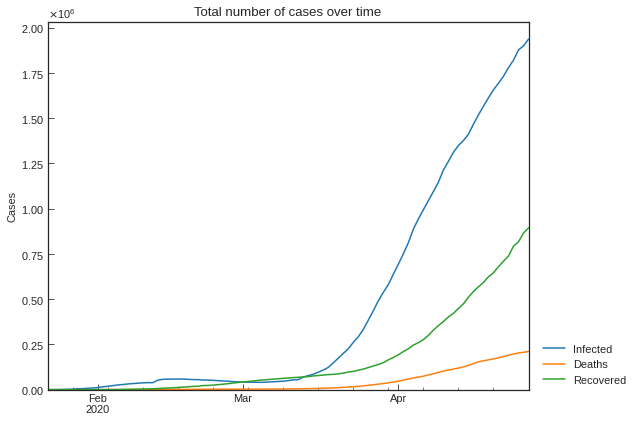

In [ ]:
line_plot(total_df[data_cols], "Total number of cases over time")

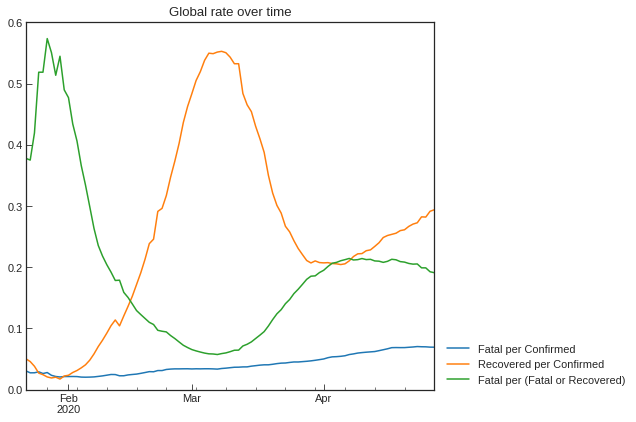

In [ ]:
line_plot(total_df[rate_cols], "Global rate over time", ylabel="", math_scale=False)

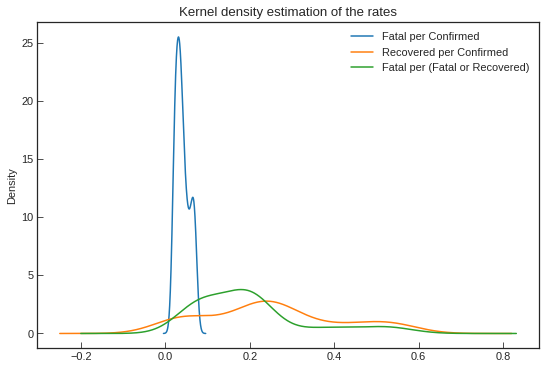

In [ ]:
total_df[rate_cols].plot.kde()
plt.title("Kernel density estimation of the rates")
plt.show()

In [ ]:
total_df[rate_cols].describe().T

count      mean  ...       75%       max
Fatal per Confirmed              97.0  0.040774  ...  0.053642  0.070456
Recovered per Confirmed          97.0  0.251489  ...  0.321137  0.552602
Fatal per (Fatal or Recovered)   97.0  0.197878  ...  0.212391  0.573427

[3 rows x 8 columns]

## Data cleaning: Linelist (COVID19_open_line_list.csv)

In [ ]:
linelist_open_raw = pd.read_csv("/content/drive/My Drive/covid 2020/COVID19_open_line_list.csv (1) (1).zip")
linelist_open_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14126 entries, 0 to 14125
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        13173 non-null  float64
 1   age                       1349 non-null   object 
 2   sex                       1264 non-null   object 
 3   city                      10194 non-null  object 
 4   province                  12906 non-null  object 
 5   country                   13148 non-null  object 
 6   wuhan(0)_not_wuhan(1)     13170 non-null  float64
 7   latitude                  13147 non-null  float64
 8   longitude                 13147 non-null  float64
 9   geo_resolution            13147 non-null  object 
 10  date_onset_symptoms       746 non-null    object 
 11  date_admission_hospital   730 non-null    object 
 12  date_confirmation         13089 non-null  object 
 13  symptoms                  493 non-null    object 
 14  lives_

In [ ]:
df = linelist_open_raw.loc[:, ~linelist_open_raw.columns.str.startswith("Unnamed:")]
df = df.dropna(axis=0, how="all")
df = df.drop(
    [
        # Unnecessary in this notebook
        "ID", "wuhan(0)_not_wuhan(1)", "admin3", "admin2", "admin1", "country_new", "admin_id",
        "data_moderator_initials", "source", "location", "lives_in_Wuhan", "notes_for_discussion",
        "sequence_available", "reported_market_exposure",
        # Maybe useful, but un-used
        "city", "latitude", "longitude", "geo_resolution", "additional_information",
        "travel_history_dates", "travel_history_location", 
    ],
    axis=1
)
# Personal
age = linelist_open_raw["age"].str.split("-", expand=True)
age[0] = pd.to_numeric(age[0], errors="coerce")
age[1] = pd.to_numeric(age[1], errors="coerce")
df["Age"] = age.mean(axis=1)
df["Age"] = df["Age"].fillna(df["Age"].median()).astype(np.int64)
df["Sex"] = df["sex"].fillna("-").str.replace("4000", "-").str.capitalize()
# Place
df["Country"] = df["country"].fillna("-")
df["Province"] = df["province"].fillna("-")
# Onset Date
series = df["date_onset_symptoms"].str.replace("end of December 2019", "31.12.2019").replace("-25.02.2020", "25.02.2020")
series = series.replace("20.02.220", "20.02.2020").replace("none", np.NaN).replace("10.01.2020 - 22.01.2020", np.NaN)
df["Onset_date"] = pd.to_datetime(series)
# Hospitalized date
series = df["date_admission_hospital"].replace("18.01.2020 - 23.01.2020", np.NaN)
df["Hospitalized_date"] = pd.to_datetime(series)
# Confirmed date
series = df["date_confirmation"].replace("25.02.2020-26.02.2020", np.NaN)
df["Confirmed_date"] = pd.to_datetime(series)
# Symptoms/events
df["Symptoms"] = df["symptoms"].fillna("-").str.lower()
# Underlying disease
df["Underlying_disease"] = df[["chronic_disease_binary", "chronic_disease"]].apply(
    lambda x: "No" if x[0] == 0 else x[1] if x[1] is not np.NaN else "-",
    axis=1
).str.strip(";").str.replace("; ", ",").str.replace(", ", ",")
# Outcome
df["Outcome"] = df["outcome"].replace(
    {
        "discharge": "discharged", "Discharged": "discharged", "death": "died",
        "critical condition, intubated as of 14.02.2020": "severe",
        "treated in an intensive care unit (14.02.2020)": "severe", "05.02.2020": "-",
        "Symptoms only improved with cough. Currently hospitalized for follow-up.": "stable"
    }
).fillna("-")
series = df["date_death_or_discharge"].replace("discharge", np.NaN)
df["Closed_date"] = pd.to_datetime(series)
# Show
use_cols = [
    "Age", "Sex", "Country", "Province", "Onset_date", "Hospitalized_date", "Confirmed_date", 
    "Symptoms", "Underlying_disease", "Outcome", "Closed_date"
]
open_linelist_df = df.loc[:, use_cols]
open_linelist_df.head()

Age     Sex Country Province  ... Symptoms Underlying_disease Outcome Closed_date
0   30    Male   China    Anhui  ...        -                  -       -         NaT
1   47    Male   China    Anhui  ...        -                  -       -         NaT
2   49    Male   China    Anhui  ...        -                  -       -         NaT
3   47  Female   China    Anhui  ...        -                  -       -         NaT
4   50  Female   China    Anhui  ...        -                  -       -         NaT

[5 rows x 11 columns]

## Data cleaning: Linelist (COVID19_line_list_data.csv)
Linelist in clinical trials is a list of many case reports.

In [ ]:
linelist_raw = pd.read_csv("/content/drive/My Drive/covid 2020/COVID19_line_list_data (1).csv")
linelist_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1085 non-null   int64  
 1   case_in_country        888 non-null    float64
 2   reporting date         1084 non-null   object 
 3   Unnamed: 3             0 non-null      float64
 4   summary                1080 non-null   object 
 5   location               1085 non-null   object 
 6   country                1085 non-null   object 
 7   gender                 902 non-null    object 
 8   age                    843 non-null    float64
 9   symptom_onset          563 non-null    object 
 10  If_onset_approximated  560 non-null    float64
 11  hosp_visit_date        507 non-null    object 
 12  exposure_start         128 non-null    object 
 13  exposure_end           341 non-null    object 
 14  visiting Wuhan         1085 non-null   int64  
 15  from

In [ ]:
linelist_raw.head()

id  case_in_country reporting date  ...  Unnamed: 24 Unnamed: 25 Unnamed: 26
0   1              NaN      1/20/2020  ...          NaN         NaN         NaN
1   2              NaN      1/20/2020  ...          NaN         NaN         NaN
2   3              NaN      1/21/2020  ...          NaN         NaN         NaN
3   4              NaN      1/21/2020  ...          NaN         NaN         NaN
4   5              NaN      1/21/2020  ...          NaN         NaN         NaN

[5 rows x 27 columns]

In [ ]:
df = linelist_raw.loc[:, ~linelist_raw.columns.str.startswith("Unnamed:")]
df = df.drop(["id", "case_in_country", "summary", "source", "link"], axis=1)
# Date
case_date_dict = {
    "reporting date": "Confirmed_date",
    "exposure_start": "Exposed_date",
    "exposure_end": "Quarantined_date",
    "hosp_visit_date": "Hospitalized_date",
    "symptom_onset": "Onset_date",
    "death": "Deaths_date",
    "recovered": "Recovered_date"    
}
df["death"] = df["death"].replace({"0": "", "1": ""})
df["recovered"] = df["recovered"].replace({"0": "", "1": "", "12/30/1899": "12/30/2019"})
for (col, _) in case_date_dict.items():
    df[col] = pd.to_datetime(df[col])
df = df.rename(case_date_dict, axis=1)
# Location
df["Country"] = df["country"].fillna("-")
df["Province"] = df["location"].fillna("-")
df["Province"] = df[["Country", "Province"]].apply(lambda x: "-" if x[0] == x[1] else x[1], axis=1)
# Personal
df["Gender"] = df["gender"].fillna("-").str.capitalize()
df["Age"] = df["age"].fillna(df["age"].median()).astype(np.int64) ## Fill in NA with median
df["From_Wuhan"] = df["from Wuhan"]
df["To_Wuhan"] = df["visiting Wuhan"]
# Medical
df["Events"] = df["symptom"].fillna("-")
# Order of columns
linelist_df = df.loc[
    :,
    [
        "Country", "Province",
        "Exposed_date", "Onset_date", "Hospitalized_date", "Confirmed_date", "Quarantined_date", "Deaths_date", "Recovered_date",
        "Events",
        "Gender", "Age", "From_Wuhan", "To_Wuhan"
    ]
]
linelist_df.tail()

Country   Province Exposed_date  ... Age From_Wuhan To_Wuhan
1080      Austria  Innsbruck          NaT  ...  24        0.0        0
1081  Afghanistan          -          NaT  ...  35        0.0        0
1082      Algeria          -          NaT  ...  51        0.0        0
1083      Croatia          -   2020-02-19  ...  51        0.0        0
1084  Switzerland       Bern   2020-02-15  ...  70        0.0        0

[5 rows x 14 columns]

In [ ]:
linelist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Country            1085 non-null   object        
 1   Province           1085 non-null   object        
 2   Exposed_date       128 non-null    datetime64[ns]
 3   Onset_date         563 non-null    datetime64[ns]
 4   Hospitalized_date  507 non-null    datetime64[ns]
 5   Confirmed_date     1084 non-null   datetime64[ns]
 6   Quarantined_date   341 non-null    datetime64[ns]
 7   Deaths_date        21 non-null     datetime64[ns]
 8   Recovered_date     152 non-null    datetime64[ns]
 9   Events             1085 non-null   object        
 10  Gender             1085 non-null   object        
 11  Age                1085 non-null   int64         
 12  From_Wuhan         1081 non-null   float64       
 13  To_Wuhan           1085 non-null   int64         
dtypes: datet

In [ ]:
linelist_df.describe(include="all").fillna("-")

Country Province         Exposed_date  ...      Age From_Wuhan  To_Wuhan
count     1085     1085                  128  ...     1085       1081      1085
unique      38      135                   37  ...        -          -         -
top      China        -  2020-01-26 00:00:00  ...        -          -         -
freq       197      464                   14  ...        -          -         -
first        -        -  2019-12-17 00:00:00  ...        -          -         -
last         -        -  2020-02-21 00:00:00  ...        -          -         -
mean         -        -                    -  ...  49.8212   0.144311  0.176959
std          -        -                    -  ...  16.1036   0.351567   0.38181
min          -        -                    -  ...        0          0         0
25%          -        -                    -  ...       39          0         0
50%          -        -                    -  ...       51          0         0
75%          -        -                    -  ...       58          0         0
max          -        -                    -  ...       96          1         1

[13 rows x 14 columns]

In [ ]:
period_df = select_area(linelist_df, group=None)
period_df = period_df.loc[:, ["Exposed_date", "Onset_date", "Confirmed_date"]]
period_df["Latent [min]"] = (period_df["Onset_date"] - period_df["Exposed_date"]).dt.total_seconds() / 60
period_df["Waiting [min]"] = (period_df["Confirmed_date"] - period_df["Onset_date"]).dt.total_seconds() / 60
period_df["Latent [day]"] = period_df["Latent [min]"] / 60 / 24
period_df["Waiting [day]"] = period_df["Waiting [min]"] / 60 / 24
period_df["Latent + Waiting [day]"] = period_df["Latent [day]"] + period_df["Waiting [day]"]
period_df.dropna(axis=0).tail()

Exposed_date Onset_date  ... Waiting [day]  Latent + Waiting [day]
948    2020-01-25 2020-02-24  ...           0.0                    30.0
949    2020-01-25 2020-02-04  ...          20.0                    30.0
957    2020-01-25 2020-02-12  ...          14.0                    32.0
958    2020-01-25 2020-02-17  ...           9.0                    32.0
1084   2020-02-15 2020-02-17  ...           8.0                    10.0

[5 rows x 8 columns]

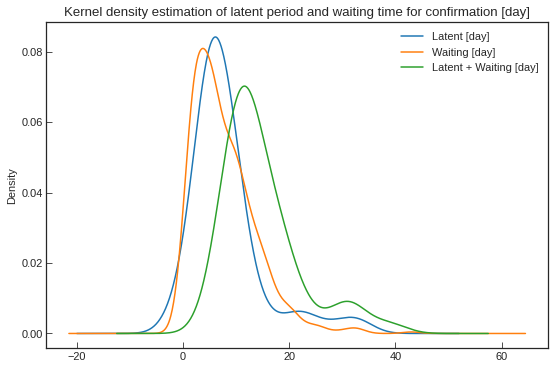

count       mean       std  min   25%   50%   75%   max
Latent [day]             83.0   8.180723  6.786185 -2.0   4.0   6.0   9.0  34.0
Waiting [day]           563.0   7.682060  5.890473  0.0   3.0   6.0  11.0  43.0
Latent + Waiting [day]   83.0  14.819277  7.305435  5.0  10.0  13.0  17.5  40.0

In [ ]:
cols = ["Latent [day]", "Waiting [day]", "Latent + Waiting [day]"]
period_df[cols].plot.kde()
plt.title("Kernel density estimation of latent period and waiting time for confirmation [day]")
plt.show()
period_df[cols].describe().T

## Measures in each country

In [ ]:
action_raw = dd.read_csv(
    "/content/drive/My Drive/covid 2020/COVID 19 Containment measures data.csv"
).compute()
action_raw.head()

ID Applies To         Country  ... Target country Target region Target state
0  163        NaN         Austria  ...            NaN           NaN          NaN
1  132        NaN         Germany  ...            NaN           NaN          NaN
2  578        NaN  United Kingdom  ...            NaN           NaN          NaN
3  372        NaN  United Kingdom  ...            NaN           NaN          NaN
4  357        NaN  United Kingdom  ...            NaN           NaN          NaN

[5 rows x 16 columns]

In [ ]:
df  = action_raw.copy()
df = df.rename(
    {
        "Description of measure implemented": "Details",
        "Implementing State/Province": "Province",
    },
    axis=1
)
# Country/Province
df["Country"] = df["Country"].replace({"United Kingdom": "UK"})
df["Country"] = df["Country"].str.replace("US: ", "US/").str.replace("US:", "US/")
df = df.loc[~df["Country"].isnull(), :]
df["Province"] = df["Province"].fillna("-")
df[["Country", "Province", "-"]] = (df["Country"] + "/" + df["Province"]).str.split("/", expand=True)
# Date
df["Start_date"] = pd.to_datetime(df["Date Start"])
df["End_date"] = pd.to_datetime(df["Date end intended"])
df = df.loc[~df["Start_date"].isnull(), :]
# Detail
df = df.loc[~df["Details"].isnull(), :]
df["Keywords"] = df["Keywords"].fillna("-")
df["Exceptions"] = df["Exceptions"].fillna("-")
# _df = df["Keywords"].str.split(", ", expand=True)
# df = pd.concat([df, _df], axis=1)
# Save
df = df.loc[:, ["Country", "Province", "Start_date", "End_date", "Keywords", "Details", "Exceptions"]]
df = df.sort_values(["Start_date", "End_date", "Country", "Province"])
action_df = df.copy()
action_df.head()

Country  ... Exceptions
150      China  ...          -
151      China  ...          -
152      China  ...          -
138  Hong Kong  ...          -
149      Macau  ...          -

[5 rows x 7 columns]

In [ ]:
words = pd.Series(", ".join(action_df["Keywords"].tolist()).split(", ")).unique().tolist()
words

['first case',
 'compulsory isolation',
 'confirmed case isolation',
 'case reporting',
 'research',
 'source tracing',
 'international traveller quarantine - risk countries',
 'international traveller screening - all countries',
 'coronavirus education activities',
 'encouraging symptomatic people to seek tests',
 'international traveller screening - risk countries',
 'limited nonessential business suspension',
 'test travellers',
 'contacts traced total',
 'outbound travel warning',
 'public announcement',
 'special management arrangements',
 'task group',
 'hospital specialisation',
 'contact isolation - no symptoms',
 'contact tracing',
 'public mask and hygiene supply',
 'testing commenced',
 'international travel ban - risk countries',
 'international traveller screening - symptomatic',
 'general nonessential business suspension',
 'hygiene enforcement',
 'quarantine zone',
 'cluster isolation - no symptoms',
 'traveller testing',
 'wild animal ban',
 'phone line',
 'moves of med

In [ ]:
vectorizer = TfidfVectorizer(use_idf=True)
vecs = vectorizer.fit_transform(words)
clusters = KMeans(n_clusters=20, random_state=0).fit_predict(vecs)
df = pd.DataFrame(
    {
        "Group": clusters,
        "Word": words
    }
)
df = df.sort_values("Group")
df = pd.DataFrame(df.groupby("Group")["Word"].apply(lambda x: ", ".join(x)))
df

Word
Group                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
0      sentence, military takeover, symptom hotline, protective equipment supplies, elderly, prisons closed to visitors, riots, unemployment benefits extension, visa suspension, university closure, economic stimulus, retired doctors called, restaurant limitations, weddings canceled, phone based location tracing, event cancellation - other, nursery school closure, school closure, activism for stricter measures, eviction moratorium, army deployed, cash cleaning, financial incentive, indoor person density, sports cancellation, -, medical aid, quaratine violation, court cancellation, school closure - limited, community spread, intellectual property, low compliance, prohibition of medicine export, prisoner release, medical staff protective equipment, handwashing encouragement, sewing plain clothes masks, closure nonessential stores, emergency declaration, social distancing, deregulation, space minimum, economic incentives, airport closure, health declaration system, task group, special managem...
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      international traveller quarantine - risk countries, international traveller screening - all countries, international traveller screening - symptomatic, international traveller quarantine - all countries, international aid, international travel ban - risk countries, international travel ban - all countries, international traveller screening - risk countries
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            remote work - limited, remote schooling, mandated remote schooling, remote work, mandated remote 

## Measures in Italy

In [ ]:
ita_action_raw = pd.read_excel(
    "/content/drive/My Drive/coviddata3/Dataset_Italy_COVID_19.xlsx",
    sheet_name="Foglio1"
)
ita_action_raw.head()

Country  ...                                                        link
0   Italy  ...  http://www.governo.it/it/approfondimento/coronavirus/13968
1   Italy  ...  http://www.governo.it/it/approfondimento/coronavirus/13969
2   Italy  ...  http://www.governo.it/it/approfondimento/coronavirus/13970
3   Italy  ...  http://www.governo.it/it/approfondimento/coronavirus/13971
4   Italy  ...  http://www.governo.it/it/approfondimento/coronavirus/13972

[5 rows x 9 columns]

In [ ]:
ita_action_raw = pd.read_excel(
    "/content/drive/My Drive/covid 2020/Italy-2019.csv",
    sheet_name="Foglio1"
)
ita_action_raw.head()

XLRDError: ignored

In [ ]:
df = ita_action_raw.copy()
df = df.drop(["Country", "Village", "link"], axis=1)
df.columns = [col.capitalize().replace(" ", "_") for col in df.columns]
df["Start_date"] = pd.to_datetime(df["Start_date"])
df["End_date"] = pd.to_datetime(df["End_date"])
df["Region"] = df["Region"].fillna("-")
df["Number_of_people"] = df["Number_of_people"].fillna(-1)
ita_action_df = df.copy()
ita_action_df.tail()

Region  ... Number_of_people
7   Emilia Romagna,Friuli Venezia Giulia, Lombardia, Veneto, Piemonte e Liguria,  ...               -1
8                                                                              -  ...         60483973
9                                                                              -  ...              330
10                                                                             -  ...               -1
11                                                                             -  ...               -1

[5 rows x 6 columns]

## The number of cases in Japan

In [ ]:
jpn_ncov_raw = pd.read_csv("/content/drive/My Drive/covid 2020/covid japon/covid_jpn_total (1).csv")
jpn_ncov_raw.tail()

Date  Location  Positive  ...  Hosp_waiting  Discharged  Fatal
224  2020-05-03   Airport       147  ...             0           2      0
225  2020-05-03  Returnee        15  ...             0          15      0
226  2020-05-04  Domestic     14895  ...           276        4479    510
227  2020-05-04   Airport       147  ...             0           2      0
228  2020-05-04  Returnee        15  ...             0          15      0

[5 rows x 13 columns]

In [ ]:
# https://www.kaggle.com/lisphilar/eda-of-japan-dataset
# and remove returunee/airport cases
df = jpn_ncov_raw.copy()
df.dropna(how="any", inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df = df.groupby("Location").apply(
    lambda x: x.set_index("Date").resample("D").interpolate(method="linear")
)
df = df.drop("Location", axis=1).reset_index()
df = df.loc[df["Location"] == "Domestic", :].drop("Location", axis=1)
df = df.set_index("Date").resample("D").last().fillna("ffill")
sel = df.columns.isin(["Location", "Date"])
df.loc[:, ~sel] = df.loc[:, ~sel].astype(np.int64)
jpn_ncov_df = df.copy()
jpn_ncov_df.tail()

Positive  Tested  Symptomatic  ...  Hosp_waiting  Discharged  Fatal
Date                                       ...                                 
2020-04-30     13929  137338         8469  ...           310        3449    415
2020-05-01     14120  145243         8596  ...           287        3964    432
2020-05-02     14383  152029         8683  ...           288        4194    458
2020-05-03     14677  153047         8802  ...           284        4368    492
2020-05-04     14895  153581         8921  ...           276        4479    510

[5 rows x 11 columns]

## The number of cases in Japan at prefecture level

In [ ]:
jpn_pref_raw = pd.read_csv("/content/drive/My Drive/covid 2020/covid japon/covid_jpn_prefecture (1).csv")
jpn_pref_raw.tail()

Date Prefecture  Positive  Tested  Discharged  Fatal
2204  2020-05-03   Kumamoto        47  3178.0        13.0    2.0
2205  2020-05-03       Oita        60  3175.0        32.0    1.0
2206  2020-05-03   Miyazaki        17  1122.0        11.0    0.0
2207  2020-05-03  Kagoshima        10  1287.0         4.0    0.0
2208  2020-05-03    Okinawa       142  2211.0        24.0    4.0

In [ ]:
df = jpn_pref_raw.copy()
df.dropna(how="all", inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
sel = df.columns.isin(["Date", "Prefecture"])
df = df.groupby("Prefecture").apply(
    lambda x: x.set_index("Date").resample("D").interpolate("linear")
)
df = df.drop("Prefecture", axis=1).reset_index()
df = df.sort_values("Date").reset_index(drop=True)
sel = df.columns.isin(["Date", "Prefecture"])
df.loc[:, ~sel] = df.loc[:, ~sel].interpolate("linear").astype(np.int64)
jpn_pref_df = df.copy()
jpn_pref_df.tail()

Prefecture       Date  Positive  Tested  Discharged  Fatal
2204   Shizuoka 2020-05-03        73    2780          24      1
2205   Nagasaki 2020-05-03        17    2050          10      1
2206      Kochi 2020-05-03        74    1496          49      3
2207      Aichi 2020-05-03       492    7463          75     34
2208  Yamanashi 2020-05-03        56    2358          29      0

## Metadata of prefectures in Japan

In [ ]:
jpn_meta_raw = pd.read_csv("/content/drive/My Drive/covid 2020/covid japon/covid_jpn_metadata (1).csv")
jpn_meta_raw.tail()

Prefecture  ... Secondary_source
841   Kumamoto  ...              NaN
842       Oita  ...              NaN
843   Miyazaki  ...              NaN
844  Kagoshima  ...              NaN
845    Okinawa  ...              NaN

[5 rows x 7 columns]

In [ ]:
df = jpn_meta_raw.copy()
df["Title"] = df["Category"].str.cat(df["Item"], sep="_")
df = df.pivot_table(
    index="Prefecture", columns="Title", values="Value", aggfunc="last"
)
# Integer
cols = df.columns.str.startswith("Population")
cols += df.columns.str.startswith("Area")
cols += df.columns.str.startswith("Hospital_bed")
cols += df.columns.str.startswith("Clinic_bed")
df.loc[:, cols] = df.loc[:, cols].astype(np.int64)
df["Admin_Num"] = df["Admin_Num"].astype(np.int64)
# Numeric
cols = df.columns.str.startswith("Location")
df.loc[:, cols] = df.loc[:, cols].astype(np.float64)
# Sorting
df = df.loc[jpn_meta_raw["Prefecture"].unique(), :]
jpn_meta_df = df.copy()
jpn_meta_df.head()

Title      Admin_Captial  Admin_Num  ... Population_Male Population_Total
Prefecture                           ...                                 
Hokkaido         Sapporo          1  ...            2506             5320
Aomori            Aomori          2  ...             600             1278
Iwate            Morioka          3  ...             604             1255
Miyagi            Sendai          4  ...            1136             2323
Akita              Akita          5  ...             468              996

[5 rows x 18 columns]

# Grouping by growth factor<a id="2"></a>
The number of confirmed cases is increasing in many countries, but there are two of countries. In a first-type country, growth factor is larger than 1 and the number of cases is rapidly increasing. In a second-type country, growth factor is less than 1.

## Calculate growth factor
Where $C$ is the number of confirmed cases,  
$$\mathrm{Growth\ Factor} = \cfrac{\Delta \mathrm{C}_{n}}{\Delta \mathrm{C}_{n-1}}$$

In [ ]:
df = ncov_df_ungrouped.pivot_table(
    index="Date", columns="Country", values="Confirmed", aggfunc="sum"
).fillna(method="ffill").fillna(0)
# Growth factor: (delta Number_n) / (delta Number_n)
df = df.diff() / df.diff().shift(freq="D")
df = df.replace(np.inf, np.nan).fillna(1.0)
# Rolling mean (window: 7 days)
df = df.rolling(7).mean().dropna().loc[:ncov_df_ungrouped["Date"].max(), :]
# round: 0.01
growth_value_df = df.round(2)
growth_value_df.tail()

Country      Azerbaijan  Afghanistan  ...  Zimbabwe  occupied Palestinian territory
Date                                  ...                                          
2020-04-23          1.0         1.30  ...      0.71                             1.0
2020-04-24          1.0         1.23  ...      0.71                             1.0
2020-04-25          1.0         1.39  ...      0.86                             1.0
2020-04-26          1.0         1.15  ...      0.86                             1.0
2020-04-27          1.0         1.44  ...      0.86                             1.0

[5 rows x 216 columns]

## Grouping countires based on growth factor
* Outbreaking: growth factor $>$ 1 for the last 7 days
* Stopping: growth factor $<$ 1 for the last 7 days
* At a crossroad: the others

In [ ]:
df = growth_value_df.copy()
df = df.iloc[-7:, :].T
day_cols = df.columns.strftime("%d%b%Y")
df.columns = day_cols
last_date = day_cols[-1]
# Grouping
more_col, less_col = "GF > 1 [straight days]", "GF < 1 [straight days]"
df[more_col] = (growth_value_df > 1).iloc[::-1].cumprod().sum(axis=0)
df[less_col] = (growth_value_df < 1).iloc[::-1].cumprod().sum(axis=0)
df["Group"] = df[[more_col, less_col]].apply(
    lambda x: "Outbreaking" if x[0] >= 7 else "Stopping" if x[1] >= 7 else "Crossroad",
    axis=1
)
# Sorting
df = df.loc[:, ["Group", more_col, less_col, *day_cols]]
df = df.sort_values(["Group", more_col, less_col], ascending=False)
growth_df = df.copy()
growth_df.head()

Date                      Group  GF > 1 [straight days]  ...  26Apr2020  27Apr2020
Country                                                  ...                      
Chad                   Stopping                       0  ...       0.84       0.84
Equatorial Guinea      Stopping                       0  ...       0.51       0.51
Nicaragua              Stopping                       0  ...       0.71       0.71
Saint Kitts and Nevis  Stopping                       0  ...       0.86       0.86
Syria                  Stopping                       0  ...       0.71       0.71

[5 rows x 10 columns]

In [ ]:
df = pd.merge(ncov_df_ungrouped, growth_df["Group"].reset_index(), on="Country")
ncov_df = df.loc[:, ["Date", "Group", *ncov_df_ungrouped.columns[1:]]]
ncov_df.tail()

Date      Group Country  ... Infected  Deaths  Recovered
19281 2020-04-23  Crossroad   Yemen  ...        1       0          0
19282 2020-04-24  Crossroad   Yemen  ...        0       0          1
19283 2020-04-25  Crossroad   Yemen  ...        0       0          1
19284 2020-04-26  Crossroad   Yemen  ...        0       0          1
19285 2020-04-27  Crossroad   Yemen  ...        0       0          1

[5 rows x 8 columns]

## Group 1: Outbreaking, growth factor $>$ 1 for the last 7 days

In [ ]:
df = growth_df.loc[growth_df["Group"] == "Outbreaking", :]
", ".join(df.index.tolist()) + "."

'Mexico, Bahrain, Bulgaria, Estonia, Guatemala, Honduras, India, Latvia, Peru, Qatar, Russia, Senegal, Afghanistan, Brazil, Kenya, Saudi Arabia, Bangladesh, Slovakia, Armenia, Mali, Albania, Burma, Congo, Ecuador, Dominican Republic, Egypt, El Salvador, South Africa, Montenegro, Pakistan, Rwanda, Cabo Verde, Luxembourg, Norway, Kuwait, San Marino, Jordan, Sierra Leone, Maldives, Azerbaijan, Hungary, Mozambique, Spain, Burkina Faso, Gabon, Jamaica, Malta, Panama, Costa Rica, Croatia, Greece, Indonesia, Ukraine.'

In [ ]:
growth_df.loc[growth_df["Group"] == "Outbreaking", :].head()

Date             Group  GF > 1 [straight days]  ...  26Apr2020  27Apr2020
Country                                         ...                      
Mexico     Outbreaking                      39  ...       1.21       1.18
Bahrain    Outbreaking                      33  ...       1.40       1.55
Bulgaria   Outbreaking                      33  ...       1.73       1.59
Estonia    Outbreaking                      33  ...       1.57       1.57
Guatemala  Outbreaking                      33  ...       1.62       1.57

[5 rows x 10 columns]

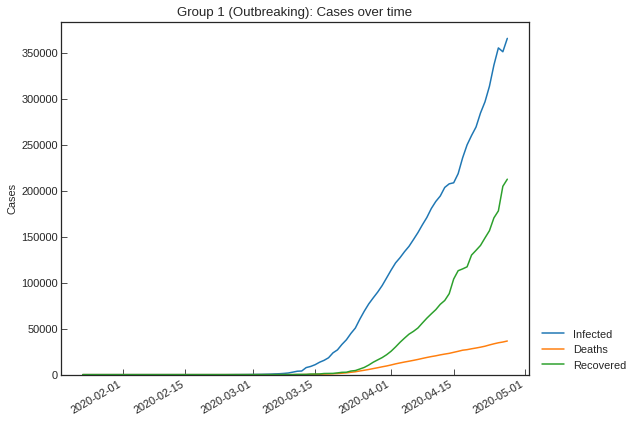

Infected  Deaths  Recovered
Date                                   
2020-04-23    313477   32271     156482
2020-04-24    336488   33516     170414
2020-04-25    355223   34637     178016
2020-04-26    351029   35462     204752
2020-04-27    365587   36559     212496

In [ ]:
df = ncov_df.loc[ncov_df["Group"] == "Outbreaking", ["Date", *data_cols]].groupby("Date").sum()
line_plot(df, "Group 1 (Outbreaking): Cases over time", y_integer=True)
df.tail()

## Group 2: Stopping, growth factor $<$ 1 for the last 7 days

In [ ]:
df = growth_df.loc[growth_df["Group"] == "Stopping", :]
", ".join(df.index.tolist()) + "."

'Chad, Equatorial Guinea, Nicaragua, Saint Kitts and Nevis, Syria, Zimbabwe, Botswana, Fiji, Trinidad and Tobago, Cameroon, Andorra, Hong Kong, Nepal, Central African Republic, Iran, Papua New Guinea, Angola, Ghana, West Bank and Gaza, Djibouti, Liberia, Liechtenstein, Serbia, Benin, Holy See, Libya, Nigeria.'

In [ ]:
growth_df.loc[growth_df["Group"] == "Stopping", :].head()

Date                      Group  GF > 1 [straight days]  ...  26Apr2020  27Apr2020
Country                                                  ...                      
Chad                   Stopping                       0  ...       0.84       0.84
Equatorial Guinea      Stopping                       0  ...       0.51       0.51
Nicaragua              Stopping                       0  ...       0.71       0.71
Saint Kitts and Nevis  Stopping                       0  ...       0.86       0.86
Syria                  Stopping                       0  ...       0.71       0.71

[5 rows x 10 columns]

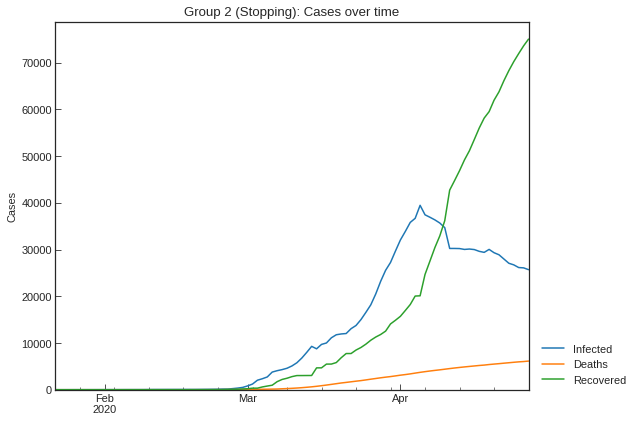

Infected  Deaths  Recovered
Date                                   
2020-04-23     27064    5770      68285
2020-04-24     26721    5868      70214
2020-04-25     26146    5958      71940
2020-04-26     26077    6028      73596
2020-04-27     25691    6126      75043

In [ ]:
df = ncov_df.loc[ncov_df["Group"] == "Stopping", ["Date", *data_cols]].groupby("Date").sum()
line_plot(df, "Group 2 (Stopping): Cases over time", y_integer=True)
df.tail()

## Group 3: At a crossroad, the others

In [ ]:
df = growth_df.loc[growth_df["Group"] == "Crossroad", :]
", ".join(df.index.tolist()) + "."

'Chile, Israel, Malawi, Moldova, North Macedonia, Sri Lanka, Uganda, Argentina, Bolivia, Philippines, Uruguay, Venezuela, Cyprus, Eswatini, Georgia, Thailand, Zambia, Algeria, Austria, Bahamas, Bosnia and Herzegovina, Canada, Denmark, Ethiopia, Iceland, Iraq, Slovenia, Finland, Ireland, Niger, Romania, South Korea, China, Colombia, France, Guinea-Bissau, Japan, Madagascar, Malaysia, Mauritius, Tunisia, Uzbekistan, Bhutan, Turkey, Antigua and Barbuda, Burundi, Grenada, Netherlands, Paraguay, Saint Vincent and the Grenadines, Australia, Cuba, Somalia, South Sudan, Tanzania, Italy, Ivory Coast, Lithuania, Mongolia, Sudan, Timor-Leste, UK, Vietnam, Belgium, Czech Republic, Guinea, New Zealand, Switzerland, Taiwan, Germany, Haiti, Kazakhstan, Lebanon, Morocco, Oman, Portugal, Singapore, Sweden, Togo, US,  Azerbaijan, Aruba, Bahamas, The, Barbados, Belarus, Belize, Brunei, Cambodia, Cape Verde, Cayman Islands, Channel Islands, Curacao, Dominica, East Timor, Eritrea, Faroe Islands, French Gui

In [ ]:
growth_df.loc[growth_df["Group"] == "Crossroad", :].head()

Date                 Group  GF > 1 [straight days]  ...  26Apr2020  27Apr2020
Country                                             ...                      
Chile            Crossroad                       6  ...       1.06       1.04
Israel           Crossroad                       6  ...       1.05       1.02
Malawi           Crossroad                       6  ...       1.57       1.71
Moldova          Crossroad                       6  ...       1.13       1.11
North Macedonia  Crossroad                       6  ...       1.38       1.40

[5 rows x 10 columns]

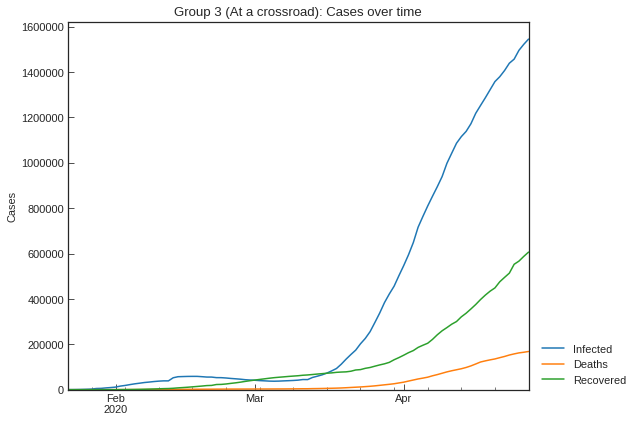

Infected  Deaths  Recovered
Date                                   
2020-04-23   1439000  152817     513719
2020-04-24   1456935  157767     552792
2020-04-25   1495846  162251     566729
2020-04-26   1522092  165054     587385
2020-04-27   1545352  168482     606428

In [ ]:
df = ncov_df.loc[ncov_df["Group"] == "Crossroad", ["Date", *data_cols]].groupby("Date").sum()
line_plot(df, "Group 3 (At a crossroad): Cases over time", y_integer=True)
df.tail()

# SIR to SIR-F<a id="4"></a>
In this section, we will create a customized mathematical model derived from SIR model.

## SIR model
To understand the trend of infection, we will use mathematical epidemic model. Let's start discussion using the simplest model named SIR.

### What is SIR model?
SIR model is a simple mathematical model to understand outbreak of infectious diseases.  
[The SIR epidemic model - Learning Scientific Programming with Python](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/)

 * S: Susceptible (=All - Confirmed)
 * I: Infected (=Confirmed - Recovered - Deaths)
 * R: Recovered or fatal (=Recovered + Deaths)
 
Note: THIS IS NOT THE GENERAL MODEL!  
Though R in SIR model is "Recovered and have immunity", I defined "R as Recovered or fatal". This is because mortality rate cannot be ignored in the real COVID-19 data.

Model:  
\begin{align*}
\mathrm{S} \overset{\beta I}{\longrightarrow} \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}  \\
\end{align*}

$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery(+Mortality) rate [1/min]  

Ordinary Differential Equation (ODE):  
\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - \gamma I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
\end{align*}

Where $N=S+I+R$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR model
To simplify the model, we will remove the units of the variables from ODE.

Set $(S, I, R) = N \times (x, y, z)$ and $(T, \beta, \gamma) = (\tau t, \tau^{-1} \rho, \tau^{-1} \sigma)$.  

This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - \sigma y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
\end{align*}

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
\begin{align*}
& 0 \leq (x, y, z, \rho, \sigma) \leq 1  \\
\end{align*}
\begin{align*}
& 1\leq \tau \leq 1440  \\
\end{align*}

Basic reproduction number, Non-dimentional parameter, is defined as  
\begin{align*}
R_0 = \rho \sigma^{-1} = \beta \gamma^{-1}
\end{align*}

Estimated Mean Values of $R_0$:  
$R_0$ ("R naught") means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)).  
(Secondary data: [Van den Driessche, P., & Watmough, J. (2002).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118))  
2.06: Zika in South America, 2015-2016  
1.51: Ebola in Guinea, 2014  
1.33: H1N1 influenza in South Africa, 2009  
3.5 : SARS in 2002-2003  
1.68: H2N2 influenza in US, 1957  
3.8 : Fall wave of 1918 Spanish influenza in Genova  
1.5 : Spring wave of 1918 Spanish influenza in Genova  

When $x=\frac{1}{R_0}$, $\frac{\mathrm{d}y}{\mathrm{d}t}=0$.
<!--This means that the max value of confirmed ($=y+z$) is $1-\frac{1}{R_0}$.-->

### Example of non-dimensional SIR model
For example, set $R_0 = 2.5, \rho=0.2$ and initial values $(x_{(0)}, y_{(0)}, z_{(0)}) = (0.999, 0.001, 0)$. "SIR" class was defined in Preparation part.

In [ ]:
eg_r0, eg_rho = (2.5, 0.2)
eg_sigma = eg_rho / eg_r0
eg_initials = (0.999, 0.001, 0)
display(Markdown(rf"$\rho = {eg_rho},\ \sigma = {eg_sigma}$."))

$\rho = 0.2,\ \sigma = 0.08$.

In [ ]:
%%time
eg_df = simulation(SIR, eg_initials, step_n=180, rho=eg_rho, sigma=eg_sigma)
eg_df.tail()

CPU times: user 8.85 ms, sys: 0 ns, total: 8.85 ms
Wall time: 10 ms


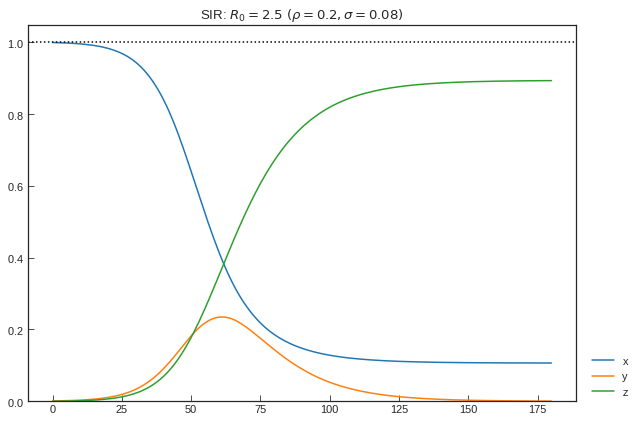

In [ ]:
line_plot(
    eg_df.set_index("t"),
    title=r"SIR: $R_0={0}\ (\rho={1}, \sigma={2})$".format(eg_r0, eg_rho, eg_sigma),
    ylabel="",
    h=1
)

There is an inflection point of y (the number of currentry infected cases per total population). At this point, value of x (the number of susceptible cases per total population) is nearly equal to $\frac{1}{R_0}$.

In [ ]:
x_max = eg_df.loc[eg_df["y"].idxmax(), "x"]
(x_max, 1/eg_r0)

(0.39661788452227087, 0.4)

### Dimensionalization
Here, we will dimensionalize the data, assuming that start date is the first date of JHU dataset, $\tau=1440$ [min] and total population $N=1,000,000$.

In [ ]:
eg_tau = 1440
eg_start_date = ncov_df["Date"].min()
eg_total_population = 1_000_000
print(f"The start date is {eg_start_date.strftime('%d%b%Y')}.")

The start date is 22Jan2020.


In [ ]:
eg_ori_df = pd.DataFrame(
    {
        "Date": (eg_df["t"] * eg_tau).apply(lambda x: timedelta(minutes=x)) + eg_start_date,
        "Group": "Stopping",
        "Country": "Example",
        "Province": "-",
        "Susceptible": 0,
        "Confirmed": 0,
        "Infected": (eg_df["y"] * eg_total_population).astype(np.int64)
    }
)
eg_ori_df["Recovered + Deaths"] = (eg_df["z"] * eg_total_population).astype(np.int64)
eg_ori_df ["Confirmed"] = eg_ori_df[["Infected", "Recovered + Deaths"]].sum(axis=1)
eg_ori_df["Susceptible"] = eg_total_population - eg_ori_df["Confirmed"]
eg_ori_df.tail()

Date     Group  Country  ... Confirmed  Infected  Recovered + Deaths
176 2020-07-16  Stopping  Example  ...    893360       658              892702
177 2020-07-17  Stopping  Example  ...    893373       620              892753
178 2020-07-18  Stopping  Example  ...    893386       585              892801
179 2020-07-19  Stopping  Example  ...    893399       552              892847
180 2020-07-20  Stopping  Example  ...    893409       520              892889

[5 rows x 8 columns]

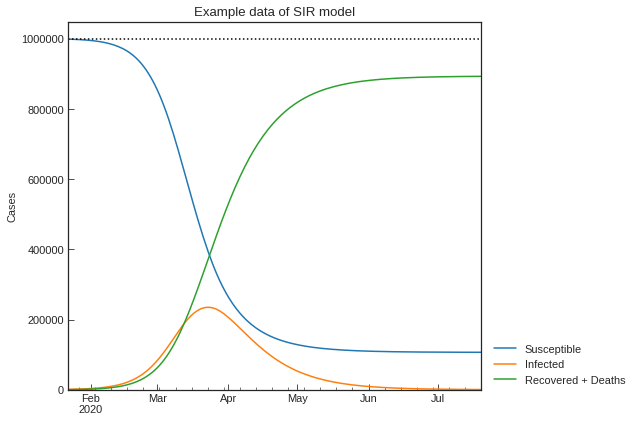

In [ ]:
line_plot(
    eg_ori_df.set_index("Date")[["Susceptible", "Infected", "Recovered + Deaths"]],
    "Example data of SIR model",
    h=eg_total_population,
    y_integer=True
)

## SIR-D model
Because we are measuring the number of fatal cases and recovered cases separately, we can use two variables ("Recovered" and "Deaths") instead of "Recovered + Deaths" in the mathematical model.

### What is SIR-D model?
* S: Susceptible
* I: Infected
* R: Recovered
* D: Deaths

Model:  
\begin{align*}
\mathrm{S} \overset{\beta  I}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}  \\
& \mathrm{I} \overset{\alpha}{\longrightarrow} \mathrm{D}  \\
\end{align*}

$\alpha$: Mortality rate [1/min]  
$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery rate [1/min]  

Ordinary Differential Equation (ODE):
\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - (\gamma + \alpha) I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
& \frac{\mathrm{d}D}{\mathrm{d}T}= \alpha I  \\
\end{align*}

Where $N=S+I+R+D$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR-D model
Set $(S, I, R, D) = N \times (x, y, z, w)$ and $(T, \alpha, \beta, \gamma) = (\tau t, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \kappa y  \\
\end{align*}

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
\begin{align*}
& 0 \leq (x, y, z, w, \kappa, \rho, \sigma) \leq 1  \\
\end{align*}
\begin{align*}
& 1\leq \tau \leq 1440  \\
\end{align*}

Reproduction number can be defined as  
\begin{align*}
R_0 = \rho (\sigma + \kappa)^{-1} = \beta (\gamma + \alpha)^{-1}
\end{align*}

### Example of non-dimensional SIR-D model
For example, set $R_0 = 2.5, \kappa=0.005, \rho=0.2$ and initial values $(x_{(0)}, y_{(0)}, z_{(0)}, w_{(0)}) = (0.999, 0.001, 0, 0)$.

In [ ]:
eg_r0, eg_kappa, eg_rho = (2.5, 0.005, 0.2)
eg_sigma = eg_rho / eg_r0 - eg_kappa
eg_initials = (0.999, 0.001, 0, 0)
display(Markdown(rf"$\kappa = {eg_kappa},\ \rho = {eg_rho},\ \sigma = {eg_sigma}$."))

$\kappa = 0.005,\ \rho = 0.2,\ \sigma = 0.075$.

In [ ]:
%%time
eg_df = simulation(SIRD, eg_initials, step_n=180, kappa=eg_kappa, rho=eg_rho, sigma=eg_sigma)
eg_df.tail()

CPU times: user 10.7 ms, sys: 0 ns, total: 10.7 ms
Wall time: 11.2 ms


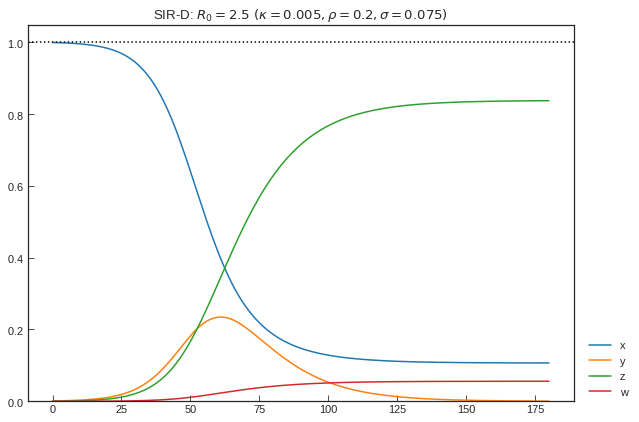

In [ ]:
line_plot(
    eg_df.set_index("t"),
    title=r"SIR-D: $R_0={0}\ (\kappa={1}, \rho={2}, \sigma={3})$".format(eg_r0, eg_kappa, eg_rho, eg_sigma),
    ylabel="",
    h=1
)

There is an inflection point of y (the number of currentry infected cases per total population). At this point, value of x (the number of susceptible cases per total population) is nearly equal to $\frac{1}{R_0}$.

In [ ]:
x_max = eg_df.loc[eg_df["y"].idxmax(), "x"]
(x_max, 1/eg_r0)

(0.39683686426375786, 0.4)

### Dimensionalization
Here, we will dimensionalize the data, assuming that start date is the first date of JHU dataset, $\tau=1440$ [min] and total population $N=1,000,000$.

In [ ]:
eg_tau = 1440
eg_start_date = ncov_df["Date"].min()
eg_total_population = 1_000_000
print(f"The start date is {eg_start_date.strftime('%d%b%Y')}.")

The start date is 22Jan2020.


In [ ]:
eg_ori_df = pd.DataFrame(
    {
        "Date": (eg_df["t"] * eg_tau).apply(lambda x: timedelta(minutes=x)) + eg_start_date,
        "Group": "Stopping",
        "Country": "Example",
        "Province": "-",
        "Susceptible": 0,
        "Confirmed": 0,
        "Infected": (eg_df["y"] * eg_total_population).astype(np.int64)
    }
)
eg_ori_df["Recovered"] = (eg_df["z"] * eg_total_population).astype(np.int64)
eg_ori_df["Deaths"] = (eg_df["w"] * eg_total_population).astype(np.int64)
eg_ori_df["Confirmed"] = eg_ori_df[["Infected", "Recovered", "Deaths"]].sum(axis=1)
eg_ori_df["Susceptible"] = eg_total_population - eg_ori_df["Confirmed"]
eg_ori_df.tail()

Date     Group  Country  ... Infected  Recovered  Deaths
176 2020-07-16  Stopping  Example  ...      660     836803   55786
177 2020-07-17  Stopping  Example  ...      622     836851   55790
178 2020-07-18  Stopping  Example  ...      587     836896   55793
179 2020-07-19  Stopping  Example  ...      553     836939   55795
180 2020-07-20  Stopping  Example  ...      522     836979   55798

[5 rows x 9 columns]

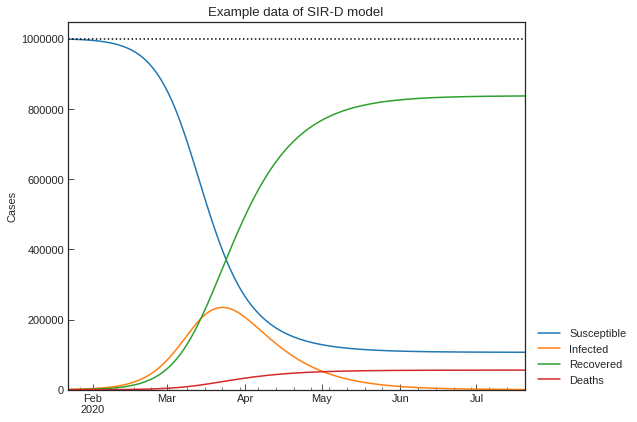

In [ ]:
line_plot(
    eg_ori_df.set_index("Date")[["Susceptible", "Infected", "Recovered", "Deaths"]],
    "Example data of SIR-D model",
    h=eg_total_population,
    y_integer=True
)

## SIR-F model
It is reported that some cases died before clinical diagnosis of COVID-19. To consider this issue, "S + I $\to$ Fatal + I" will be added to the model.

### What is SIR-F model?
* S: Susceptible
* S$^\ast$: Confirmed and un-categorized
* I: Confirmed and categorized as I
* R: Recovered
* F: Fatal with confirmation

Measurable variables:  
Confirmed = $I+R+F$  
Recovered = $R$  
Deaths = $F$  

Model:  
\begin{align*}
\mathrm{S} \overset{\beta I}{\longrightarrow} \mathrm{S}^\ast \overset{\alpha_1}{\longrightarrow}\ & \mathrm{F}    \\
\mathrm{S}^\ast \overset{1 - \alpha_1}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}    \\
& \mathrm{I} \overset{\alpha_2}{\longrightarrow} \mathrm{F}    \\
\end{align*}

$\alpha_1$: Mortality rate of S$^\ast$ cases [-]  
$\alpha_2$: Mortality rate of I cases [1/min]  
$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery rate [1/min]  

Note: When $\alpha_1 = 0$, SIR-F model is the same as SIR-D model.

Ordinary Differential Equation (ODE):   
\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}(1 - \alpha_1) \beta S I - (\gamma + \alpha_2) I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
& \frac{\mathrm{d}F}{\mathrm{d}T}= N^{-1}\alpha_1 \beta S I + \alpha_2 I  \\
\end{align*}

Where $N=S+I+R+F$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR-F model
Set $(S, I, R, F) = N \times (x, y, z, w)$ and $(T, \alpha_1, \alpha_2, \beta, \gamma) = (\tau t, \theta, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho (1-\theta) x y - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \rho \theta x y + \kappa y  \\
\end{align*}

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
\begin{align*}
& 0 \leq (x, y, z, w, \theta, \kappa, \rho, \sigma) \leq 1  \\
\end{align*}
\begin{align*}
& 1\leq \tau \leq 1440  \\
\end{align*}

Reproduction number can be defined as  
\begin{align*}
R_0 = \rho (1 - \theta) (\sigma + \kappa)^{-1} = \beta (1 - \alpha_1) (\gamma + \alpha_2)^{-1}
\end{align*}

### Example of non-dimensional SIR-F model
For example, set $R_0 = 2.5, \theta=0.002, \kappa=0.005, \rho=0.2$ and initial values $(x_{(0)}, y_{(0)}, z_{(0)}, w_{(0)}) = (0.999, 0.001, 0, 0)$.

In [ ]:
eg_r0, eg_theta, eg_kappa, eg_rho = (2.5, 0.002, 0.005, 0.2)
eg_sigma = eg_rho / eg_r0 - eg_kappa
eg_initials = (0.999, 0.001, 0, 0)
display(Markdown(rf"$\theta = {eg_theta},\ \kappa = {eg_kappa},\ \rho = {eg_rho},\ \sigma = {eg_sigma}$."))

$\theta = 0.002,\ \kappa = 0.005,\ \rho = 0.2,\ \sigma = 0.075$.

In [ ]:
%%time
eg_df = simulation(SIRF, eg_initials, step_n=180, theta=eg_theta, kappa=eg_kappa, rho=eg_rho, sigma=eg_sigma)
eg_df.tail()

CPU times: user 9.52 ms, sys: 909 µs, total: 10.4 ms
Wall time: 13.3 ms


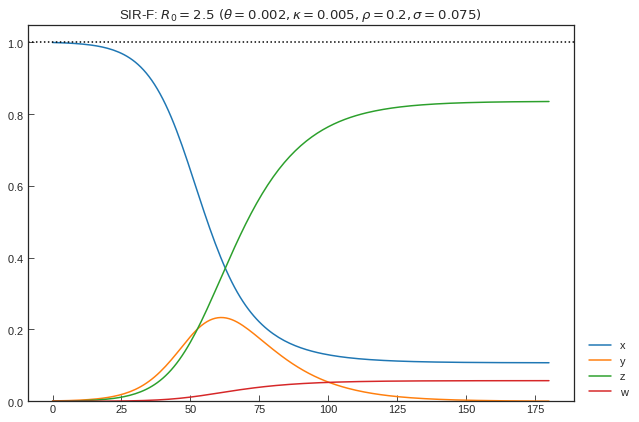

In [ ]:
line_plot(
    eg_df.set_index("t"),
    title=r"SIR-F: $R_0={0}\ (\theta={1}, \kappa={2}, \rho={3}, \sigma={4})$".format(
        eg_r0, eg_theta, eg_kappa, eg_rho, eg_sigma
    ),
    ylabel="",
    h=1
)

There is an inflection point of y (the number of currentry infected cases per total population). At this point, value of x (the number of susceptible cases per total population) is nearly equal to $\frac{1}{R_0}$.

In [ ]:
x_max = eg_df.loc[eg_df["y"].idxmax(), "x"]
(x_max, 1/eg_r0)

(0.40047837663671526, 0.4)

### Dimensionalization
Here, we will dimensionalize the data, assuming that start date is the first date of JHU dataset, $\tau=1440$ [min] and total population $N=1,000,000$.

In [ ]:
eg_tau = 1440
eg_start_date = ncov_df["Date"].min()
eg_total_population = 1_000_000
print(f"The start date is {eg_start_date.strftime('%d%b%Y')}.")

The start date is 22Jan2020.


In [ ]:
eg_ori_df = pd.DataFrame(
    {
        "Date": (eg_df["t"] * eg_tau).apply(lambda x: timedelta(minutes=x)) + eg_start_date,
        "Group": "Stopping",
        "Country": "Example",
        "Province": "-",
        "Susceptible": 0,
        "Confirmed": 0,
        "Infected": (eg_df["y"] * eg_total_population).astype(np.int64)
    }
)
eg_ori_df["Recovered"] = (eg_df["z"] * eg_total_population).astype(np.int64)
eg_ori_df["Fatal"] = (eg_df["w"] * eg_total_population).astype(np.int64)
eg_ori_df["Confirmed"] = eg_ori_df[["Infected", "Recovered", "Fatal"]].sum(axis=1)
eg_ori_df["Susceptible"] = eg_total_population - eg_ori_df["Confirmed"]
eg_ori_df.tail()

Date     Group  Country  ... Infected  Recovered  Fatal
176 2020-07-16  Stopping  Example  ...      670     834520  57417
177 2020-07-17  Stopping  Example  ...      632     834569  57421
178 2020-07-18  Stopping  Example  ...      596     834615  57424
179 2020-07-19  Stopping  Example  ...      562     834658  57427
180 2020-07-20  Stopping  Example  ...      530     834699  57429

[5 rows x 9 columns]

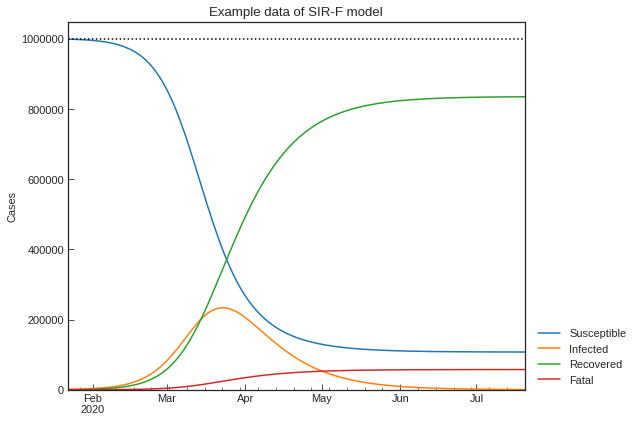

In [ ]:
line_plot(
    eg_ori_df.set_index("Date")[["Susceptible", "Infected", "Recovered", "Fatal"]],
    "Example data of SIR-F model",
    h=eg_total_population,
    y_integer=True
)

### Hyperparameter optimization
In the previous paragraphs figures, we calculated the number of cases based on hypothesized parameter values. However, we do not know parameter values of the actual data. Here, we will estimate the ($\theta, \kappa, \rho, \sigma$) values of the example data using hyperparameter optimization method by Optuna package. $\tau$ will be fixed as 1440 [min]. "Estimator" class was defined in Preparation part.

In [ ]:
%%time
sirf_estimator = Estimator(
    # We can replace SIRF with SIR or SIRD
    SIRF, eg_ori_df, eg_total_population,
    name="Example", places=[("Example", None)],
    tau=eg_tau
)
sirf_dict = sirf_estimator.run(500)

CPU times: user 1min 41s, sys: 3.27 s, total: 1min 44s
Wall time: 1min 39s


Trajectorie of parameter values in hyperparameter estimation are shown here.

In [ ]:
sirf_estimator.history_df().head()

KeyError: ignored

In [ ]:
sirf_estimator.history_graph()

KeyError: ignored

Estimated parameter values are shown here.

In [ ]:
_model = SIRF(theta=eg_theta, kappa=eg_kappa, rho=eg_rho, sigma=eg_sigma)
pd.DataFrame.from_dict(
    {
        "Setting": {
            "theta": eg_theta,
            "kappa": eg_kappa,
            "rho": eg_rho,
            "sigma": eg_sigma,
            "tau": eg_tau,
            "R0": eg_r0,
            "score": np.nan,
            **_model.calc_days_dict(tau=eg_tau)
        },
        "Estimated": sirf_dict
    },
    orient="index"
).fillna("-")

theta     kappa  ...  1/beta [day]  1/gamma [day]
Setting    0.00200  0.005000  ...             5             13
Estimated  0.03174  0.002934  ...             4             13

[2 rows x 11 columns]

Note:  
"Score" is Root Mean Squared Log Error (RMSLE) score.
\begin{align*}
& \sqrt{\cfrac{1}{n}\sum_{i=1}^{n}(log_{10}(A_{i} + 1) - log_{10}(P_{i} + 1))^2}
\end{align*}
Where $A$ is observed (actual) values, $P$ is estimated (predicted) values. Variables are $S$ ($i=1$), $I$ ($i=2$), $R$ ($i=3$) and $F$ ($i=n=4$) for SIR-F model. When RMSLE socre is low, hyperparameter estimation is highly accurate.  
Please refer to [What’s the Difference Between RMSE and RMSLE?](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a)

Comparison of observed values and estimated values is shown here.

Note:  
This figures show the accuracy for each parameter. When "v_observed" and "v_estimated" (v=y, z, w) is overlapping, highly accurate.

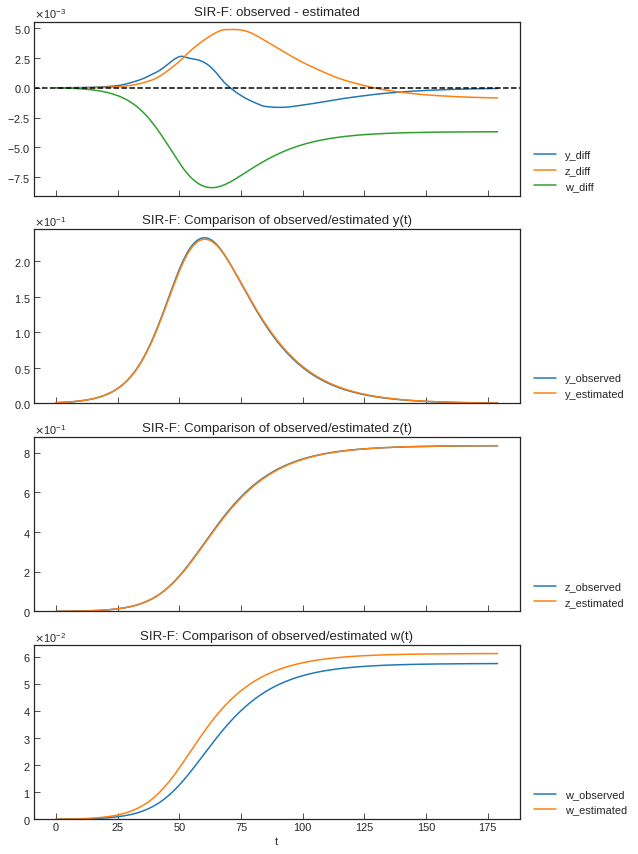

In [ ]:
sirf_estimator.compare_graph()

With the estimated the parameters, we can predict the number of cases. Vertical broken line indicates today.

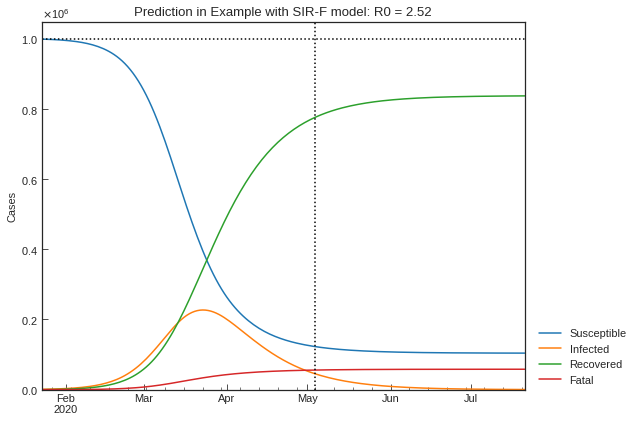

In [ ]:
sirf_estimator.predict_graph(step_n=180)

# SIR-F with exposed/waiting cases<a id="5"></a>
The number of exposed cases in latent period (E) and wating cases for confirmation (W) are un-measurable variables, but key variables as well as S, I, R, F. If E and W are large, outbreak will occur in the near future. Let's replace S $\overset{\beta I}{\longrightarrow}$ S$^\ast$ with S $\overset{\beta_1 (W+I)}{\longrightarrow}$ E $\overset{\beta_2}{\longrightarrow}$ W $\overset{\beta_3}{\longrightarrow}$ S$^\ast$ because W also has infectivity.

Note:  
W and some rules were added to explain COVID-19 dataset, but this is like-SEIR model.  
To study general SEIR-model, please refer to PDF material in [Introduction to SEIR model Models](http://indico.ictp.it/event/7960/session/3/contribution/19/material/slides/).

## What is SEWIR-F model?
* S: Susceptible
* <u>E: Exposed and in latent period (without infectivity)</u>
* <u>W: Waiting cases for confirmation (with infectivity)</u>
* S$^\ast$: Confirmed and un-categorized
* I: Confirmed and categorized as I
* R: Recovered
* F: Fatal with confirmation

Measurable variables:  
Total population - Confirmed = $S+E+W+S^\ast$  
Confirmed = $I+R+F$  
Recovered = $R$  
Deaths = $F$  

Model:  
\begin{align*}
\mathrm{S} \overset{\beta_1 (W+I)}{\longrightarrow} \mathrm{E} \overset{\beta_2}{\longrightarrow} \mathrm{W} \overset{\beta_3}{\longrightarrow} \mathrm{S}^\ast \overset{\alpha_1}{\longrightarrow}\ & \mathrm{F}    \\
\mathrm{S}^\ast \overset{1 - \alpha_1}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}    \\
& \mathrm{I} \overset{\alpha_2}{\longrightarrow} \mathrm{F}    \\
\end{align*}

$\alpha_1$: Mortality rate of S$^\ast$ cases [-]  
$\alpha_2$: Mortality rate of I cases [1/min]  
$\beta_1$: <u>Exposure rate (the number of encounter with the virus in a minute)</u> [1/min]  
$\beta_2$: <u>Inverse of latent period</u> [1/min]  
$\beta_3$: <u>Inverse of waiting time for confirmation</u> [1/min]  
$\gamma$: Recovery rate [1/min]  

Ordinary Differential Equation (ODE):   
\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta_1 S (W + I)  \\
& \frac{\mathrm{d}E}{\mathrm{d}T}= N^{-1}\beta_1 S (W + I) - \beta_2 E  \\
& \frac{\mathrm{d}W}{\mathrm{d}T}= \beta_2 E - \beta_3 W  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= (1 - \alpha_1)\beta_3 W - (\gamma + \alpha_2) I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
& \frac{\mathrm{d}F}{\mathrm{d}T}= N^{-1}\alpha_1 \beta_3 W + \alpha_2 I  \\
\end{align*}

Where $N=S+E+W+I+R+F$ is the total population, $T$ is the elapsed time from the start date.

## Non-dimensional SEWIR-F model
Set $(S, E, W, I, R, F) = N \times (x_1, x_2, x_3, y, z, w)$, $(T, \alpha_1) = (\tau t, \theta)$ and $(\alpha_2, \beta_i, \gamma) = \tau^{-1} \times (\kappa, \rho_i, \sigma)$.  
This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x_1}{\mathrm{d}t}= - \rho_1 x_1 (x_3 + y)  \\
& \frac{\mathrm{d}x_2}{\mathrm{d}t}= \rho_1 x_1 (x_3 + y) - \rho_2 x_2  \\
& \frac{\mathrm{d}x_3}{\mathrm{d}t}= \rho_2 x_2 - \rho_3 x_3  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= (1-\theta) \rho_3 x_3 - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \theta \rho_3 x_3 + \kappa y  \\
\end{align*}

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
\begin{align*}
0 < (x_i, y, z, w, \theta, \kappa, \rho_i, \sigma) < 1\ \mathrm{for}\ i = 1, 2, 3
\end{align*}
\begin{align*}
1 \leq \tau \leq 1440
\end{align*}

Reproduction number can be defined as  
\begin{align*}
R_0 = \rho_1 (1-\theta) (\sigma + \kappa)^{-1}
\end{align*}

## Calculate $\rho_2$ and $\rho_3$
To estimate $\rho_2 = \tau \beta_2$ and $\rho_3 = \tau \beta_3$ of COVID-19, we first calculate median value of latent period $\overline{L_{E}}$ and waiting time for confirmation $\overline{L_{W}}$ using linelist. We assume that patients start to have infectivity from onset dates. This means latent period is equal to incubation period.

$\beta_2$: Inverse of latent period [1/min]  
$\beta_3$: Inverse of waiting time for confirmation [1/min]

In [ ]:
period_df = select_area(linelist_df, group=None)
period_df = period_df.loc[:, ["Exposed_date", "Onset_date", "Confirmed_date"]]
period_df["Latent [min]"] = (period_df["Onset_date"] - period_df["Exposed_date"]).dt.total_seconds() / 60
period_df["Waiting [min]"] = (period_df["Confirmed_date"] - period_df["Onset_date"]).dt.total_seconds() / 60
period_df["Latent [day]"] = period_df["Latent [min]"] / 60 / 24
period_df["Waiting [day]"] = period_df["Waiting [min]"] / 60 / 24
period_df["Latent + Waiting [day]"] = period_df["Latent [day]"] + period_df["Waiting [day]"]
period_df.dropna(axis=0).tail()

Exposed_date Onset_date  ... Waiting [day]  Latent + Waiting [day]
948    2020-01-25 2020-02-24  ...           0.0                    30.0
949    2020-01-25 2020-02-04  ...          20.0                    30.0
957    2020-01-25 2020-02-12  ...          14.0                    32.0
958    2020-01-25 2020-02-17  ...           9.0                    32.0
1084   2020-02-15 2020-02-17  ...           8.0                    10.0

[5 rows x 8 columns]

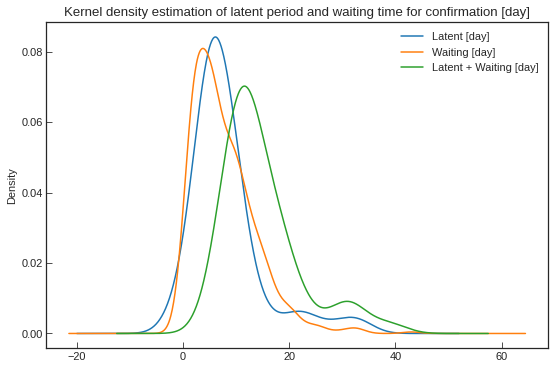

count       mean       std  min   25%   50%   75%   max
Latent [day]             83.0   8.180723  6.786185 -2.0   4.0   6.0   9.0  34.0
Waiting [day]           563.0   7.682060  5.890473  0.0   3.0   6.0  11.0  43.0
Latent + Waiting [day]   83.0  14.819277  7.305435  5.0  10.0  13.0  17.5  40.0

In [ ]:
cols = ["Latent [day]", "Waiting [day]", "Latent + Waiting [day]"]
period_df[cols].plot.kde()
plt.title("Kernel density estimation of latent period and waiting time for confirmation [day]")
plt.show()
period_df[cols].describe().T

In [ ]:
latent_period = period_df["Latent [min]"].median()
waiting_time = period_df["Waiting [min]"].median()
latent_waiting_day = period_df["Latent + Waiting [day]"].median()

In [ ]:
tau = sirf_estimator.info()[1]["tau"]
eg_rho2, eg_rho3 = tau / latent_period, tau / waiting_time
(eg_rho2, eg_rho3)

(0.16666666666666663, 0.16666666666666663)

### Example of non-dimensional SEWIR-F model
For example, set $\theta=0.002, \kappa=0.005, \rho_1=0.2, \sigma=0.08$ and initial values $(x_{1(0)}, x_{2(0)}, x_{3(0)}, y_{(0)}, z_{(0)}, w_{(0)}) = (0.994, 0.003, 0.002, 0.001, 0, 0)$.

In [ ]:
eg_theta, eg_kappa, eg_rho1, eg_sigma = (0.002, 0.005, 0.2, 0.08)
eg_initials = (0.994, 0.003, 0.002, 0.001, 0, 0)

In [ ]:
%%time
eg_df = simulation(
    SEWIRF, eg_initials, step_n=180,
    theta=eg_theta, kappa=eg_kappa, rho1=eg_rho1, rho2=eg_rho2, rho3=eg_rho3, sigma=eg_sigma)
eg_df.tail()

CPU times: user 11.5 ms, sys: 1e+03 µs, total: 12.5 ms
Wall time: 18.9 ms


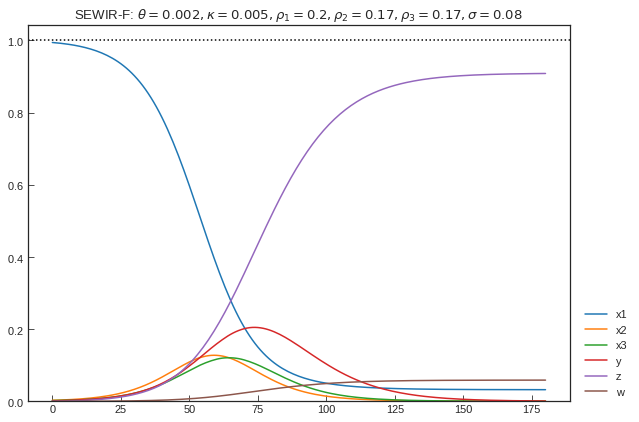

In [ ]:
line_plot(
    eg_df.set_index("t"),
    title=r"SEWIR-F: $\theta={0}, \kappa={1}, \rho_1={2}, \rho_2={3}, \rho_3={4}, \sigma={5}$".format(
        eg_theta, eg_kappa, eg_rho1, round(eg_rho2, 2), round(eg_rho3, 2), eg_sigma
    ),
    ylabel="",
    h=1
)

### Dimensionalization
Here, we will dimensionalize the data, assuming that start date is the first date of JHU dataset, $\tau=1440$ [min] and total population $N=1,000,000$.

In [ ]:
eg_tau = 1440
eg_start_date = ncov_df["Date"].min()
eg_total_population = 1_000_000
print(f"The start date is {eg_start_date.strftime('%d%b%Y')}.")

The start date is 22Jan2020.


In [ ]:
eg_ori_df = pd.DataFrame(
    {
        "Date": (eg_df["t"] * eg_tau).apply(lambda x: timedelta(minutes=x)) + eg_start_date,
        "Group": "Stopping",
        "Country": "Example",
        "Province": "-",
        "Susceptible": (eg_df["x1"] * eg_total_population).astype(np.int64),
        "Exposed": (eg_df["x2"] * eg_total_population).astype(np.int64),
        "Waiting": (eg_df["x3"] * eg_total_population).astype(np.int64),
        "Confirmed": 0,
        "Infected": (eg_df["y"] * eg_total_population).astype(np.int64)
    }
)
eg_ori_df["Recovered"] = (eg_df["z"] * eg_total_population).astype(np.int64)
eg_ori_df["Fatal"] = (eg_df["w"] * eg_total_population).astype(np.int64)
eg_ori_df["Confirmed"] = eg_ori_df[["Infected", "Recovered", "Fatal"]].sum(axis=1)
eg_ori_df.tail()

Date     Group  Country  ... Infected  Recovered  Fatal
176 2020-07-16  Stopping  Example  ...     1024     907905  58677
177 2020-07-17  Stopping  Example  ...      959     907984  58682
178 2020-07-18  Stopping  Example  ...      898     908058  58686
179 2020-07-19  Stopping  Example  ...      841     908128  58691
180 2020-07-20  Stopping  Example  ...      788     908193  58695

[5 rows x 11 columns]

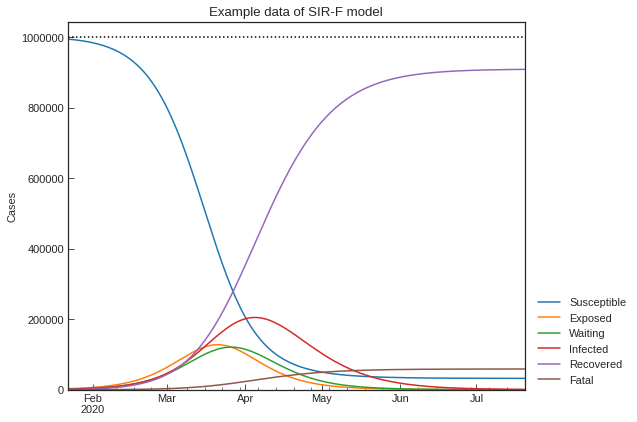

In [ ]:
cols = ["Susceptible", "Exposed", "Waiting", "Infected", "Recovered", "Fatal"]
line_plot(
    eg_ori_df.set_index("Date")[cols],
    "Example data of SIR-F model",
    h=eg_total_population,
    y_integer=True
)

# Factors of model parameters<a id="6"></a>
To figure out what to do for minimizing the damage, we will perform scenario analysis in the next part. In this section, we will define the control factors of the SIR-F parameters.

Comment:  
For accurate SEWIR-F prediction, we need to calculate $\rho_1$ and $\rho_2$ with linelist (case reports) of each country. However, it is difficult to get enough data for all countries and we will use SIR-F model as the main model in scenario analysis part.

## Control factors of effective contact rate $\beta_1$
Please reconsider S $\overset{\beta_1 (W+I)}{\longrightarrow}$ E formula. Susceptible persons may contact with waiting/confirmed patients, and susceptible persons will be infected with COVID-19. The formura can be replaced with  
\begin{alignat}{1}
{\mathrm{S}}_{\mathrm{q}} & \overset{g_{s}}{\Longleftrightarrow} {\mathrm{S}}_{\mathrm{g}} \overset{f_1}
 {\longrightarrow} \ & \mathrm{E}^\ast \overset{e^{-h_2}}{\longrightarrow} \mathrm{E}   \\
& & \mathrm{E}^\ast \overset{1-e^{-h_2}}{\longrightarrow} \mathrm{R}^\ast  \\
\mathrm{W}_\mathrm{q} & \overset{g_w}{\Longleftrightarrow} \mathrm{W}_{\mathrm{g}}  \\
\mathrm{I}_\mathrm{q} & \overset{g_i}{\Longleftrightarrow} \mathrm{I}_{\mathrm{g}}  \\
\mathrm{I}_\mathrm{q} & \overset{q}{\longrightarrow} \mathrm{I}_{\hat{\mathrm{q}}}  \\
\end{alignat}

$\Longleftrightarrow$ (as substitute for $\longrightarrow$ with $\longleftarrow$) means that right side can be return to the left side.  
S$_\mathrm{q}$: Susceptible persons with self-quaranting <!--Susceptible in the strict sense-->  
S$_\mathrm{g}$: Susceptible persons with family members or friends etc.  
W$_\mathrm{q}$: Waiting patients with self-quaranting  
W$_\mathrm{g}$: Waiting patients with family members or friends etc.  
I$_\mathrm{q}$: Confimered and un-recovered patients with self-quaranting  
I$_\mathrm{g}$: Confimered and un-recovered patients with family members or friends etc.  
I$_\hat{\mathrm{q}}$: Confimered and un-recovered patients who was hospitalized  
E$^\ast$: Just after being exposed to the virus  
R$^\ast$: Being exposed to the virus, fighted with the virus, recovered and immuned without confirmation  

$f_1 = v(W_{\mathrm{g}} + I_{\mathrm{g}})(1-m)^2(1-w_e)^{w_n}e^{-h_1}sc$ [-] 

Control factors:  
$g_s$: The number of days in <u>a week</u> susceptible persons go out [day]  
$g_w$: The number of days in <u>a week</u> waiting but un-quarantined persons go out [day]  
$g_i$: The number of days in <u>a week</u> currently infected (confirmed) but un-quarantined persons go out [day]  
$q$: Quarantine rate of currently infected (confirmed) patients [-]  
$v$: Probability of virus existance in a droplet [-]  
$m$: Rate of persons wearing masks effectively (depends logistically on supply of masks) [-]  
$w_e$: Virus reduction effect of washing hands [-]  
$w_n$: The number of times people washes their hands before touching their own faces after go out [-]  
$h_1$: Health condition (active rate of cellular immunity factors) of susceptible and contacted persons [-]  
$h_2$: Health condition (active rate of humoral immunity factors) of susceptible and contacted persons [-]  
$c$: The number of contacts between susceptible persons and patients while on the go in a minute (depends on population density) [1/min]  
$\delta$:The product of unknown real factors [-]  

The parameter in the math model:  
$\beta_1 = \cfrac{1}{49}[g_s \{g_w + g_i (1-q) \} v (1-m)^2 (1-w_e)^{w_n} e^{-(h_{1}+h_{2})} c \delta]$ [1/min]

In [ ]:
# Value of beta before actions are taken
_, info_dict, param_dict = sirf_estimator.info()
beta_before = param_dict["rho"] / info_dict["tau"]
beta_before

0.00014341410020490695

**As a example, we will predict the impact of lockdown. The number of days in a week susceptible persons go out, $g_s$, will be minimized.**

### $g_s$ value before actions are taken
$g_s$: The number of days in <u>a week</u>, susceptible persons go out [day]  

We can calculate weighted average of days with age composion of population. Population pyramid in the entire world (global data) will be used.

In [ ]:
eg_out_df = go_out("Global")
eg_out_df

Age_first  Age_last     Period_of_life  School  Office  Others   Portion
0           0         2            nursery       3       0       0  0.052210
1           3         5     nursery school       4       0       1  0.051864
2           6        10  elementary school       5       0       1  0.084689
3          11        13      middle school       5       0       1  0.049386
4          14        18        high school       6       0       1  0.079324
5          19        25    university/work       3       3       1  0.107659
6          26        35               work       0       6       1  0.152774
7          36        45               work       0       5       1  0.131630
8          46        55               work       0       5       1  0.116396
9          56        65               work       0       5       1  0.088096
10         66        75            retired       0       0       4  0.055083
11         76        85            retired       0       0       3  0.024309
12         86        95            retired       0       0       2  0.006579

$g_s$ value is

In [ ]:
gs_before = (eg_out_df[["School", "Office", "Others"]].sum(axis=1) * eg_out_df["Portion"]).sum()
gs_before

5.921853248424339

### $g_s$ value AFTER actions are taken
We will assume the following situation (lockdown) here.
* All schools are closed
* offices are closed and 50% of people works remotely.
* People will go out one day for other reasons instead of going to school/office.

In [ ]:
df = eg_out_df.copy()
df.loc[df["School"] + df["Office"] > 0, "Others"] += 1
df["School"] = 0
df["Office"] *= 0.5
eg_out_df_after = df.copy()
eg_out_df_after

Age_first  Age_last     Period_of_life  School  Office  Others   Portion
0           0         2            nursery       0     0.0       1  0.052210
1           3         5     nursery school       0     0.0       2  0.051864
2           6        10  elementary school       0     0.0       2  0.084689
3          11        13      middle school       0     0.0       2  0.049386
4          14        18        high school       0     0.0       2  0.079324
5          19        25    university/work       0     1.5       2  0.107659
6          26        35               work       0     3.0       2  0.152774
7          36        45               work       0     2.5       2  0.131630
8          46        55               work       0     2.5       2  0.116396
9          56        65               work       0     2.5       2  0.088096
10         66        75            retired       0     0.0       4  0.055083
11         76        85            retired       0     0.0       3  0.024309
12         86        95            retired       0     0.0       2  0.006579

In [ ]:
df = eg_out_df_after.copy()
gs_after = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
gs_after

3.5423821085758442

## Impact of actions on $\beta$
In SIR-F model $g_s$ is a control factor of $\beta$.  
Actions taken at 15th day:  
All schools and offices will be closed.  

In [ ]:
beta_after = beta_before * (gs_after / gs_before)
beta_after / beta_before

0.5981880941609597

## Predict the number of cases: with actions from 15th day
There is a delay between the time point of starting actions and that of appearing the effect. Because $I$ is the main variable, the length of delay can be estimated as sum of latent period and waiting time for confirmation. This value [day] was calculated in "SIR-F with exposed/waiting cases" section.

In [ ]:
latent_waiting_day

13.0

In [ ]:
first_model, info_dict, param_dict = sirf_estimator.info()
info_dict["name"] = "Example"
lock_param_dict = param_dict.copy()
lock_param_dict["rho"] = param_dict["rho"] * beta_after / beta_before
df = pd.DataFrame.from_dict(
    {"No actions": param_dict, "Lockdown": lock_param_dict},
    orient="index"
)
df = df.loc[:, ["theta", "kappa", "rho", "sigma"]]
df["R0"] = df.apply(lambda x: first_model(**x.to_dict()).calc_r0(), axis=1)
df["tau"] = info_dict["tau"]
df

theta     kappa       rho     sigma    R0   tau
No actions  0.041696  0.001923  0.206516  0.076669  2.52  1440
Lockdown    0.041696  0.001923  0.123536  0.076669  1.51  1440

No actions:

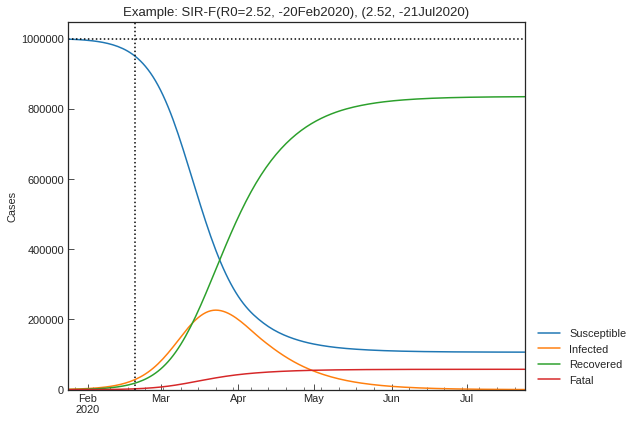

In [ ]:
predicter = Predicter(**info_dict)
predicter.add(SIRF, end_day_n=15, count_from_last=False, vline=False, **param_dict)
predicter.add(SIRF, end_day_n=latent_waiting_day, count_from_last=True, **param_dict)
predicter.add(SIRF, end_day_n=180, count_from_last=False, **param_dict)
predicter.restore_graph(drop_cols=None, y_integer=True)
pred_df_no = predicter.restore_df()

"Predicter" class was defined in Preparation part.

With lockdown from 15th day:

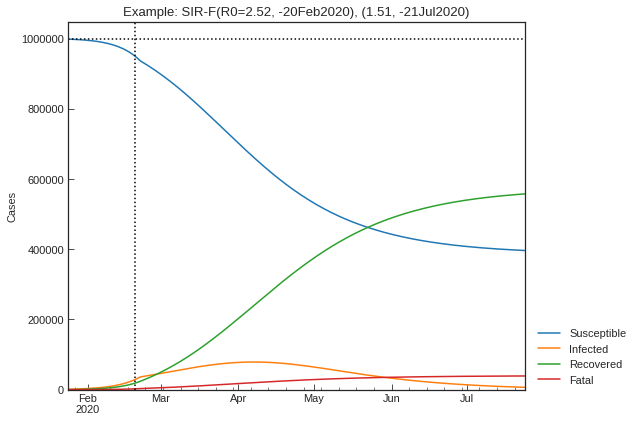

In [ ]:
predicter = Predicter(**info_dict)
predicter.add(SIRF, end_day_n=15, count_from_last=False, vline=False, **param_dict)
predicter.add(SIRF, end_day_n=latent_waiting_day, count_from_last=True, **param_dict)
predicter.add(SIRF, end_day_n=180, count_from_last=False, **lock_param_dict)
predicter.restore_graph(drop_cols=None, y_integer=True)
pred_df_lock = predicter.restore_df()

In [ ]:
pred_df_no.head()

Susceptible  Infected  Recovered  Fatal
Time                                               
2020-01-24       998543      1268        170     17
2020-01-25       998265      1428        273     31
2020-01-26       997952      1609        390     47
2020-01-27       997600      1812        521     65
2020-01-28       997204      2040        668     85

In [ ]:
_last_date = pred_df_no.index[-1].strftime("%d%b%Y")
_dict = {
    "No actions": {
        "max(Infected)": pred_df_no["Infected"].max(),
        "argmax(Infected)": pred_df_no["Infected"].idxmax(),
        f"Infected at {_last_date}": pred_df_no["Infected"][-1],
    },
    "With lockdown": {
        "max(Infected)": pred_df_lock["Infected"].max(),
        "argmax(Infected)": pred_df_lock["Infected"].idxmax(),
        f"Infected at {_last_date}": pred_df_lock["Infected"][-1],
    }   
}
pd.DataFrame.from_dict(_dict, orient="index")

max(Infected) argmax(Infected)  Infected at 24Jul2020
No actions            226601       2020-03-23                    460
With lockdown          78875       2020-04-07                   6780

The actions result in:  
* reduction of max value of Infected,
* delay of peak point (argmax) of Infected, and
* extention of period with COVID-19.

## Control factors of recovery rate $\gamma$ and mortality rate $\alpha_2$
Here, let's reconsider I $\overset{\gamma}{\longrightarrow}$ R and I $\overset{\alpha_2}{\longrightarrow}$ F.  
Because balance of immunity (+effect of treatments) and virulence determines whether patients can recover or not, the formulas can be replaced with  

\begin{align*}
& \mathrm{I} \overset{\bar{h}}{\longrightarrow} \mathrm{I}^\star \overset{\bar{s}}{\longrightarrow} \mathrm{F}^\star \overset{L^{-1}}{\longrightarrow} \mathrm{F}    \\
& \mathrm{I} \overset{f_2}{\longrightarrow} \mathrm{R}^\star \overset{l^{-1}}{\longrightarrow} \mathrm{R}    \\
\end{align*}

I$^\star$: Confirmed cases whose immune systems did not overcome virus multiplication, and <u>without</u> severe events  
F$^\star$: Confirmed cases whose immune systems did not overcome virus multiplication, and <u>with</u> severe events  
R$^\star$: Confirmed cases whose immune systems overcame virus multiplication or comfirmed cases whose severe events can be stopped

$f_2 = 1 - \bar{h}\ \bar{s}$  

$\bar{h}$: Rate of I whose immune systems does NOT overcame virus multiplication [-]  
$\bar{s}$: Rate of I$^\star$ who have severe events, including respiratory failure  [-]  
$L_i$: Inverse of F$^\star$'s mortality rate for people $i$ years old [min]  
$l_i$: Inverse of R$^\star$'s mortality rate for people $i$ years old [min]  
$P_i$: The number of people $i$ years old [-]  
$N$: Total population  

\begin{align*}
& \alpha_2 = \cfrac{\bar{h}\ \bar{s}}{N} \sum_{n=0}^{\infty}\cfrac{P_{i}}{L_i} \\
& \gamma = \cfrac{1 - \bar{h}\ \bar{s}}{N} \sum_{n=0}^{\infty}\cfrac{P_{i}}{l_i} \\
\end{align*}

## $\bar{h}$ and $\bar{s}$ value before actions are taken
We assume that $\bar{h}=0.5$ and $\bar{s}=0.5$.  
**(Using population distribution data and case reports, $\bar{h}\ \bar{s}$ and $1 - \bar{h}\ \bar{s}$ can be calculated.)**

In [ ]:
gamma_before = param_dict["sigma"] / info_dict["tau"]
alpha2_before = param_dict["kappa"] / info_dict["tau"]
(gamma_before, alpha2_before)

(5.324243942157617e-05, 1.3355392050690224e-06)

In [ ]:
h_bar_before, s_bar_before = 0.5, 0.5

## $\bar{h}$ and $\bar{s}$ value AFTER actions are taken
Assumtions of new medicines:  
"Protease inhibitor" inhibits virus multiplication. This will reduce $\bar{h}$. We assume that $\bar{h}$ will be 10% of $\bar{h}_{before}$.

In [ ]:
h_bar_after = h_bar_before * 0.1
s_bar_after = s_bar_before
(h_bar_after, s_bar_after)

(0.05, 0.5)

## Impact on $\gamma$ and $\alpha_2$
Actions to take:  
New Protein inhibitor medicine was introduced.

In [ ]:
gamma_after = gamma_before * (1 - h_bar_after * s_bar_after) / (1 - h_bar_before * s_bar_before)
gamma_after

6.921517124804902e-05

In [ ]:
alpha2_after = alpha2_before * (h_bar_after * s_bar_after) / (h_bar_before * s_bar_before)
alpha2_after

1.3355392050690224e-07

## Predict the number of case: with new medicines from 15th day

In [ ]:
first_model, info_dict, param_dict = sirf_estimator.info()
info_dict["name"] = "Example"
med_param_dict = param_dict.copy()
med_param_dict["sigma"] = param_dict["sigma"] * gamma_after / gamma_before
med_param_dict["kappa"] = param_dict["kappa"] * alpha2_after / alpha2_before
df = pd.DataFrame.from_dict(
    {"No actions": param_dict, "Medicines": med_param_dict},
    orient="index"
)
df = df.loc[:, ["theta", "kappa", "rho", "sigma"]]
df["R0"] = df.apply(lambda x: first_model(**x.to_dict()).calc_r0(), axis=1)
df["tau"] = info_dict["tau"]
df

theta     kappa       rho     sigma    R0   tau
No actions  0.041696  0.001923  0.206516  0.076669  2.52  1440
Medicines   0.041696  0.000192  0.206516  0.099670  1.98  1440

No actions:

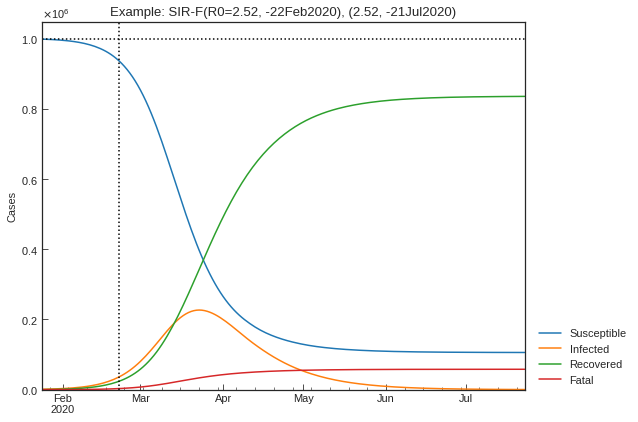

In [ ]:
predicter = Predicter(**info_dict)
predicter.add(SIRF, end_day_n=30, count_from_last=False, vline=True, **param_dict)
predicter.add(SIRF, end_day_n=180, count_from_last=False, **param_dict)
predicter.restore_graph(drop_cols=None)
pred_df_no = predicter.restore_df()

With new medicines:

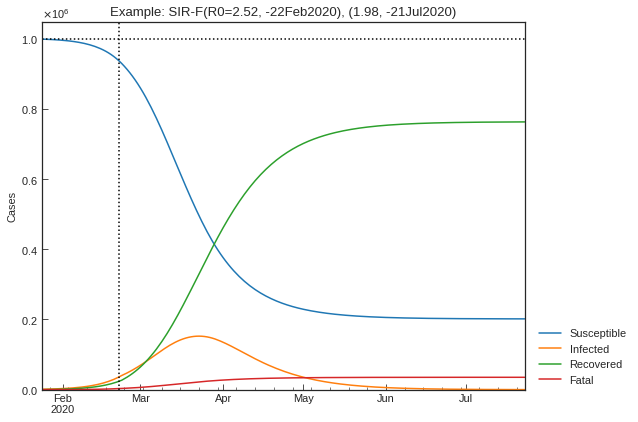

In [ ]:
predicter = Predicter(**info_dict)
predicter.add(SIRF, end_day_n=30, count_from_last=False, vline=True, **param_dict)
predicter.add(SIRF, end_day_n=180, count_from_last=False, **med_param_dict)
predicter.restore_graph(drop_cols=None)
pred_df_med = predicter.restore_df()

In [ ]:
_last_date = pred_df_no.index[-1].strftime("%d%b%Y")
_dict = {
    "No actions": {
        "max(Infected)": pred_df_no["Infected"].max(),
        "argmax(Infected)": pred_df_no["Infected"].idxmax(),
        f"Infected at {_last_date}": pred_df_no["Infected"][-1],
        f"Fatal at {_last_date}": pred_df_no["Fatal"][-1],
    },
    "Lockdown": {
        "max(Infected)": pred_df_lock["Infected"].max(),
        "argmax(Infected)": pred_df_lock["Infected"].idxmax(),
        f"Infected at {_last_date}": pred_df_lock["Infected"][-1],
        f"Fatal at {_last_date}": pred_df_lock["Fatal"][-1],
    },
    "Medicine": {
        "max(Infected)": pred_df_med["Infected"].max(),
        "argmax(Infected)": pred_df_med["Infected"].idxmax(),
        f"Infected at {_last_date}": pred_df_med["Infected"][-1],
        f"Fatal at {_last_date}": pred_df_med["Fatal"][-1],
    }
}
pd.DataFrame.from_dict(_dict, orient="index")

max(Infected) argmax(Infected)  Infected at 23Jul2020  \
No actions         226874       2020-03-23                    481   
Lockdown            78875       2020-04-07                   6780   
Medicine           152521       2020-03-23                    270   

            Fatal at 23Jul2020  
No actions               58183  
Lockdown                 39105  
Medicine                 35334

New medicines result in:  
* reduction of max value of Infected,
* reduction of Fatal, and
* shortened period with COVID-19.

## If 1,000/day are vaccinated (SIR-FV model) from 15th day
We will predict the numbers of cases in the assumption that 10,000 persons will be vacctinated in one day until there are no susceptible people.  

\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y - \omega  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho (1-\theta) x y - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \rho \theta x y + \kappa y  \\
\end{align*}

Where $\omega_{(x>0)}=\frac{1,000}{N}$ and $N$ is the total population.

Reproduction number can be defined as  
\begin{align*}
R_0 = \rho (1 - \theta) (\sigma + \kappa)^{-1}
\end{align*}

In [ ]:
print(f"Total population is {eg_total_population:,}.")

Total population is 1,000,000.


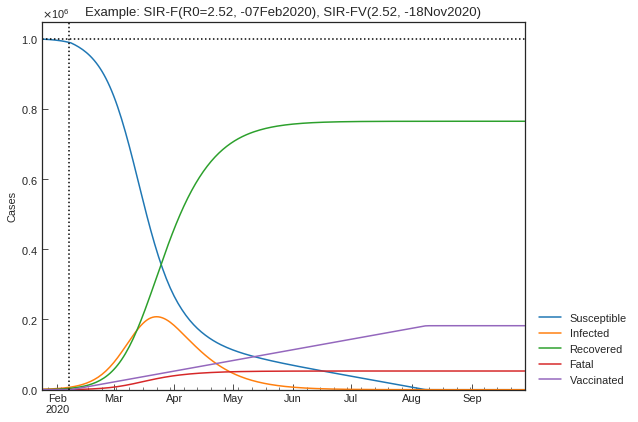

In [ ]:
first_model, info_dict, param_dict = sirf_estimator.info()
vac_param_dict = param_dict.copy()
vac_param_dict["n"] = eg_total_population
vac_param_dict["v_per_day"] = 1_000
predicter = Predicter(**info_dict)
predicter.add(SIRF, end_day_n=15, count_from_last=False, **param_dict)
predicter.add(SIRFV, end_day_n=300, count_from_last=False, **vac_param_dict)
predicter.restore_graph(drop_cols=None)
pred_df_vac = predicter.restore_df()

In [ ]:
_last_date = pred_df_no.index[-1].strftime("%d%b%Y")
_dict = {
    "No actions": {
        "max(Infected)": pred_df_no["Infected"].max(),
        "argmax(Infected)": pred_df_no["Infected"].idxmax(),
        f"Infected at {_last_date}": pred_df_no["Infected"][-1],
        f"Fatal at {_last_date}": pred_df_no["Fatal"][-1],
    },
    "Lockdown": {
        "max(Infected)": pred_df_lock["Infected"].max(),
        "argmax(Infected)": pred_df_lock["Infected"].idxmax(),
        f"Infected at {_last_date}": pred_df_lock["Infected"][-1],
        f"Fatal at {_last_date}": pred_df_lock["Fatal"][-1],
    },
    "Medicine": {
        "max(Infected)": pred_df_med["Infected"].max(),
        "argmax(Infected)": pred_df_med["Infected"].idxmax(),
        f"Infected at {_last_date}": pred_df_med["Infected"][-1],
        f"Fatal at {_last_date}": pred_df_med["Fatal"][-1],
    },
    "Vacctine": {
        "max(Infected)": pred_df_vac["Infected"].max(),
        "argmax(Infected)": pred_df_vac["Infected"].idxmax(),
        f"Infected at {_last_date}": pred_df_vac["Infected"][-1],
        f"Fatal at {_last_date}": pred_df_vac["Fatal"][-1],
    }
}
pd.DataFrame.from_dict(_dict, orient="index")

max(Infected) argmax(Infected)  Infected at 23Jul2020  \
No actions         226874       2020-03-23                    481   
Lockdown            78875       2020-04-07                   6780   
Medicine           152521       2020-03-23                    270   
Vacctine           207798       2020-03-23                      1   

            Fatal at 23Jul2020  
No actions               58183  
Lockdown                 39105  
Medicine                 35334  
Vacctine                 53227

Vacctines result in:  
* reduction of max value of Infected,
* reduction of Fatal, and
* shortened period with COVID-19.

# S-R trend analysis<a id="10"></a>
In the previous section, we found that parameter values can be changed by actions. To predict the future, we need to recognize the parameter change from the actual records. Here, trend analysis method will be introduced.

## Example datasets
With the same initial values $(x_{(0)}, y_{(0)}, z_{(0)}, w_{(0)})=(0.999, 0.001, 0, 0)$, we will create five SIR-F example datasets.
* Example 1: $(\theta, \kappa, \rho, \sigma) = (0.0002, 0.005, 0.20, 0.075)$
* Example 2: $(\theta, \kappa, \rho, \sigma) = (0.0002, 0.005, \underline{0.40}, 0.075)$, spread quickly
* Example 3: $(\theta, \kappa, \rho, \sigma) = (0.0002, 0.005, \underline{0.15}, 0.075)$, spread slowly
* Example 4: $(\theta, \kappa, \rho, \sigma) = (0.0002, \underline{0.003}, 0.20, \underline{0.150})$, improved heakthcare system
* Example 5: $(\theta, \kappa, \rho, \sigma) = (\underline{0.0000}, 0.005, 0.20, 0.075)$, as the same as SIR-D model

Values are dimensionalized with total population $N=1,000,000$ in the example datasets.

In [ ]:
df = pd.DataFrame()
eg_initials = (0.999, 0.001, 0, 0)
eg_total_population = 1_000_000
eg_step_n = 200
eg_param_dict = {
    "1": {"theta": 0.0002, "kappa": 0.005, "rho": 0.20, "sigma": 0.075},
    "2": {"theta": 0.0002, "kappa": 0.005, "rho": 0.40, "sigma": 0.075},
    "3": {"theta": 0.0002, "kappa": 0.005, "rho": 0.15, "sigma": 0.075},
    "4": {"theta": 0.0002, "kappa": 0.003, "rho": 0.20, "sigma": 0.150},
    "5": {"theta": 0.0000, "kappa": 0.005, "rho": 0.20, "sigma": 0.075},
}

for (num, _dict) in eg_param_dict.items():
    _df = simulation(SIRF, eg_initials, step_n=eg_step_n, **_dict)
    _df = (_df.set_index("t") * eg_total_population).astype(np.int64)
    _df = _df.reset_index()
    _df["Country"] = f"Example {num}"
    df = pd.concat([df, _df], axis=0, ignore_index=True)

df["Date"] = ncov_df["Date"].min() + pd.Series(df["t"]).apply(lambda x: timedelta(days=x))
df["Group"] = "Stopping"
df["Province"] = "-"
df = df.rename({"y": "Infected", "z": "Recovered", "w": "Deaths"}, axis=1)
df["Confirmed"] = df[["Infected", "Recovered", "Deaths"]].sum(axis=1)
df = df.loc[:, ncov_df.columns]
eg_ncov_df = df.copy()
eg_ncov_df.tail()

Date     Group    Country Province  Confirmed  Infected  Deaths  \
1000 2020-08-05  Stopping  Example 5        -     893535       204   55833   
1001 2020-08-06  Stopping  Example 5        -     893540       193   55834   
1002 2020-08-07  Stopping  Example 5        -     893544       182   55835   
1003 2020-08-08  Stopping  Example 5        -     893547       171   55836   
1004 2020-08-09  Stopping  Example 5        -     893550       161   55836   

      Recovered  
1000     837498  
1001     837513  
1002     837527  
1003     837540  
1004     837553

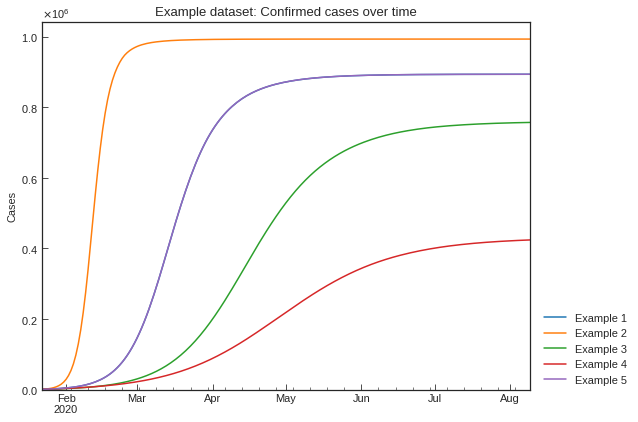

In [ ]:
line_plot(
    eg_ncov_df.pivot_table(index="Date", columns="Country", values="Confirmed"),
    "Example dataset: Confirmed cases over time"
)

Values of Example 1 $(\kappa=0.002)$ are nealy equal to that of Example 5 $(\kappa=0.000)$ as shown in the next figure.

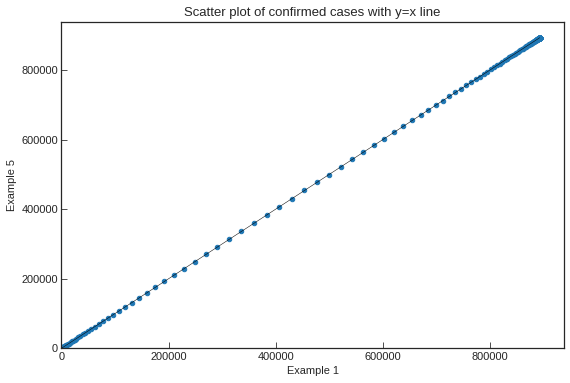

In [ ]:
df = eg_ncov_df.pivot_table(index="Date", columns="Country", values="Confirmed")
df.plot.scatter(x="Example 1", y="Example 5")
plt.plot(df["Example 1"], df["Example 1"], color="black", linewidth=0.5)
plt.xlim(0, None)
plt.ylim(0, None)
plt.title("Scatter plot of confirmed cases with y=x line")
plt.show()

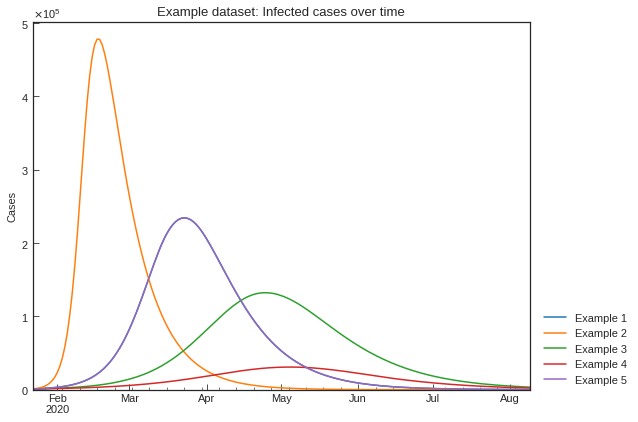

In [ ]:
line_plot(
    eg_ncov_df.pivot_table(index="Date", columns="Country", values="Infected"),
    "Example dataset: Infected cases over time"
)

Note: This seems Gamma distribution curve.
\begin{align*}
f(x>0) & = \cfrac{\lambda^{k}}{\Gamma(k)} x^{k-1} e^{-\lambda x}  \\
\Gamma(k) & = \int_{0}^{\infty} t^{k-1} e^{-t} dt
\end{align*}

Curve fitting with Gamma distribution curve is done by Bill Holst. Please find the URLs in ["Acknowledgement" subsection](#3).

## $\Delta$Confirmed vs. Confirmed in log-log plot
The numer of new confirmed cases $\Delta C$ can be desribed as,
\begin{align*}
\Delta C=N^{-1}\beta (N - C) I
\end{align*}
This is because $C=I+R+F$ and $S=N-C$ in SIR-F model.

$t$ is a measurable variable, but this is just an intermediate variable. $\Delta C$ is determined by cummurative number of cases.

In addition, $I$ is determined by $C$ when the parameters $(\alpha_1, \alpha_2, \beta, \gamma)$ are fixed.  
Then,
$$\Delta C = f(C)$$

Plots of $(x, y) = (C, \Delta C)$ in log-log scale are shown in the next figure.  

Note:  
This idea is from [YouTube: How To Tell If We're Beating COVID-19](https://www.youtube.com/watch?v=54XLXg4fYsc). SIR-type models are not mentioned in this video, but we can link the idea with SIR-F model as above.

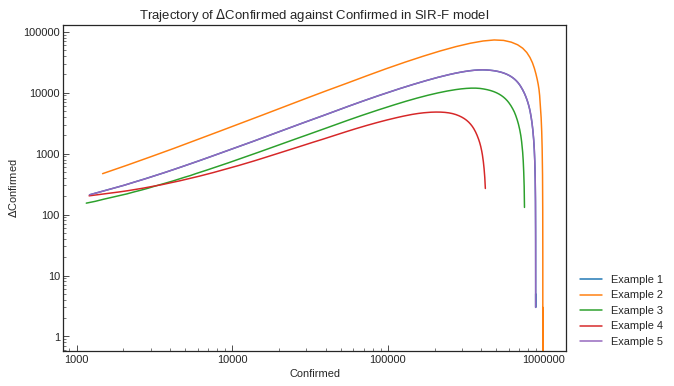

In [ ]:
for country in eg_ncov_df["Country"].unique():
    df = eg_ncov_df.copy()
    df = df.loc[df["Country"] == country, :]
    df = df.groupby("Date").last()
    plt.plot(df["Confirmed"], df["Confirmed"].diff(), label=country)

plt.title(r"Trajectory of $\Delta$Confirmed against Confirmed in SIR-F model")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Confirmed")
plt.ylabel(r"$\Delta$Confirmed")
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().xaxis.set_major_formatter(fmt)
plt.gca().yaxis.set_major_formatter(fmt)
plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
plt.show()

Nete: Because $C(t)$ is a cummurative number, $C(t+\Delta t) \geq C(t)$ for all $t$ and $\Delta t > 0$.

## argmax($\Delta C$) in $(x, y) = (t, C(t))$ plot
What can we know from $(C, \Delta C)$ plot? Here, we will discuss max value of $\Delta C$.

When $\Delta C$ shows max value of $\Delta C$ in "Example 5" dataset (equal to SIR-D model), $t$ and $C(t)$ is

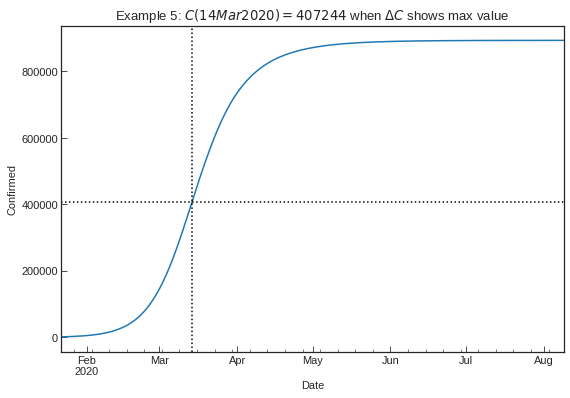

In [ ]:
country = "Example 5"
df = eg_ncov_df.copy()
df = df.loc[df["Country"] == country, :].groupby("Date").last()
arg_tt = df["Confirmed"].diff().idxmax()
arg_cc = df.loc[arg_tt, "Confirmed"]
# Plot
df["Confirmed"].plot()
plt.axhline(y=arg_cc, color="black", linestyle=":")
plt.axvline(x=arg_tt, color="black", linestyle=":")
plt.ylabel("Confirmed")
plt.title(
    r'{0}: $C({1})={2}$ when $\Delta C$ shows max value'.format(
        country, arg_tt.strftime("%d%b%Y"), arg_cc)
)
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(fmt)
plt.show()

## Curve fitting of $C(t)$
$C(t)$ is sometimes described by logistic function and Gompertz function.

\begin{align*}
\mathrm{Logistic\ function:\ } g(t) & = \cfrac{N}{1 + A e^{-Bt}}  \\
\mathrm{Gompertz\ function:\ } h(t) & = N e^{-A e^{-Bt}}
\end{align*}

cf.)  
These functions are used for prediction of the number of case in [Jia, Lin, et al., 2020](https://arxiv.org/ftp/arxiv/papers/2003/2003.05447.pdf).  

$f(t)$ can be divided to to stages;
* exponential growth function $(t \leq \mathrm{argmax}\ \Delta C(t))$ and
* negative exponential function $(otherwise)$.

With constant $(a, b, A, B, C)$,
$$
f(t) = \left\{
\begin{array}{ll}
    a e^{bt} & (t \leq \mathrm{argmax}\ \Delta C(t)) \\
    C - Ae^{-Bt} & (otherwise)
\end{array}
\right.
$$

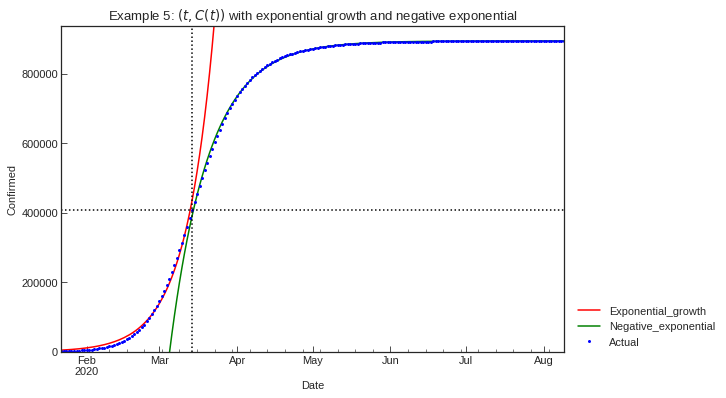

In [ ]:
country = "Example 5"
df = eg_ncov_df.copy()
df = df.loc[df["Country"] == country, :].groupby("Date").last()
start_date = df.index.min()
arg_tt = df["Confirmed"].diff().idxmax()
arg_dd = int((arg_tt - start_date).total_seconds() / 60 / 60 / 24)
arg_cc = df.loc[arg_tt, "Confirmed"]
# Convert date to elapsed time (day)
df.index = ((df.index - start_date).total_seconds() / 60 / 60 / 24).astype(np.int64)
# Curve fitting with exponential growth function
f = lambda x, a, b: a * np.exp(b * x)
series = df.loc[df.index <= arg_dd, "Confirmed"]
a_ini = series[0]
b_ini = np.log(arg_cc / a_ini) / arg_dd
param, _ = curve_fit(f, series.index, series, p0=[a_ini, b_ini])
f_partial = functools.partial(f, a=param[0], b=param[1])
df["Exponential_growth"] = pd.Series(df.index).apply(lambda x: f_partial(x))
# Curve fitting with negative exponential function
f = lambda x, a, b, c: c - a * np.exp(- b * (x - arg_dd))
series = df.loc[df.index >= arg_dd, "Confirmed"]
c_ini = series.max()
a_ini = c_ini - arg_cc
b_ini = series.diff()[arg_dd + 1] / a_ini
param, _ = curve_fit(f, series.index, series, p0=[a_ini, b_ini, c_ini])
f_partial = functools.partial(f, a=param[0], b=param[1], c=param[2])
df["Negative_exponential"] = pd.Series(df.index).apply(lambda x: f_partial(x))
# Convert elapsed time (day) to date
df.index = start_date + pd.Series(df.index).apply(lambda x: timedelta(days=x))
# Plot
df[["Exponential_growth", "Negative_exponential"]].plot(color=["red", "green"])
df["Actual"] = df["Confirmed"]
df["Actual"].plot(color="blue", marker=".", markeredgewidth=0, linewidth=0)
plt.axhline(y=arg_cc, color="black", linestyle=":")
plt.axvline(x=arg_tt, color="black", linestyle=":")
plt.ylabel("Confirmed")
plt.ylim(0, max(df["Confirmed"]) * 1.05)
plt.title(r"{0}: $(t, C(t))$ with exponential growth and negative exponential".format(country))
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(fmt)
plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
plt.show()

However, errors were found for curve fitting when $t \leq \mathrm{argmax}\ \Delta C(t)$.  
This is because
$$
\cfrac{\mathrm{d}C}{\mathrm{d}T} = \cfrac{\beta}{N} S I
$$
$S \simeq N: const.$ for $t \leq \mathrm{argmax}\ \Delta C(t)$, but $I$ is not proportinal to $C$ in SIR-like model.  

This means we cannot convert the differencial equation to the following equations.
\begin{align*}
\frac{\mathrm{d}x}{\mathrm{d}t} & = B x \\
\mathrm{i.e.\ } x(t) & = A e^{Bt}
\end{align*}

## S-R plane
Here, we will discuss the replationship of Susceptible and Recovered.

In SIR-F model,
\begin{align*}
\frac{\mathrm{d}S}{\mathrm{d}T} &= - \cfrac{\beta}{N} S I  \\
\frac{\mathrm{d}R}{\mathrm{d}T} &= \gamma I  \\
I &> 0 \\
S & \simeq N \ \mathrm{when}\ R = 0\\
\end{align*}

Then,
\begin{align*}
\cfrac{\mathrm{d}S}{\mathrm{d}R} &= - \cfrac{\beta}{N \gamma} S  \\
\end{align*}

This leads to

In [ ]:
S = sym.symbols("S", cls=sym.Function)
N, R = sym.symbols("N R", positive=True)
beta, gamma = sym.symbols(r"\beta \gamma", positive=True)
dSdR = - beta / (N * gamma) * S(R)
sr = sym.dsolve(S(R).diff(R) - dSdR, hint="separable", ics={S(0): N})
sr

Eq(S(R), N*exp(-R*\beta/(N*\gamma)))

Note:  
This idea is from [Balkew, Teshome Mogessie, "The SIR Model When S(t) is a Multi-Exponential Function." (2010).Electronic Theses and Dissertations.Paper 1747.](https://dc.etsu.edu/cgi/viewcontent.cgi?article=3102&context=etd) This is for simplest SIR model, but we can apply it to SIR-F model.

In [ ]:
sym.Eq(sym.simplify(sym.log(sr.lhs)), sym.simplify(sym.log(sr.rhs)))

Eq(log(S(R)), log(N) - R*\beta/(N*\gamma))

With constant $a=\frac{\beta}{N\gamma}$ and constant $b=\log N$,
$$
\log S_{(R)} = - a R + b
$$

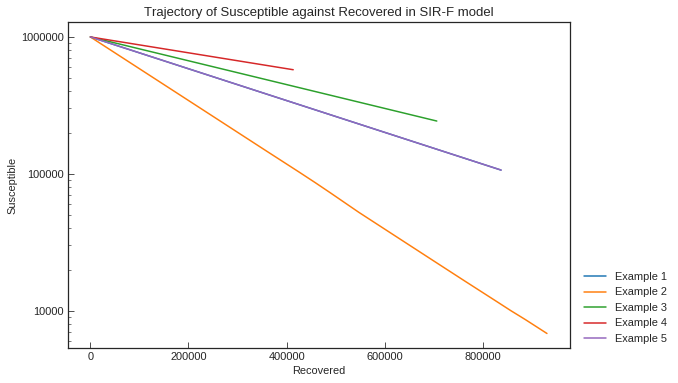

In [ ]:
for country in eg_ncov_df["Country"].unique():
    df = eg_ncov_df.copy()
    df = df.loc[df["Country"] == country, :]
    df = df.groupby("Date").last()
    plt.plot(df["Recovered"], eg_total_population - df["Confirmed"], label=country)

plt.title(r"Trajectory of Susceptible against Recovered in SIR-F model")
plt.yscale("log")
plt.xlabel("Recovered")
plt.ylabel("Susceptible")
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().xaxis.set_major_formatter(fmt)
plt.gca().yaxis.set_major_formatter(fmt)
plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
plt.show()

Nete: Because $R(t)$ is a cummurative number, $R(t+\Delta t) \geq R(t)$ for all $t$ and $\Delta t > 0$.

**Thus, slope of $\log S_{(R)}$ will be changed when SIR-F parameters are changed. We need to split the actual data, considering the change points of S-R line in log-scale. This logic will be used for actual data in scenario analysis section.**

## S-R trend of actual data in one country
We will perform S-R trend analysis for actual data in Italy as an example.

Let's see the plot of S-R trend.

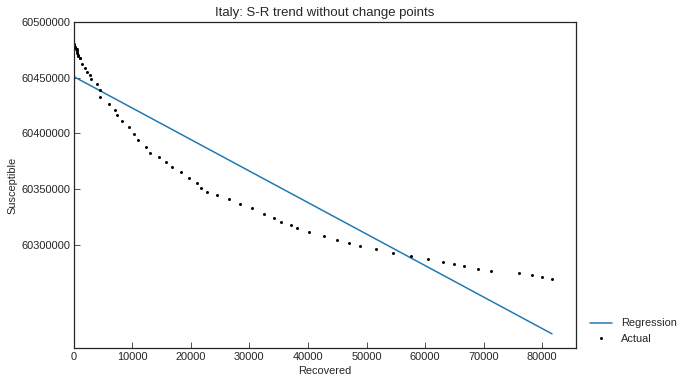

In [ ]:
ita_trend = Trend(ncov_df, population_dict["Italy"], name="Italy", places=[("Italy", None)])
_ = ita_trend.analyse()

Plots of Actual data do not show a line. This means SIR-F parameters changed at some time-points. Next, we will find the time-points, assuming that there are three change points.

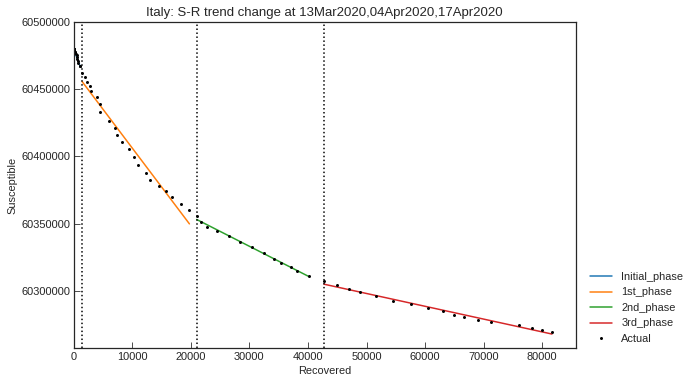

CPU times: user 4.59 s, sys: 407 ms, total: 5 s
Wall time: 4.59 s


In [ ]:
%%time
change_points = ita_trend.analyse(n_points=3)

Initial phase will be ignored in scenario analysis. The change points (start dates of phases) are

In [ ]:
", ".join(change_points)

'13Mar2020, 04Apr2020, 17Apr2020'

# Scenario in Italy<a id="7"></a>
In this section, we will perform scenario analysis using the records of Italy. "Scenario" class was defined in Preparation part.

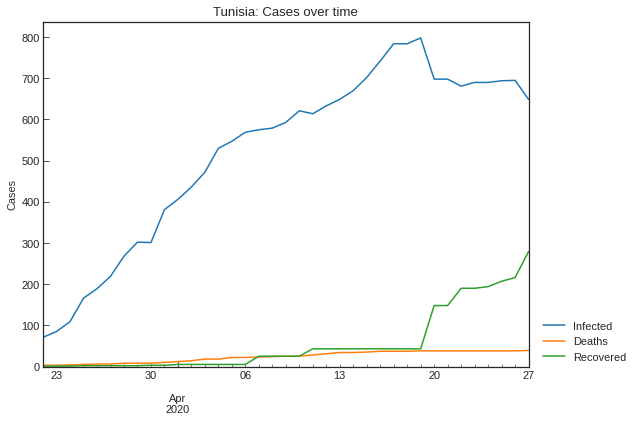

Date  Confirmed  Infected  Deaths  Recovered
32 2020-04-23        918       690      38        190
33 2020-04-24        922       690      38        194
34 2020-04-25        939       694      38        207
35 2020-04-26        949       695      38        216
36 2020-04-27        967       649      39        279

In [ ]:
ita_scenario = Scenario(ncov_df, name="Tunisia", population_dict=population_dict)
ita_scenario.show_record().tail()

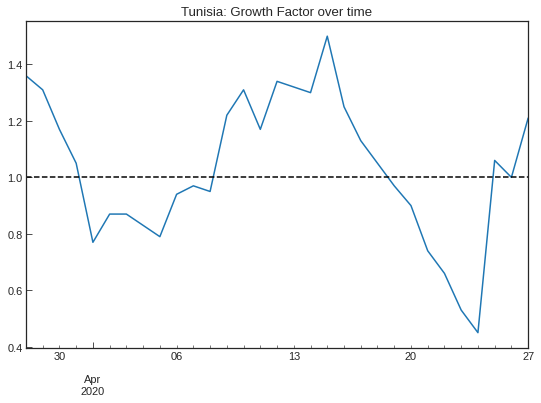

Date      Group  GF > 1 [straight days]  GF < 1 [straight days]
Tunisia 2020-04-27  Crossroad                       1                       0

In [ ]:
ita_scenario.growth_factor()

## S-R Trend analysis

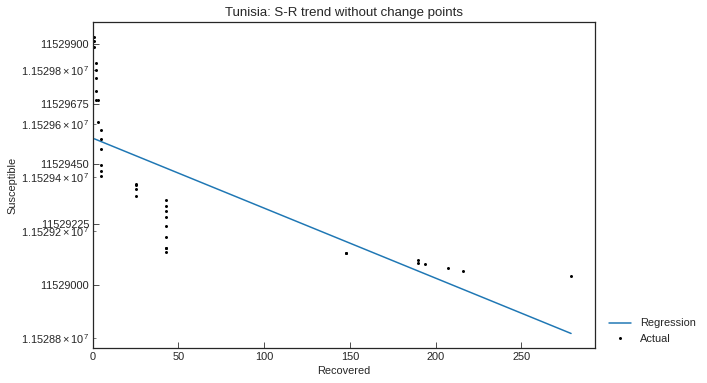

In [ ]:
_ = ita_scenario.trend()

**We will find the time-points, assuming that there are three change points.**

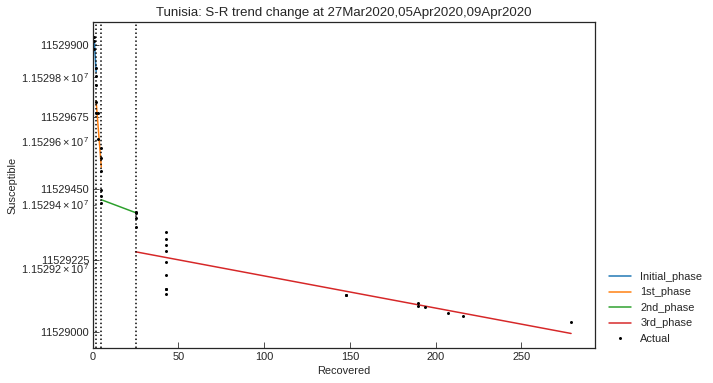

In [ ]:
ita_change_points = ita_scenario.trend(n_points=3)

## Phases in Italy
We will use the change points as the start date of phases. For each phase, will apply SIR-F model. $\tau$ values will be the same value.

In [ ]:
ita_scenario.set_phase(start_dates=ita_change_points)

start_date   end_date  population
1st  27Mar2020  04Apr2020    11530000
2nd  05Apr2020  08Apr2020    11530000
3rd  09Apr2020          -    11530000

## Estimate SIR-F parameters

In [ ]:
ita_scenario.estimate(SIRF)

### 1st phase

In [ ]:
ita_scenario.accuracy_graph(phase_n=1)

### 2nd phase

In [ ]:
ita_scenario.accuracy_graph(phase_n=2)

KeyError: ignored

### 3rd phase

In [ ]:
ita_scenario.accuracy_graph(phase_n=3)

KeyError: ignored

### Compare predicted number of confirmed cases

In [ ]:
ita_scenario.compare_estimated_numbers(phases=["1st", "2nd", "3rd"])

ValueError: ignored

### Compare parameters

In [ ]:
ita_scenario.show_parameters()

start_date   end_date  population  tau     theta     kappa       rho  \
1st  13Mar2020  03Apr2020    60480000  992  0.108909  0.000460  0.085871   
2nd  04Apr2020  16Apr2020    60480000  992  0.145811  0.001003  0.030613   
3rd  17Apr2020          -    60480000  992  0.279573  0.000073  0.012891   

        sigma    Rt     score  alpha1 [-]  1/alpha2 [day]  1/beta [day]  \
1st  0.017169  4.34  0.226149       0.109            1496             8   
2nd  0.011279  2.13  0.037793       0.146             686            22   
3rd  0.012947  0.71  0.057772       0.280            9380            53   

     1/gamma [day]  
1st             40  
2nd             61  
3rd             53

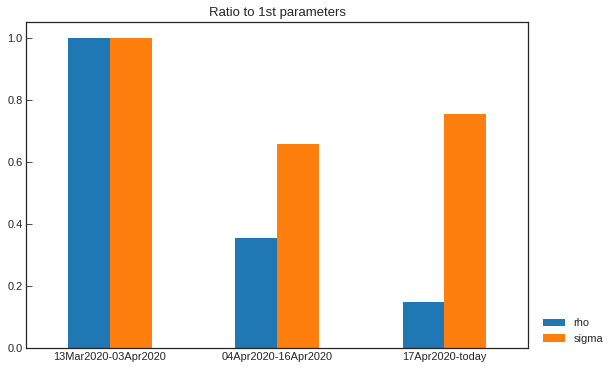

In [ ]:
ita_scenario.clear_future_param()
ita_scenario.param_history(["rho", "sigma"])

**Non-dimensional effective contact rate $\rho$ was reduced in phases.**

In [ ]:
ita_scenario.param_df[["start_date", "end_date", "rho", "Rt"]]

start_date   end_date       rho    Rt
1st  13Mar2020  03Apr2020  0.085871  4.34
2nd  04Apr2020  16Apr2020  0.030613  2.13
3rd  17Apr2020          -  0.012891  0.71

## Why $\rho$ was reduced?

Measures taken in Italy are shown here.

In [ ]:
def _color(data_df):
    df = data_df.copy()
    df.loc[:, :] = str()
    df.iloc[[3, 6, 8], :] = "background-color: lightgreen"
    return df

ita_action_df.style.apply(_color, axis=None)

**It seems that (quaranitine of person contacted with positive patients), school closure and lockdown reduced $\rho$ value.**

## Effect of school closure and lockdown

Acording to first report of [COVID-19 Mobility Monitoring project](https://covid19mm.github.io/in-progress/2020/03/13/first-report-assessment.html) on 13Mar2020, the government of Italy declared a national lockdown on 09Mar2020 and all peole are asked to remain home. This resulted in average reduction of potential encounters of 19% during week 3 (from 07Mar2020 to 10Mar2020).

**Here, we will predict the effect of school closure (started before 04Mar2020), lockdown on 13Mar2020 with assumtion that the effect will be shown from the start date of 3rd phase.**

In [ ]:
ita_scenario.phase_dict["3rd"]["start_date"]

'17Apr2020'

### Real factors of $\beta_1$

The parameter in the math model:  
\begin{align*}
\rho_1 & = \tau \beta_1  \\  
\beta_1 & = \cfrac{1}{49}[g_s \{g_w + g_i (1-q) \} v (1-m)^2 (1-w_e)^{w_n} e^{-(h_{1}+h_{2})} c \delta]  \\
\end{align*}

Control factors:  
$g_s$: **The number of days in <u>a week</u> susceptible persons go out [day]**  
$g_w$: The number of days in <u>a week</u> waiting but un-quarantined persons go out [day]  
$g_i$: The number of days in <u>a week</u> currently infected (confirmed) but un-quarantined persons go out [day]  
$q$: Quarantine rate of currently infected (confirmed) patients [-]  
$v$: Probability of virus existance in a droplet [-]  
$m$: Rate of persons wearing masks effectively (depends logistically on supply of masks) [-]  
$w_e$: Virus reduction effect of washing hands [-]  
$w_n$: The number of times people washes their hands before touching their own faces after go out [-]  
$h_1$: Health condition (active rate of cellular immunity factors) of susceptible and contacted persons [-]  
$h_2$: Health condition (active rate of humoral immunity factors) of susceptible and contacted persons [-]  
$c$: **The number of contacts between susceptible persons and patients while on the go in a minute (depends on population density) [1/min]**  
$\delta$:The product of unknown real factors [-]  

### Value of control factors of $\beta_1$ before/after the national lockdown
A national lockdown will effect on $g_s$ and $c$.

Acccoring the report, we assume average reduction of potential encounters ($c$[-]) of 19%.

In [ ]:
c_before, c_after = 1.0, 0.81

### $g_s$ before the lockdown
We will estimate average number peple go out using @marcoferrante estimation table and population pyramid data.
It is necessary to replace the population pyramid data for Italy because the situation is different from the average data.

In [ ]:
ita_out_df = go_out("Italy")
ita_out_df

Age_first  Age_last     Period_of_life  School  Office  Others   Portion
0           0         2            nursery       3       0       0  0.023674
1           3         5     nursery school       4       0       1  0.024795
2           6        10  elementary school       5       0       1  0.045552
3          11        13      middle school       5       0       1  0.028506
4          14        18        high school       6       0       1  0.047546
5          19        25    university/work       3       3       1  0.068986
6          26        35               work       0       6       1  0.110560
7          36        45               work       0       5       1  0.137011
8          46        55               work       0       5       1  0.161104
9          56        65               work       0       5       1  0.135972
10         66        75            retired       0       0       4  0.110518
11         76        85            retired       0       0       3  0.076720
12         86        95            retired       0       0       2  0.029057

In [ ]:
df = ita_out_df.copy()
gs_before = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
print(f"{round(gs_before, 1)} days in a week susceptible people go out.")

5.6 days in a week susceptible people go out.


### Estimation of $g_s$ after school closure/lockdown
Here, we estimate the $g_s$ after school closure/lockdown with the assumption that only $g_s$ and $c$ was changed.   

Because
$$\cfrac{\rho_{\mathrm{after}}}{gs_{\mathrm{after}}\times c_{\mathrm{after}}} = \cfrac{\rho_{\mathrm{before}}}{gs_{\mathrm{before}}\times c_{\mathrm{before}}}$$

$gs_{\mathrm{after}}$ is

In [ ]:
rho_before = ita_scenario.param("1st", "rho")
rho_after = ita_scenario.param("3rd", "rho")
gs_after = rho_after / rho_before / c_after * gs_before * c_before
print(f"{round(gs_after, 1)} days in a week susceptible people go out after lockdown.")

1.0 days in a week susceptible people go out after lockdown.


Let's apply this value to the go_out table!  
We assume that workers go to their office one day in a week.

In [ ]:
df = ita_out_df.copy()
df["School"] = 0
df.loc[df["Office"] > 0, "Office"] = 1
sum_so = (df[["School", "Office"]].sum(axis=1) * df["Portion"]).sum()
df.loc[df["Others"] > 0, "Others"] = round(gs_after - sum_so, 1)
ita_out_after_df = df.copy()
ita_out_after_df

Age_first  Age_last     Period_of_life  School  Office  Others   Portion
0           0         2            nursery       0       0     0.0  0.023674
1           3         5     nursery school       0       0     0.4  0.024795
2           6        10  elementary school       0       0     0.4  0.045552
3          11        13      middle school       0       0     0.4  0.028506
4          14        18        high school       0       0     0.4  0.047546
5          19        25    university/work       0       1     0.4  0.068986
6          26        35               work       0       1     0.4  0.110560
7          36        45               work       0       1     0.4  0.137011
8          46        55               work       0       1     0.4  0.161104
9          56        65               work       0       1     0.4  0.135972
10         66        75            retired       0       0     0.4  0.110518
11         76        85            retired       0       0     0.4  0.076720
12         86        95            retired       0       0     0.4  0.029057

Check the $g_s$ value calculated with the table.

In [ ]:
df = ita_out_after_df.copy()
gs_after2 = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
print(f"{round(gs_after2, 1)} days in a week susceptible people go out after lockdown.")

1.0 days in a week susceptible people go out after lockdown.


## Predict the future with the last parameters

In a week,

In [ ]:
ita_scenario.predict(days=7).tail(7).style.background_gradient(axis=0)

KeyError: ignored

In 30 days,

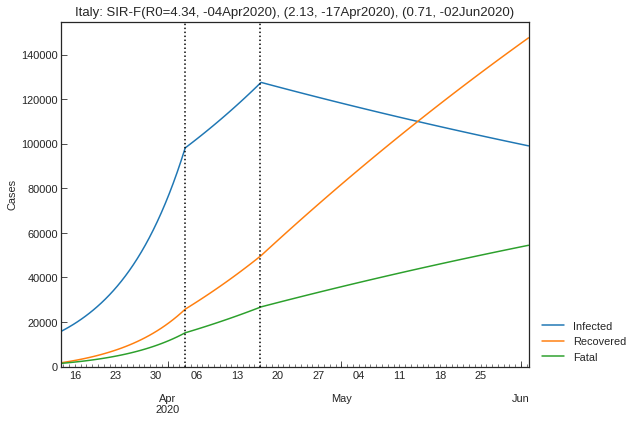

In [ ]:
ita_scenario.predict(days=30).tail(7).style.background_gradient(axis=0)

In the long-term,

In [ ]:
_ = ita_scenario.predict(days=1000, min_infected=1)

KeyError: ignored

## Effect of expected new medicines
New medicines are necessary so that patients can recover more quicky from the disease. Drug repositioning strategy (i.e.finding effective candidates from library of existing drugs of different diseases) is used to develop the medicines of COVID-19. For example, Remdesivir (USAN) and Favipiravir (AVIGAN) are candidates. 

* KEGG DRUG DATABASE: [Remdesivir (USAN)](https://www.kegg.jp/dbget-bin/www_bget?dr:D11472), Antiviral.
* KEGG DRUG DATABASE: [Favipiravir (AVIGAN)](https://www.kegg.jp/dbget-bin/www_bget?dr:D09537), efficancy is Antiviral, RNA replicase inhibitor.

Certainly, Favipiravir (AVIGAN) may lead many serious adverse reactions and it cannot be provided to expectant mothers [KEGG database AVIGAN](https://www.kegg.jp/medicus-bin/japic_med?japic_code=00066852) (Sorry, this is written in Japanese). However, it may help to save many thousand lives.  

Un-controlled clinical study of Remdesivir from 25Jan2020 to 07Mar2020:  
According to [Grein, Jonathan, et al., 2020](https://www.nejm.org/doi/full/10.1056/NEJMoa2007016?query=RP), 10-day course of Remdesivir administration (200 mg at day 1 followed by 100 mg daily) with median foloow-up of 18 days were performed.  

53 patients in the full analysis set were those with confirmed infection and had oxygen satulation of 94% or less while they were breathing ambient air or receiving oxygen support. They are from USA (22 patients), Europe/Canada (22 patients) and Japan (9 patients). 36 patients (68%) showed clinical improvement. 25 patients (47%) was discharged, 7 patients (13%) deceased.

clinical trial with placebo is necessary for evaluation, but we can assume $\gamma$ and $\alpha$ as follows. (This estimation is not refered in this paper. This just a rough evaluation.)
<!--
\begin{align*}
& \kappa \tau^{-1} = \alpha_2 = \cfrac{\bar{h}\ \bar{s}}{N} \sum_{n=0}^{\infty}\cfrac{P_{i}}{L_i} \\
& \sigma \tau^{-1} = \gamma = \cfrac{1 - \bar{h}\ \bar{s}}{N} \sum_{n=0}^{\infty}\cfrac{P_{i}}{l_i} \\
\end{align*}
$\bar{h}$: Rate of I whose immune systems does NOT overcame virus multiplication [-]  
$\bar{s}$: Rate of I$^\star$ who have severe events, including respiratory failure  [-]  
$L_i$: Inverse of F$^\star$'s mortality rate for people $i$ years old [min]  
$l_i$: Inverse of R$^\star$'s mortality rate for people $i$ years old [min]  
$P_i$: The number of people $i$ years old [-]  
$N$: Total population  
-->

$$
\gamma_{med} = \cfrac{\tau \times(\mathrm{Percentage\ of\ discharged)}}{\mathrm{Total\ number\ of\ minutes\ with\ obserbvation}}
$$

In [ ]:
sigma_before = ita_scenario.param("3rd", "sigma")
kappa_before = ita_scenario.param("3rd", "kappa")
(sigma_before, kappa_before)

(0.012946931187012525, 7.343594534734007e-05)

In [ ]:
# Tentative evaluation with clinical study
sigma_med = ita_scenario.param("3rd", "tau") * (25 / 53) / ((10 + 18) * 1440)
kappa_med = ita_scenario.param("3rd", "tau") * (7 / 53) / ((10 + 18) * 1440)
(sigma_med, kappa_med)

(0.011605271039233304, 0.003249475890985325)

In [ ]:
ita_scenario.clear_future_param()
ita_scenario.add_future_param(start_date="01Jun2020", kappa=kappa_med, sigma=sigma_med)

theta     kappa       rho     sigma
4th  0.279573  0.003249  0.012891  0.011605

In three 90 days,

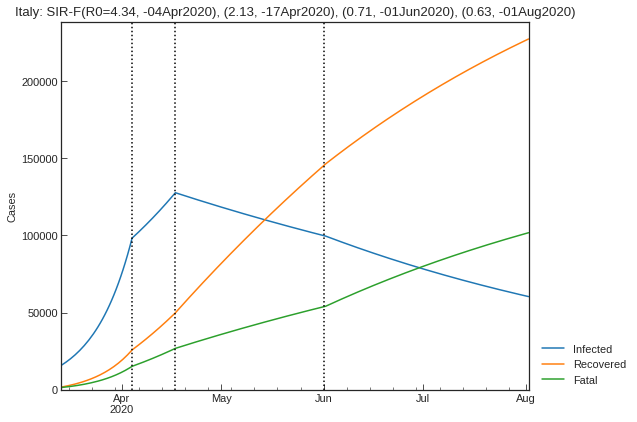

In [ ]:
df = ita_scenario.predict(days=90)

Values are here,

In [ ]:
df.tail(7).style.background_gradient(axis=0)

In the long-term,

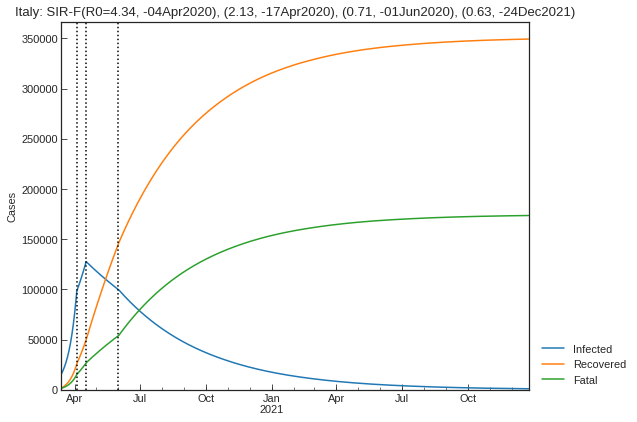

In [ ]:
_ = ita_scenario.predict(days=600, min_infected=1)

# Scenario in Japan<a id="8"></a>
In this section, we will perform scenario analysis using the records of Japan.

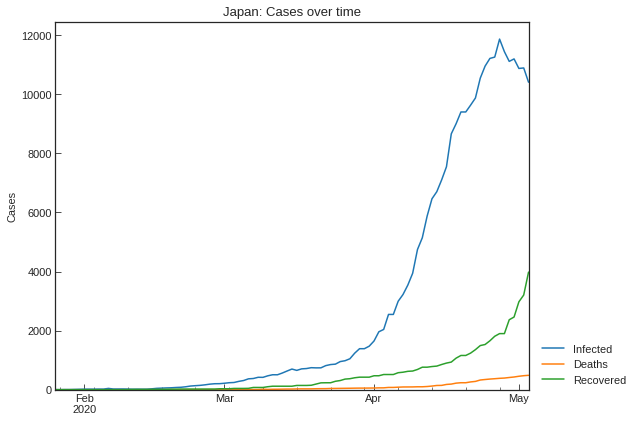

Date  Confirmed  Infected  Deaths  Recovered
94 2020-04-29      13895     11114     413       2368
95 2020-04-30      14088     11198     430       2460
96 2020-05-01      14305     10875     455       2975
97 2020-05-02      14571     10892     474       3205
98 2020-05-03      14877     10409     487       3981

In [ ]:
jpn_scenario = Scenario(ncov_df, name="Japan", population_dict=population_dict)
jpn_scenario.show_record().tail()

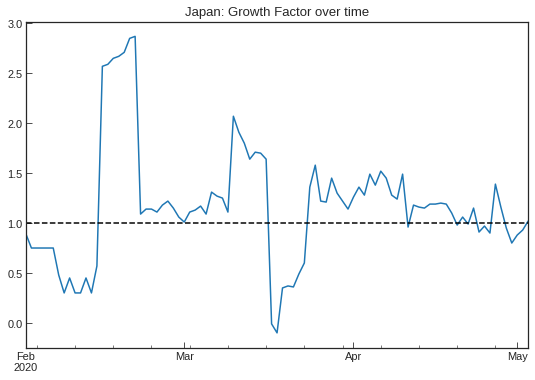

Date      Group  GF > 1 [straight days]  GF < 1 [straight days]
Japan 2020-05-03  Crossroad                       1                       0

In [ ]:
jpn_scenario.growth_factor()

## S-R Trend analysis

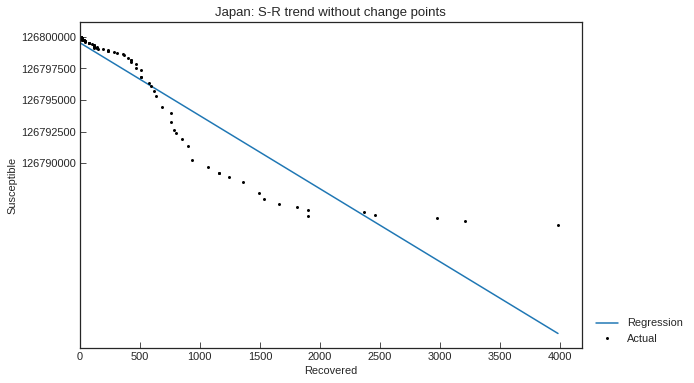

In [ ]:
_ = jpn_scenario.trend()

**We will find the time-points, assuming that there are three change points.**

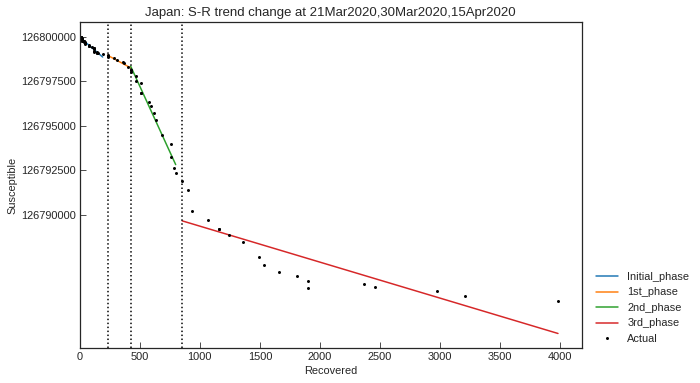

In [ ]:
jpn_change_points = jpn_scenario.trend(n_points=3)

## Phase in Japan
We will use the change points as the start date of phases. For each phase, will apply SIR-F model. $\tau$ values will be the same value.

In [ ]:
df = jpn_scenario.record_df.copy()
df.loc[(df["Recovered"] > 1500) & (df["Recovered"] < 1750), :]

Date  Confirmed  Infected  Deaths  Recovered
89 2020-04-24      12829     10954     345       1530
90 2020-04-25      13231     11215     360       1656

In [ ]:
# Manually added 25Apr2020
jpn_scenario.set_phase(start_dates=[*jpn_change_points, "25Apr2020"])

start_date   end_date  population
1st  21Mar2020  29Mar2020   126800000
2nd  30Mar2020  14Apr2020   126800000
3rd  15Apr2020  24Apr2020   126800000
4th  25Apr2020          -   126800000

## Estimate SIR-F parameters

In [ ]:
jpn_scenario.estimate(SIRF)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 22 sec.
		100 trials finished in 0 min 22 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 19 sec.
		100 trials finished in 0 min 20 sec.
		100 trials finished in 0 min 20 sec.
		100 trials finished in 0 min 21 sec.
		100 trials finished in 0 min 21 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 20 sec.
	Successfully estimated.
Hyperparameter estimation of 4th phase.
	Estimator was created.
		100 trials finished in 0 min 20 sec.
		100 trials finished in 0 min 20 sec.
	Successfully estimated.
Total: 3 min 31 sec.


### 1st phase

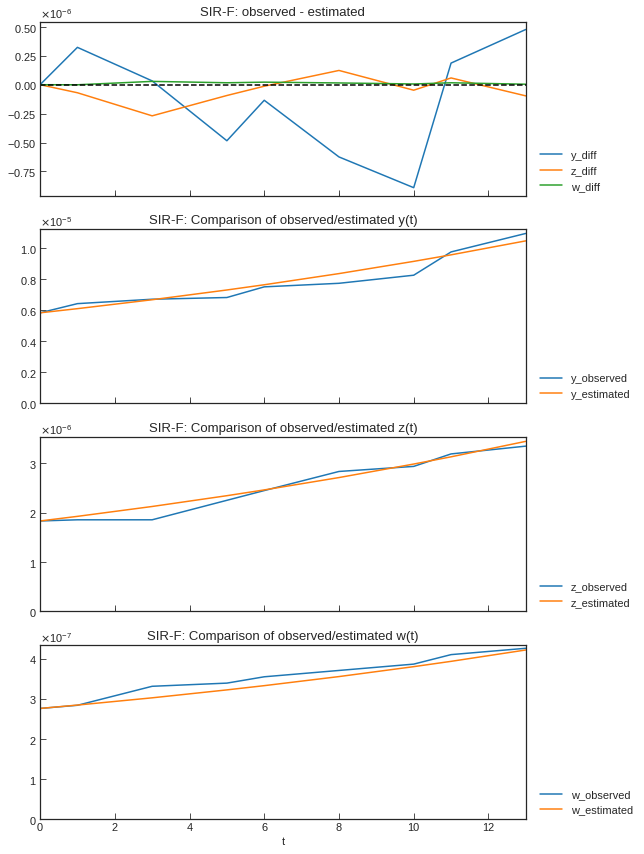

In [ ]:
jpn_scenario.accuracy_graph(phase_n=1)

### 2nd phase

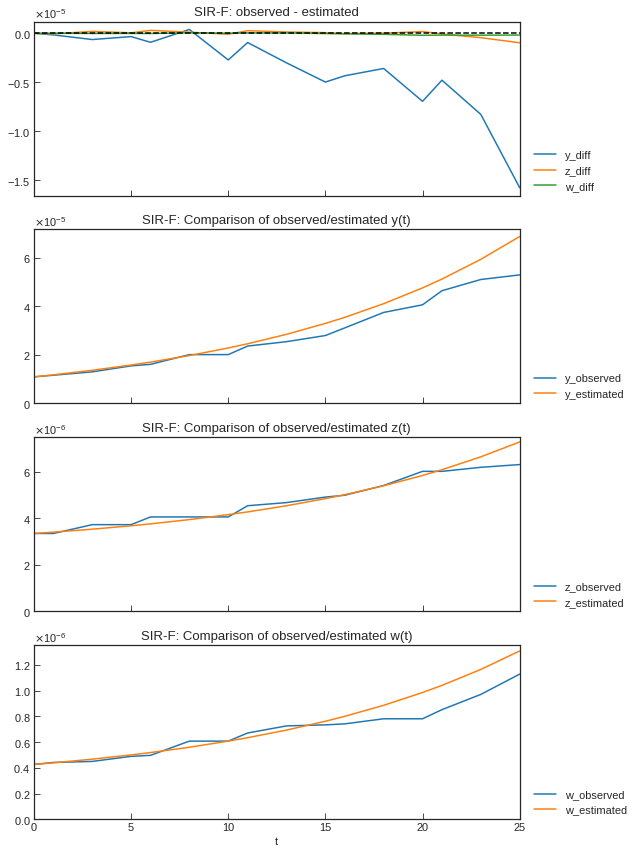

In [ ]:
jpn_scenario.accuracy_graph(phase_n=2)

### 3rd phase

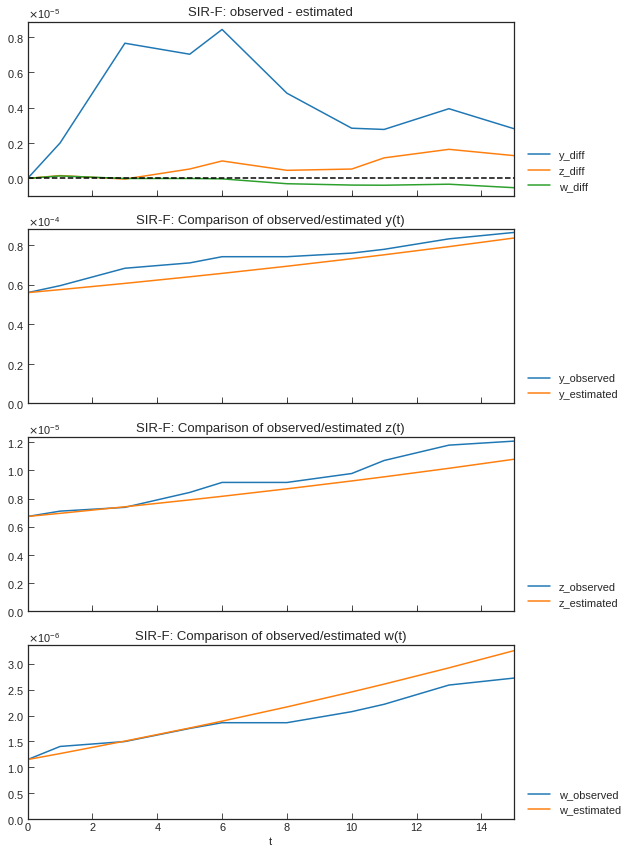

In [ ]:
jpn_scenario.accuracy_graph(phase_n=3)

### 4th phase

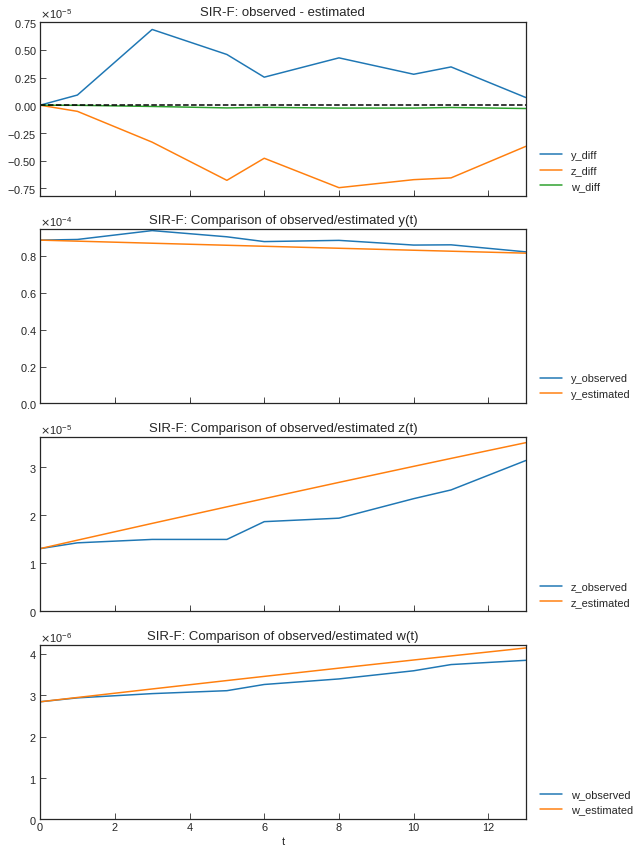

In [ ]:
jpn_scenario.accuracy_graph(phase_n=4)

### Compare predicted number of confirmed cases

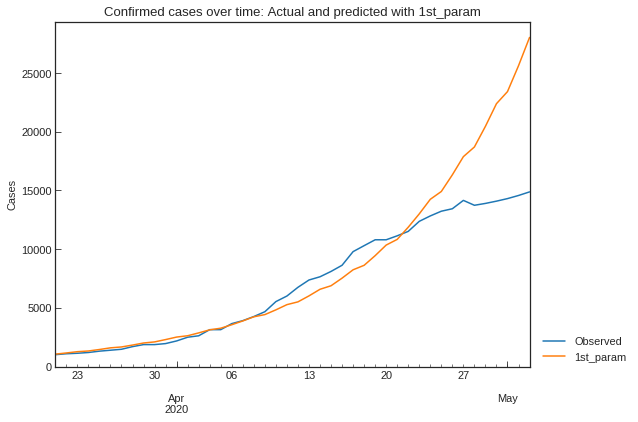

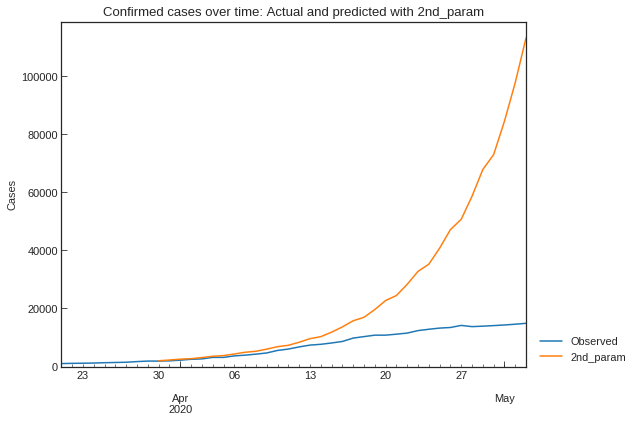

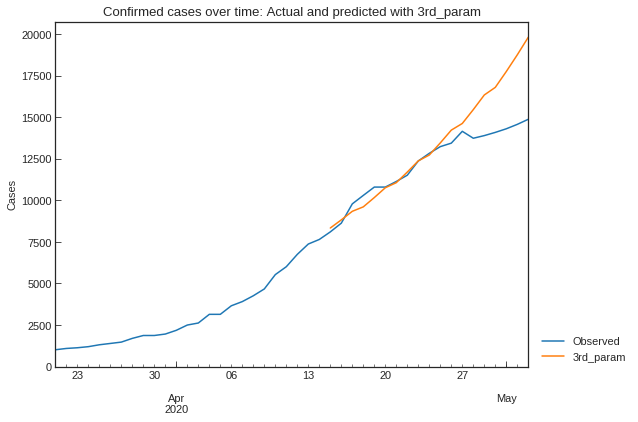

In [ ]:
jpn_scenario.compare_estimated_numbers(["1st", "2nd", "3rd"])

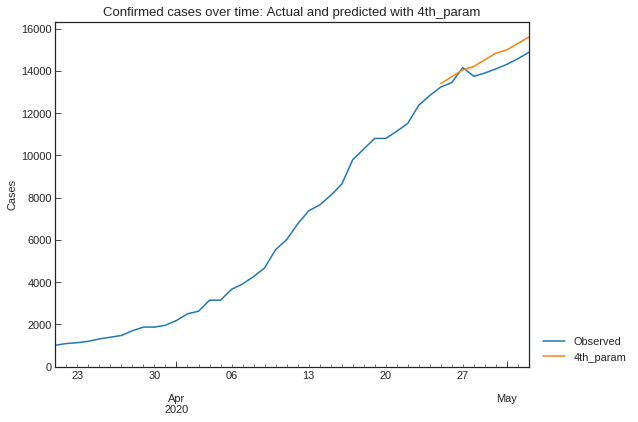

In [ ]:
jpn_scenario.compare_estimated_numbers(["4th"])

### Compare parameters

In [ ]:
jpn_scenario.show_parameters()

start_date   end_date  population  tau     theta     kappa       rho  \
1st  21Mar2020  29Mar2020   126800000  854  0.002659  0.001248  0.061992   
2nd  30Mar2020  14Apr2020   126800000  854  0.000566  0.001077  0.079573   
3rd  15Apr2020  24Apr2020   126800000  854  0.029330  0.001072  0.032647   
4th  25Apr2020          -   126800000  854  0.059152  0.000304  0.014776   

        sigma     Rt     score  alpha1 [-]  1/alpha2 [day]  1/beta [day]  \
1st  0.015630   3.66  0.053863       0.003             475             9   
2nd  0.004999  13.09  0.101994       0.001             550             7   
3rd  0.003923   6.34  0.098288       0.029             553            18   
4th  0.019986   0.69  0.146491       0.059            1948            40   

     1/gamma [day]  
1st             37  
2nd            118  
3rd            151  
4th             29

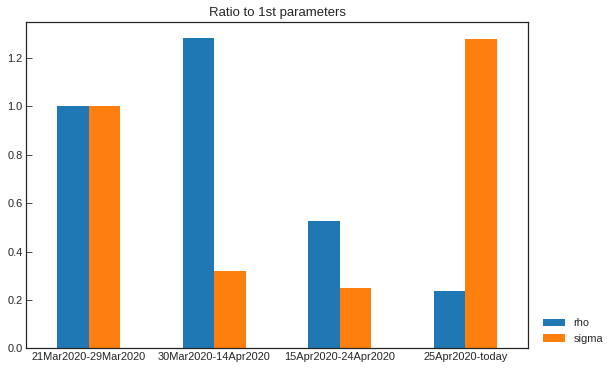

In [ ]:
jpn_scenario.clear_future_param()
jpn_scenario.param_history(["rho", "sigma"])

From 1st phase to 2nd phase, $\rho$ was increased and $\sigma$ was decreased.

## From 1st to 2nd: Why $\rho$ was increased and $\sigma$ was decreased?

## Why $\rho$ was increased?
Tokyo 2020 Olympics was postponed until 2021, but $\rho$ was increasing from 1st phase to 2st phase.

In [ ]:
jpn_scenario.param("2nd", "rho") / jpn_scenario.param("1st", "rho")

1.2835969875081477

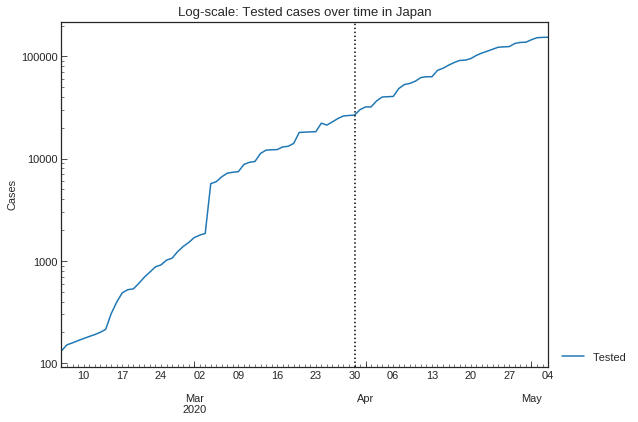

In [ ]:
line_plot(
    jpn_ncov_df["Tested"], "Log-scale: Tested cases over time in Japan",
    y_logscale=True, y_integer=True, v=jpn_scenario.phase_dict["2nd"]["start_date"]
)

The trend of the number of PCR-tested cases was not changed.

Many people went out to hanami from 20Mar2020 to 22Mar2020, but this was a temporary episode.

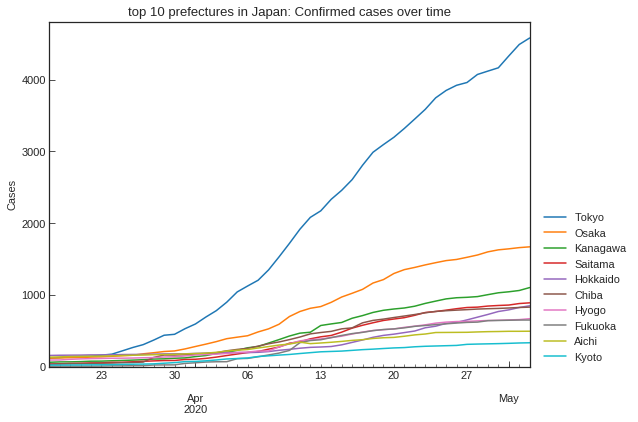

In [ ]:
df = jpn_pref_df.pivot_table(
    index="Date", columns="Prefecture", values="Positive", aggfunc="last"
)
jpn_confirmed_df = df.sort_values(by=df.index[-1], axis=1, ascending=False)
confirmed_top = jpn_confirmed_df.columns[0]
line_plot(
    jpn_confirmed_df.iloc[:, :10],
    "top 10 prefectures in Japan: Confirmed cases over time",
    y_integer=True
)

Most of the cases are in Tokyo or Osaka. Tokyo is the capital city of Japan and the most densely populated area. Osaka is the second. We can assume that high population density makes high value of effective transmission rate $\beta$, $\rho$.

The prefecture where the highest number of confirmed (PCR positive) cases was chronologically changed as follows.

In [ ]:
df = jpn_confirmed_df.idxmax(axis=1)
df = df[df != df.shift()].reset_index()
df.columns = ["Start_date", "Where_highest"]
df

Start_date Where_highest
0 2020-03-18      Hokkaido
1 2020-03-24         Tokyo

Here, we will k-means clustering analysis of prefectures based on $\rho$ and population density.
<!--Here, we will classify the prefectures based on population density and compare the $\rho$ values of the groups.-->

To be continued.

## Why $\sigma$ was decreased?

In [ ]:
jpn_scenario.param("2nd", "sigma") / jpn_scenario.param("1st", "sigma")

0.3198434149473996

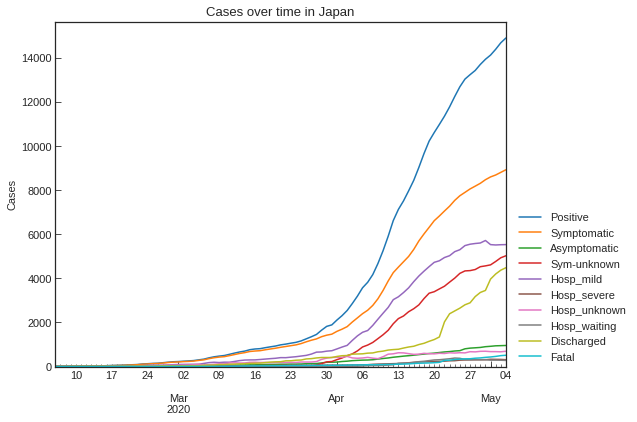

In [ ]:
line_plot(jpn_ncov_df.drop(["Tested"], axis=1), "Cases over time in Japan", y_integer=True)

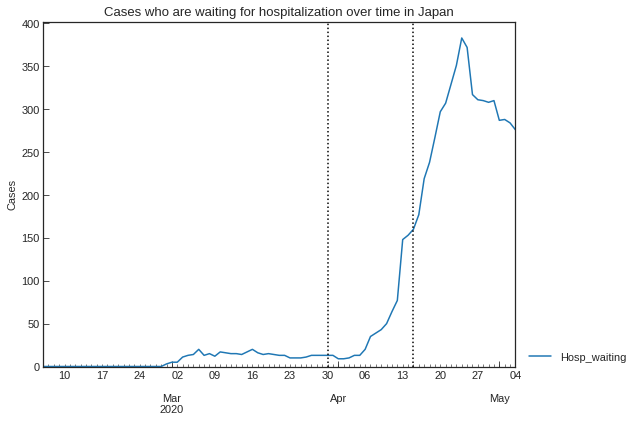

In [ ]:
line_plot(
    jpn_ncov_df["Hosp_waiting"], "Cases who are waiting for hospitalization over time in Japan",
    y_integer=True,
    v=[jpn_scenario.phase_dict["2nd"]["start_date"],jpn_scenario.phase_dict["3rd"]["start_date"]]
)

The number of cases who are waiting for hospitalization was sharply increased after the start date of 23rd phase.  this needs futher investigation.

## Predict the future with the last parameters

In a week,

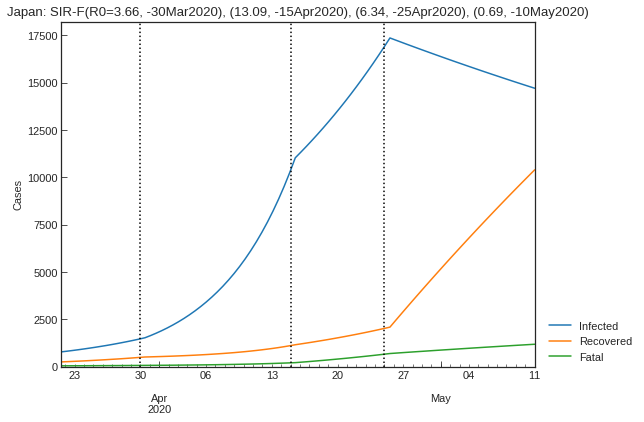

In [ ]:
jpn_scenario.predict(days=7).tail(7).style.background_gradient(axis=0)

In 30 days,

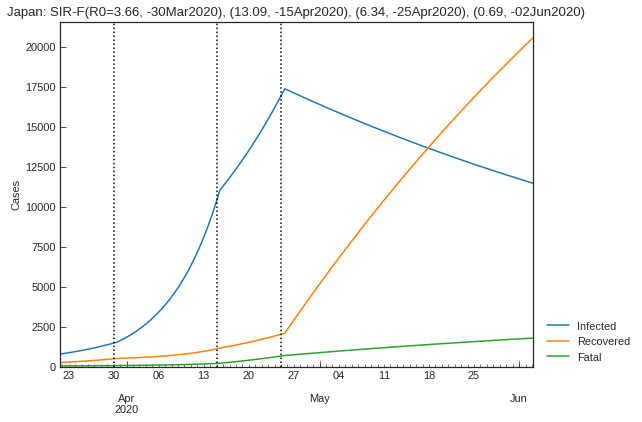

In [ ]:
jpn_scenario.predict(days=30).tail(7).style.background_gradient(axis=0)

In the logn-term,

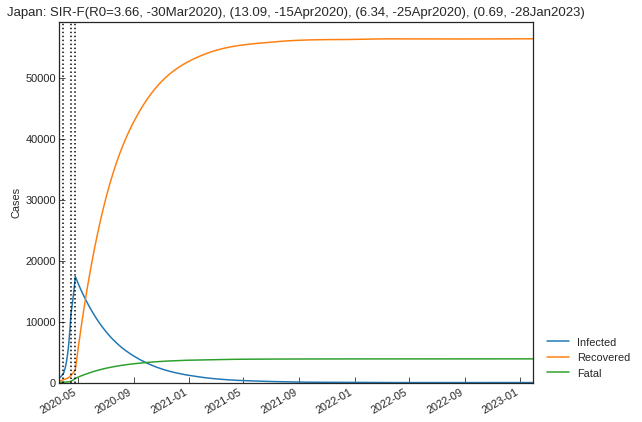

In [ ]:
_ = jpn_scenario.predict(days=1000, min_infected=1)

## Strategy of Japan
Japan declared a state of emergency for three metropolitan areas (Tokyo/Kanagawa/Saitama/Chiba, Osaka/Hyogo, Fukuoka) on 07Apr2020, but national lockdown will not be done. Japan is mainly taking the following three actions.
* Physical (social) distancing: to avoid closed spaces, crowd, conversation at close distance
* Trace the link of patients and give tests on the linked persons preferentially
* Maintain medical level to increase recovery rate and decrease mortality rate

## How to make way by 31May2020 for the number of cases peaking out

### The current situation
Under the assumtion that the current trend continues, when will the number of currently infected cases peak out?  
We can use $R_t$ as the index. When $R_t < 1$, $\frac{\mathrm{d}y}{\mathrm{d}t} < 0$.

This is because  
\begin{align*}
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho (1-\theta) x y - (\sigma + \kappa) y\\
& R_t = \rho (1 - \theta) (\sigma + \kappa)^{-1}\\
& x \simeq 1 \\
\end{align*}

where $R_t$ is reproduction number (phase/time-dependent version of $R_0$).

$x$ is

In [ ]:
1 - jpn_scenario.record_df.iloc[-1, :]["Confirmed"] / population_dict["Japan"]

0.9998826735015773

The current value of $R_t$ is

In [ ]:
jpn_scenario.clear_future_param()
jpn_scenario.param("last", "Rt")

0.69

The number of currently infected cases will peak on

In [ ]:
df = jpn_scenario.predict(days=1000, show_figure=False)
df["Infected"].idxmax().strftime("%d%b%Y")

'25Apr2020'

### How to set $R_t < 1$ by 31May2020
$R_t < 1$ when $\rho$ is under

In [ ]:
current_rho = jpn_scenario.param("last", "rho")
limit_rho = current_rho / jpn_scenario.param("last", "Rt") * 1.0
limit_rho

0.02141466314026089

Here, we assume $\rho$ is

In [ ]:
beta_inv = math.ceil(jpn_scenario.param("last", "tau") / 24 / 60 / limit_rho) + 1
target_rho = jpn_scenario.param("last", "tau") / 24 / 60 / beta_inv
target_rho

0.020450191570881227

In [ ]:
target_rho < limit_rho

True

Set $\rho$ with the assumtion that $\rho$ will gradually (log-scale) decrease,

In [ ]:
jpn_scenario.clear_future_param()
_ = jpn_scenario.add_future_param_gradually("25Apr2020", "31May2020", "rho", current_rho, target_rho)
jpn_scenario.show_parameters()

start_date   end_date  population  tau     theta     kappa       rho  \
1st   21Mar2020  29Mar2020   126800000  854  0.002659  0.001248  0.061992   
2nd   30Mar2020  14Apr2020   126800000  854  0.000566  0.001077  0.079573   
3rd   15Apr2020  24Apr2020   126800000  854  0.029330  0.001072  0.032647   
4th   25Apr2020  24Apr2020   126800000  854  0.059152  0.000304  0.014776   
5th   25Apr2020  25Apr2020   126800000  854  0.059152  0.000304  0.014906   
6th   26Apr2020  26Apr2020   126800000  854  0.059152  0.000304  0.015038   
7th   27Apr2020  27Apr2020   126800000  854  0.059152  0.000304  0.015171   
8th   28Apr2020  28Apr2020   126800000  854  0.059152  0.000304  0.015304   
9th   29Apr2020  29Apr2020   126800000  854  0.059152  0.000304  0.015439   
10th  30Apr2020  30Apr2020   126800000  854  0.059152  0.000304  0.015576   
11th  01May2020  01May2020   126800000  854  0.059152  0.000304  0.015713   
12th  02May2020  02May2020   126800000  854  0.059152  0.000304  0.015852   
13th  03May2020  03May2020   126800000  854  0.059152  0.000304  0.015992   
14th  04May2020  04May2020   126800000  854  0.059152  0.000304  0.016133   
15th  05May2020  05May2020   126800000  854  0.059152  0.000304  0.016275   
16th  06May2020  06May2020   126800000  854  0.059152  0.000304  0.016419   
17th  07May2020  07May2020   126800000  854  0.059152  0.000304  0.016563   
18th  08May2020  08May2020   126800000  854  0.059152  0.000304  0.016710   
19th  09May2020  09May2020   126800000  854  0.059152  0.000304  0.016857   
20th  10May2020  10May2020   126800000  854  0.059152  0.000304  0.017006   
21st  11May2020  11May2020   126800000  854  0.059152  0.000304  0.017156   
22nd  12May2020  12May2020   126800000  854  0.059152  0.000304  0.017307   
23rd  13May2020  13May2020   126800000  854  0.059152  0.000304  0.017460   
24th  14May2020  14May2020   126800000  854  0.059152  0.000304  0.017614   
25th  15May2020  15May2020   126800000  854  0.059152  0.000304  0.017769   
26th  16May2020  16May2020   126800000  854  0.059152  0.000304  0.017926   
27th  17May2020  17May2020   126800000  854  0.059152  0.000304  0.018084   
28th  18May2020  18May2020   126800000  854  0.059152  0.000304  0.018244   
29th  19May2020  19May2020   126800000  854  0.059152  0.000304  0.018404   
30th  20May2020  20May2020   126800000  854  0.059152  0.000304  0.018567   
31st  21May2020  21May2020   126800000  854  0.059152  0.000304  0.018731   
32nd  22May2020  22May2020   126800000  854  0.059152  0.000304  0.018896   
33rd  23May2020  23May2020   126800000  854  0.059152  0.000304  0.019063   
34th  24May2020  24May2020   126800000  854  0.059152  0.000304  0.019231   
35th  25May2020  25May2020   126800000  854  0.059152  0.000304  0.019400   
36th  26May2020  26May2020   126800000  854  0.059152  0.000304  0.019572   
37th  27May2020  27May2020   126800000  854  0.059152  0.000304  0.019744   
38th  28May2020  28May2020   126800000  854  0.059152  0.000304  0.019918   
39th  29May2020  29May2020   126800000  854  0.059152  0.000304  0.020094   
40th  30May2020  30May2020   126800000  854  0.059152  0.000304  0.020271   
41st  31May2020          -   126800000  854  0.059152  0.000304  0.020450   

         sigma     Rt      score  alpha1 [-]  1/alpha2 [day]  1/beta [day]  \
1st   0.015630   3.66  0.0538627       0.003             475             9   
2nd   0.004999  13.09   0.101994       0.001             550             7   
3rd   0.003923   6.34  0.0982875       0.029             553            18   
4th   0.019986   0.69   0.146491       0.059            1948            40   
5th   0.019986   0.69          -       0.059            1948            39   
6th   0.019986   0.70          -       0.059            1948            39   
7th   0.019986   0.70          -       0.059            1948            39   
8th   0.019986   0.71          -       0.059            1948            38   
9th   0.019986   0.72          -       0.059            1948        

$R_t$ will be

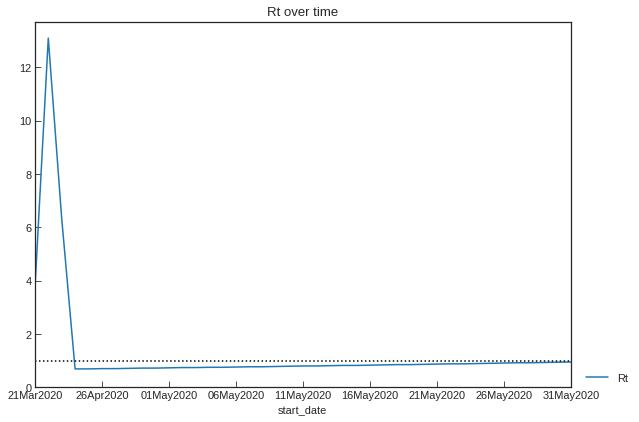

In [ ]:
line_plot(
    jpn_scenario.show_parameters().set_index("start_date")["Rt"],
    title="Rt over time", xlabel="start_date", ylabel="", h=1.0, math_scale=False
)

Trajectory of the number of cases and peak date will be

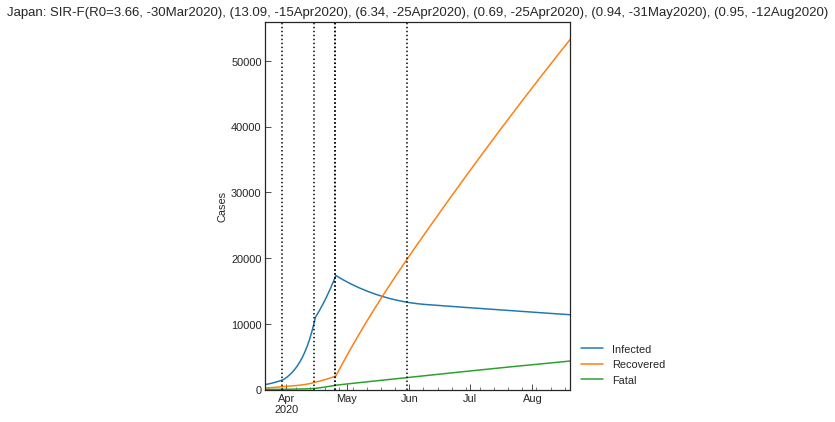

'25Apr2020'

In [ ]:
df = jpn_scenario.predict(days=100)
df["Infected"].idxmax().strftime("%d%b%Y")

### Change factor of $\beta$
Japan focuses on the rate of people in closed spaces/crowd. We need to avoid business offices, meeting spaces, entertainment distincts, shopping malls etc.

Here, we assume that $\beta=\tau^{-1}\rho$ is
\begin{align*}
& \beta_{(p)} = \overline{\beta}(1-p) + \beta^{\ast}p
\end{align*}
where  
$\overline{\beta}$: effective contact rate in average [1/min]  
$\beta^{\ast}$: effective contact rate in closed spaces/crowd [1/min]  
$p$: rate of people in closed spaces/crowd [-]

### Max value of $p$ to meet the goal

@ClusterJapan (expert team to prevent COVID-19 outbreak in Japan) analysed link of patients and summarized as follows. This is from [Twitter @ClusterJapan on 11Apr2020](https://twitter.com/ClusterJapan/status/1248884086581514242?s=20) (in Japanese).
* 80% of patients have less than 1 secondary infected patient
* 10% of patients have 8-12 secondary patients and they are in closed space/crowd

As my personal point of view, $\beta^{\ast}$ can be estimated as $\beta^{\ast} = 10 \times \overline{\beta}$.  
This means
\begin{align*}
& \beta_{(p)} = \overline{\beta}(1+9P)
\end{align*}

$P$ is the rate of people in the spaces where effcetive contact rate is 10 times as the average value.

With the assumption that $\overline{\beta}$ is constant,  
\begin{align*}
& \cfrac{\beta_{before}}{1+9P_{before}} = \cfrac{\beta_{after}}{1+9P_{after}}
\end{align*}
("Before" means "before the national emergency declaration on 06Apr2020.)

Then,
\begin{align*}
& \cfrac{1+9P_{after}}{1+9P_{before}} = \cfrac{\rho_{after}}{\rho_{before}}
\end{align*}

So,
\begin{align*}
& P_{after} = \frac{1}{9}\left[ \cfrac{\rho_{after}}{\rho_{before}}(1+9P_{before}) - 1 \right]
\end{align*}

$\cfrac{\rho_{after}}{\rho_{before}}$ is

In [ ]:
target_rho / jpn_scenario.param("last", "rho")

1.3840030358757966

We can estimate $P_{before}$ with go-out table.
* Schools were closed
* 10.6% of people work remotely because
  - 5.6% of respondents work remotely (cf.1),
  - total number of respondents is 23,992,701 (cf.2),
  - 2,651,272 respondents are working in service industry (cf.2),
  - 2,128,322 respondents are medical personnel or care worker (cf.2),
  - 7,928,268 respondents are office workers or workers of logistics companies (cf.2).
  - The number of days the respondent work remotely is not known.
* As usual, 75% of people are in closed space/crowded (CC) area: this is just my point of view, I'm gathering information.
* Compared to baseline, 25% reduction was shown in Retail & recreation area: cf.3

cf.1: (In Japanese) [Report of 1st survey by Ministry of Health, Labor and Welfare & LINE Corporation](https://www.mhlw.go.jp/stf/newpage_10695.html)  
cf.2: (In Japanese) [Detailed report of 1st survey by Ministry of Health, Labor and Welfare & LINE Corporation](https://www.mhlw.go.jp/stf/newpage_10798.html)
Movility reports: [COVID-19 Community Mobility Reports in Japan on 05Apr2020](https://www.gstatic.com/covid19/mobility/2020-04-05_JP_Mobility_Report_en.pdf)

In [ ]:
remote_rate = round(0.056 * 23992701 / (2651272 + 2128322 + 7928268), 3)
remote_rate

0.106

In [ ]:
df = go_out("Japan")
df["School"] = 0
df["Remote"] = df["Office"] * remote_rate
df["Workplace"] = df["Office"] - df["Remote"]
df["Others_CC"] = df["Others"] * 0.75 * (1 - 0.25)
df["Others"] = df["Others"] - df["Others_CC"]
df = pd.concat([df["Portion"], df.loc[:, ~df.columns.isin(["Portion"])]], axis=1)
df = df.drop("Office", axis=1)
jpn_go_df = df.copy()
jpn_go_df

Portion  Age_first  Age_last     Period_of_life  School  Others  Remote  \
0   0.023292          0         2            nursery       0  0.0000   0.000   
1   0.024166          3         5     nursery school       0  0.4375   0.000   
2   0.043395          6        10  elementary school       0  0.4375   0.000   
3   0.026526         11        13      middle school       0  0.4375   0.000   
4   0.045251         14        18        high school       0  0.4375   0.000   
5   0.066696         19        25    university/work       0  0.4375   0.318   
6   0.106875         26        35               work       0  0.4375   0.636   
7   0.134815         36        45               work       0  0.4375   0.530   
8   0.142129         46        55               work       0  0.4375   0.530   
9   0.123395         56        65               work       0  0.4375   0.530   
10  0.137152         66        75            retired       0  1.7500   0.000   
11  0.089784         76        85            retired       0  1.3125   0.000   
12  0.036524         86        95            retired       0  0.8750   0.000   

    Workplace  Others_CC  
0       0.000     0.0000  
1       0.000     0.5625  
2       0.000     0.5625  
3       0.000     0.5625  
4       0.000     0.5625  
5       2.682     0.5625  
6       5.364     0.5625  
7       4.470     0.5625  
8       4.470     0.5625  
9       4.470     0.5625  
10      0.000     2.2500  
11      0.000     1.6875  
12      0.000     1.1250

$P_{before}$ can be estimated as

In [ ]:
df = jpn_go_df.copy()
p_before = (df[["School", "Workplace", "Others_CC"]].sum(axis=1) * df["Portion"]).sum() / 7
p_before

0.4920099997132164

\begin{align*}
& P_{after} = \frac{1}{9}\left[ \cfrac{\rho_{after}}{\rho_{before}}(1+9P_{before}) - 1 \right]
\end{align*}

To meet the goal, $P_{after}$ should be under

In [ ]:
def calc_target_p(rho_before, rho_after, p_before):
    return (rho_before / rho_after * (1 + 9 * p_before) - 1) / 9

In [ ]:
target_p = calc_target_p(target_rho, jpn_scenario.param("last", "rho"), p_before)
target_p

0.7236103372705409

### Max value of go-out index to meet the goal

## How to prevent overwhelming medical system
We need to flatten the curve of currently infected cases so that prevent overwhelming medical system. The peak value of currently infected cases must not exceed the number of hospital capacity.

### How many medical staffs, ICU beds, hospitals and other sites we have

### Severity of the currently infected patients
We categoize the patient with severity as the following.
* Grade1: Asymptomtic or mild symptoms, need self-quarantine at home or hotel
* Grade2: Severity is unknown and need hospitalization for diagnosis
* Grade3: Severe and need ICU

In [ ]:
jpn_ncov_df.tail()

Positive  Tested  Symptomatic  Asymptomatic  Sym-unknown  \
Date                                                                   
2020-04-30     13929  137338         8469           898         4562   
2020-05-01     14120  145243         8596           916         4608   
2020-05-02     14383  152029         8683           938         4762   
2020-05-03     14677  153047         8802           945         4930   
2020-05-04     14895  153581         8921           953         5021   

            Hosp_mild  Hosp_severe  Hosp_unknown  Hosp_waiting  Discharged  \
Date                                                                         
2020-04-30       5713          308           692           310        3449   
2020-05-01       5526          328           675           287        3964   
2020-05-02       5510          324           674           288        4194   
2020-05-03       5522          321           667           284        4368   
2020-05-04       5527          308           691           276        4479   

            Fatal  
Date               
2020-04-30    415  
2020-05-01    432  
2020-05-02    458  
2020-05-03    492  
2020-05-04    510

Proportion of each grade is as below.

In [ ]:
df = jpn_ncov_df.copy()
df["Grade1"] = df["Asymptomatic"] + df["Hosp_mild"]
df["Grade2"] = df["Sym-unknown"] + df["Hosp_unknown"] + df["Hosp_waiting"]
df["Grade3"] = df["Hosp_severe"]
df = df.loc[:, ["Grade1", "Grade2", "Grade3"]]
df = df.apply(lambda x: x / np.sum(x), axis=1)
grade_df = df.copy()
grade_df.tail()

Grade1    Grade2    Grade3
Date                                    
2020-04-30  0.529600  0.445726  0.024674
2020-05-01  0.522042  0.451378  0.026580
2020-05-02  0.516005  0.458067  0.025928
2020-05-03  0.510459  0.464204  0.025337
2020-05-04  0.507201  0.468691  0.024108

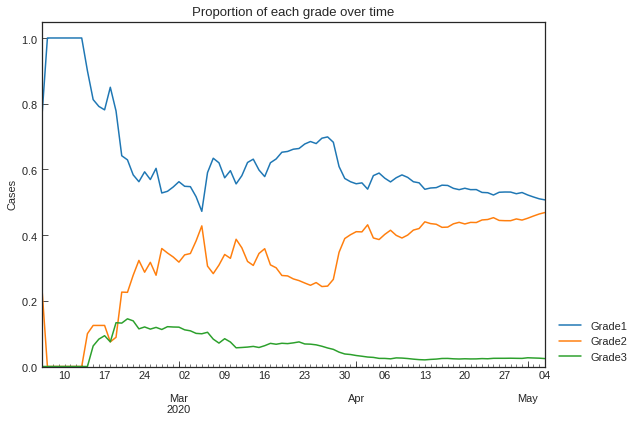

In [ ]:
line_plot(grade_df, "Proportion of each grade over time")

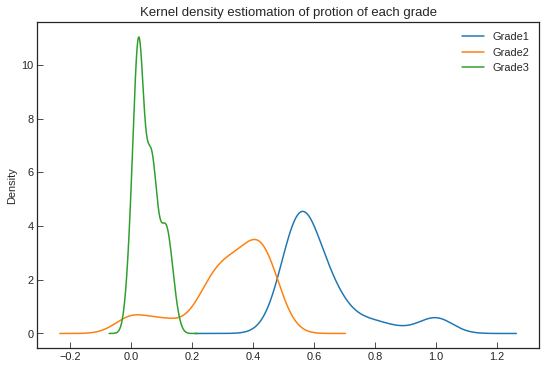

In [ ]:
grade_df.plot.kde(title="Kernel density estiomation of protion of each grade")
plt.show()

In [ ]:
grade_df.describe().T

count      mean       std       min       25%       50%       75%  \
Grade1   89.0  0.628699  0.134935  0.472325  0.542613  0.575663  0.654596   
Grade2   89.0  0.317830  0.131811  0.000000  0.265217  0.344051  0.424314   
Grade3   89.0  0.053471  0.039568  0.000000  0.024108  0.038114  0.074901   

             max  
Grade1  1.000000  
Grade2  0.468691  
Grade3  0.145161

In [ ]:
grade_dict = grade_df.median().to_dict()
grade_dict

{'Grade1': 0.5756633499170812,
 'Grade2': 0.3440514469453376,
 'Grade3': 0.03811369509043928}

### Max value of $\gamma$ to meet the goal

### Are new medicines are effective?

# Scenario in India<a id="12"></a>
In this section, we will perform scenario analysis using the records of India.

In [ ]:
ind_scenario = Scenario(ncov_df, name="India", population_dict=population_dict)

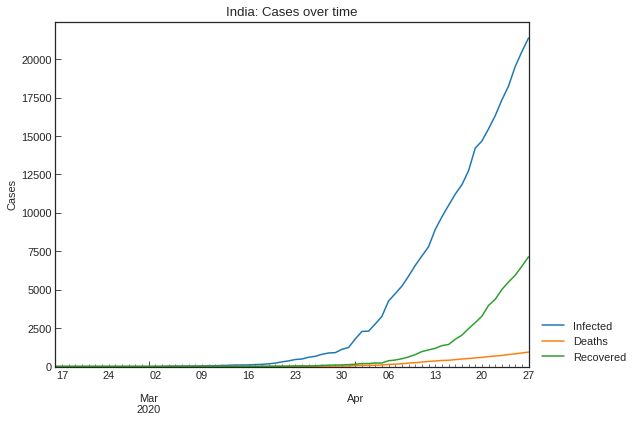

Date  Confirmed  Infected  Deaths  Recovered
67 2020-04-23      23077     17344     721       5012
68 2020-04-24      24530     18252     780       5498
69 2020-04-25      26283     19519     825       5939
70 2020-04-26      27890     20486     881       6523
71 2020-04-27      29451     21375     939       7137

In [ ]:
ind_scenario.show_record().tail()

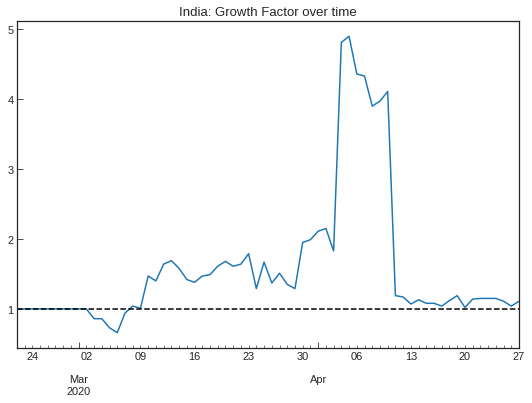

Date        Group  GF > 1 [straight days]  GF < 1 [straight days]
India 2020-04-27  Outbreaking                      51                       0

In [ ]:
ind_scenario.growth_factor()

## S-R Trend analysis

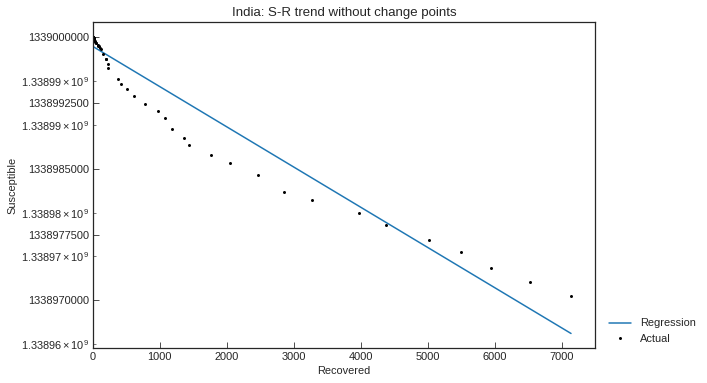

In [ ]:
_ = ind_scenario.trend()

**We will find the time-points, assuming that there are two change points.**

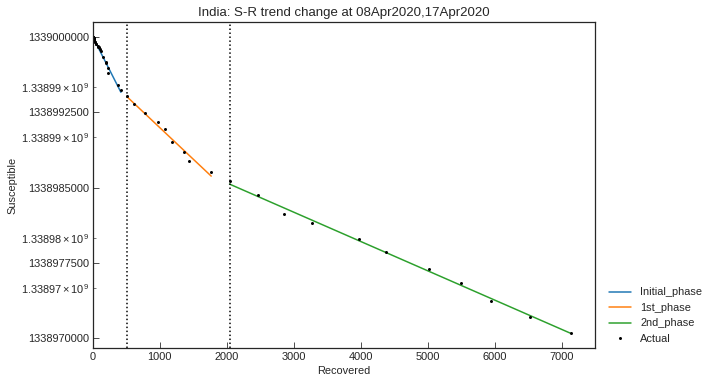

In [ ]:
ind_change_points = ind_scenario.trend(n_points=2)

## Phases in India
We will use the change points as the start date of phases. For each phase, will apply SIR-F model. $\tau$ values will be the same value.

In [ ]:
ind_scenario.set_phase(start_dates=ind_change_points)

start_date   end_date  population
1st  08Apr2020  16Apr2020  1339000000
2nd  17Apr2020          -  1339000000

In [ ]:
ind_scenario.estimate(SIRF)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 21 sec.
		100 trials finished in 0 min 21 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 18 sec.
		100 trials 

KeyboardInterrupt: ignored

### 1st phase

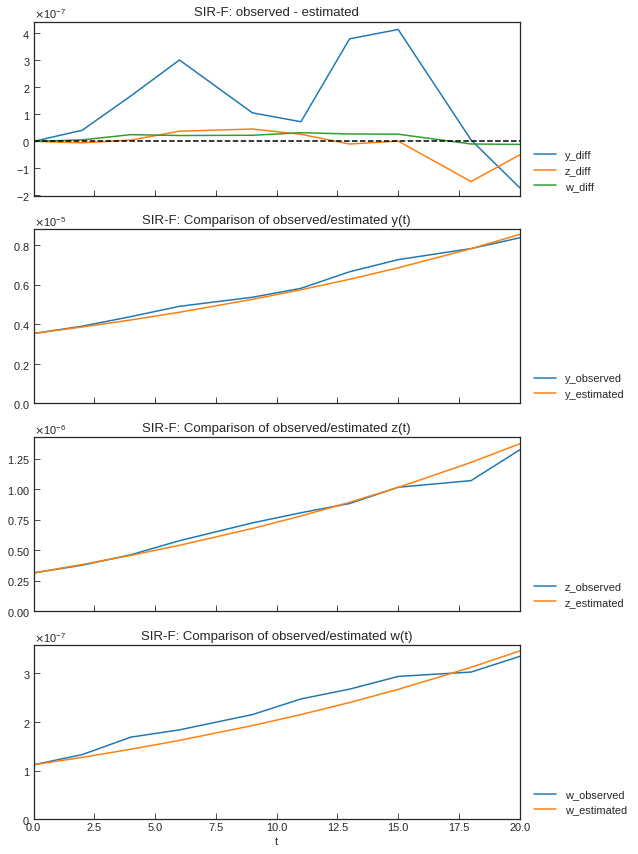

In [ ]:
ind_scenario.accuracy_graph(phase_n=1)

### 2nd phase

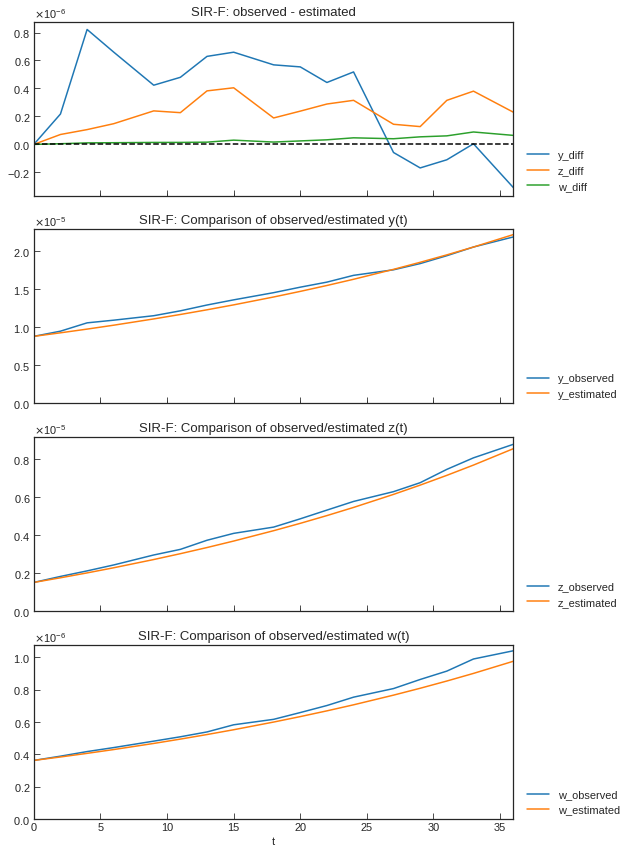

In [ ]:
ind_scenario.accuracy_graph(phase_n=2)

### Compare predicted number of confirmed cases

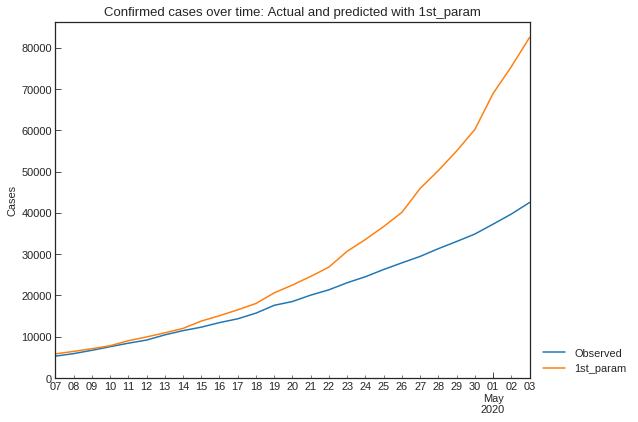

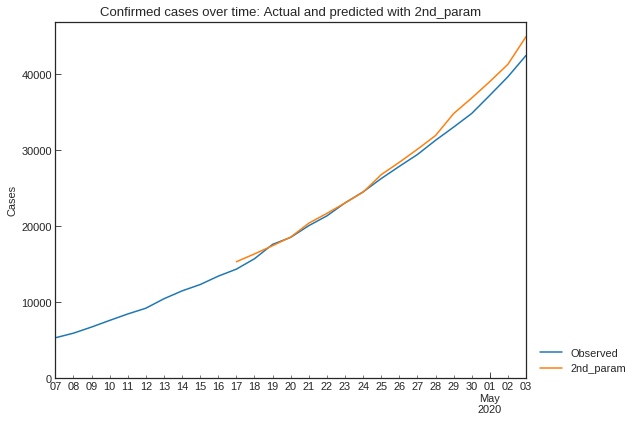

In [ ]:
ind_scenario.compare_estimated_numbers(phases=["1st", "2nd"])

### Compare parameters

In [ ]:
ind_scenario.show_parameters()

start_date   end_date  population  tau     theta     kappa       rho  \
1st  07Apr2020  16Apr2020  1339000000  640  0.027304  0.000545  0.055422   
2nd  17Apr2020          -  1339000000  640  0.001778  0.001099  0.040278   

        sigma    Rt     score  alpha1 [-]  1/alpha2 [day]  1/beta [day]  \
1st  0.009295  5.48  0.072416       0.027             816             8   
2nd  0.013476  2.76  0.052348       0.002             404            11   

     1/gamma [day]  
1st             47  
2nd             32

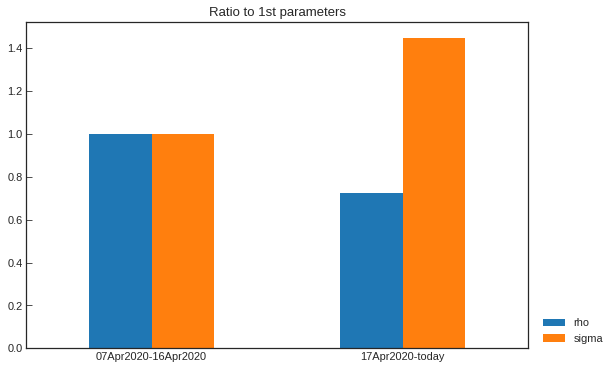

In [ ]:
ind_scenario.param_history(["rho", "sigma"])

## Predict the future with the last parameters

In a week,

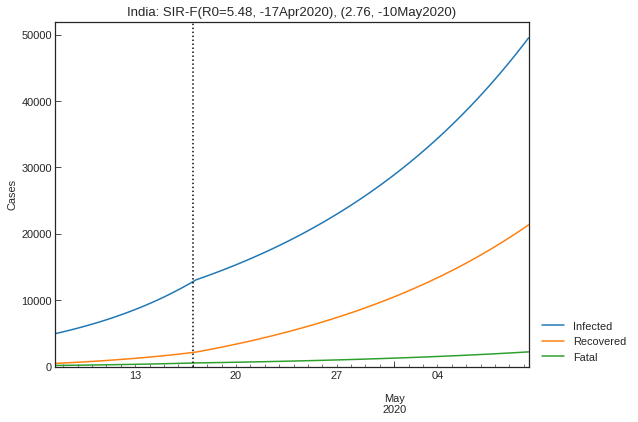

In [ ]:
ind_scenario.predict(days=7).tail(7).style.background_gradient(axis=0)

In 30 days,

In [ ]:
ind_scenario.predict(days=30).tail(7).style.background_gradient(axis=0)

NameError: ignored

In the long-term,

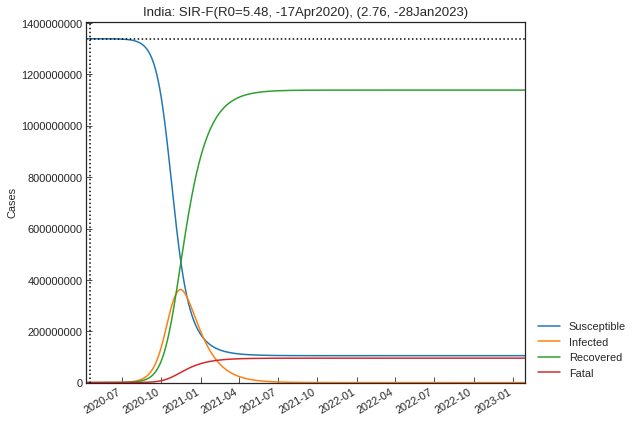

In [ ]:
_ = ind_scenario.predict(days=1000, min_infected=1)

# Scenario in USA<a id="14"></a>
In this section, we will perform scenario analysis using the records of USA (United States of America, US).

In [ ]:
usa_scenario = Scenario(ncov_df, name="US", population_dict=population_dict)

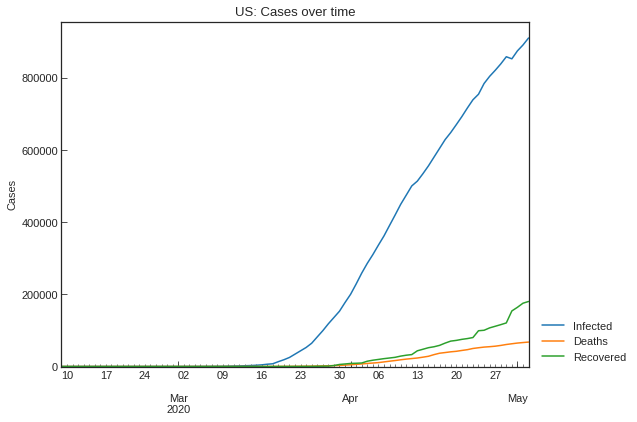

Date  Confirmed  Infected   Deaths  Recovered
80 2020-04-29  1039909.0  858222.0  60967.0   120720.0
81 2020-04-30  1069424.0  852481.0  62996.0   153947.0
82 2020-05-01  1103461.0  874503.0  64943.0   164015.0
83 2020-05-02  1132539.0  890788.0  66369.0   175382.0
84 2020-05-03  1158040.0  910206.0  67682.0   180152.0

In [ ]:
usa_scenario.show_record().tail()

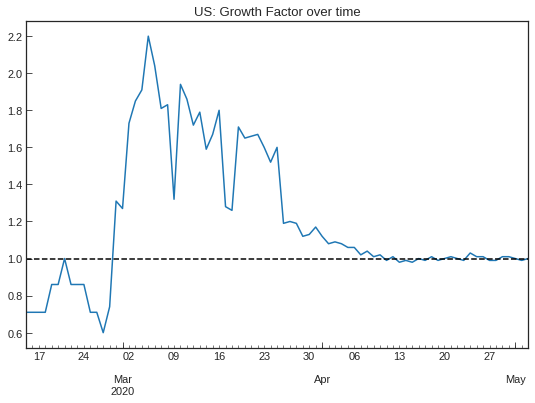

Date      Group  GF > 1 [straight days]  GF < 1 [straight days]
US 2020-05-03  Crossroad                       0                       0

In [ ]:
usa_scenario.growth_factor()

## S-R Trend analysis

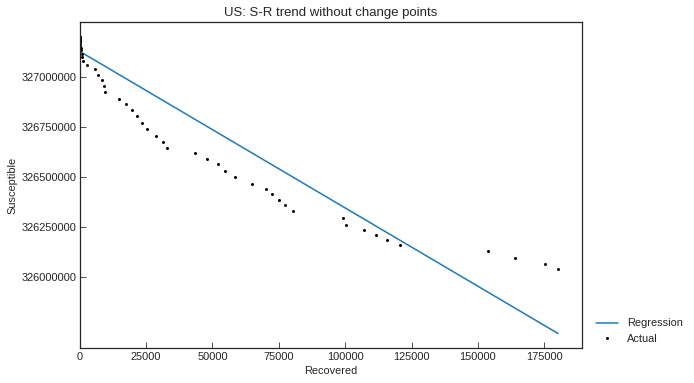

In [ ]:
_ = usa_scenario.trend()

**We will find the time-points, assuming that there are three change points.**

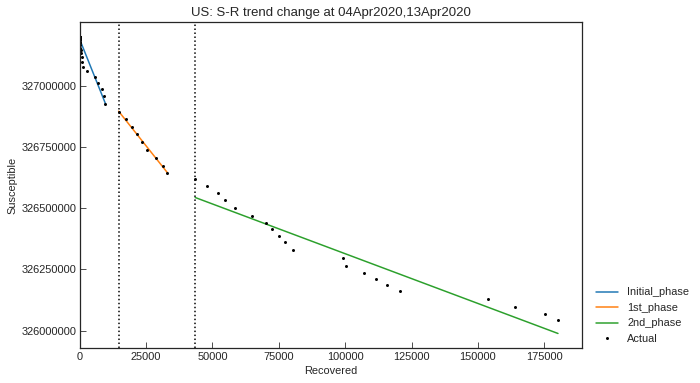

In [ ]:
usa_change_points = usa_scenario.trend(n_points=2)

## Phases in USA
We will use the change points as the start date of phases. For each phase, will apply SIR-F model. $\tau$ values will be the same value.

In [ ]:
usa_scenario.set_phase(start_dates=usa_change_points)

start_date   end_date  population
1st  04Apr2020  12Apr2020   327200000
2nd  13Apr2020          -   327200000

In [ ]:
usa_scenario.estimate(SIRF)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 24 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 20 sec.
		100 trials finished in 0 min 21 sec.
		100 trials finished in 0 min 21 sec.
	Successfully estimated.
Total: 1 min 28 sec.


### 1st phase

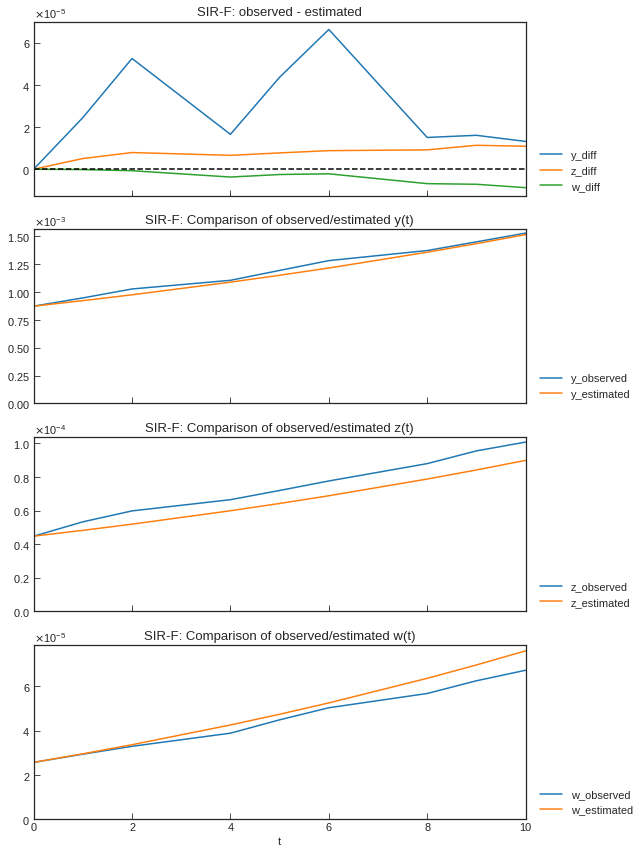

In [ ]:
usa_scenario.accuracy_graph(phase_n=1)

### 2nd phase

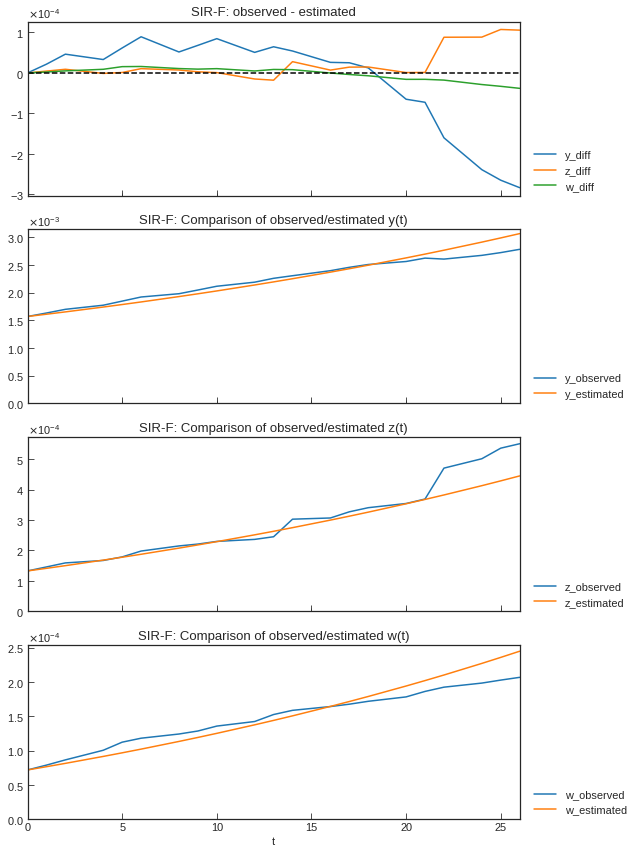

In [ ]:
usa_scenario.accuracy_graph(phase_n=2)

### Compare predicted number of confirmed cases

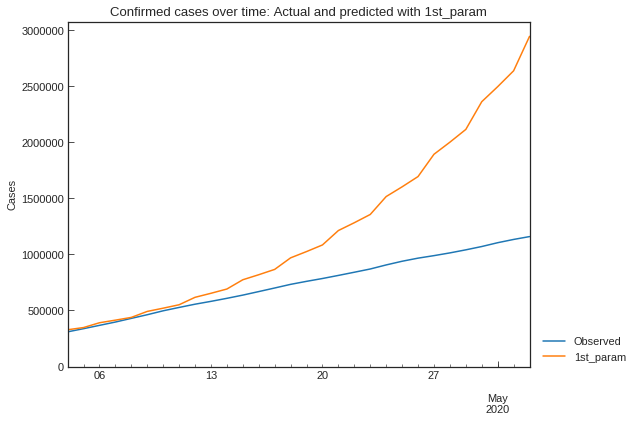

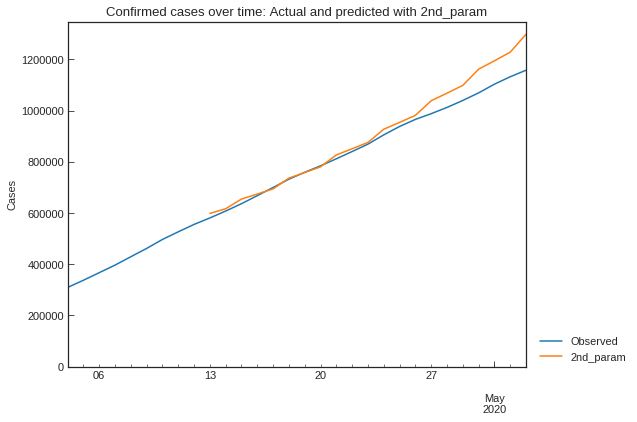

In [ ]:
usa_scenario.compare_estimated_numbers(phases=["1st", "2nd"])

### Compare parameters

In [ ]:
usa_scenario.show_parameters()

start_date   end_date  population   tau     theta     kappa       rho  \
1st  04Apr2020  12Apr2020   327200000  1079  0.057694  0.000668  0.063406   
2nd  13Apr2020          -   327200000  1079  0.065689  0.000739  0.034177   

        sigma     Rt     score  alpha1 [-]  1/alpha2 [day]  1/beta [day]  \
1st  0.003875  13.15  0.084632       0.058            1121            11   
2nd  0.005370   5.23  0.087436       0.066            1014            21   

     1/gamma [day]  
1st            193  
2nd            139

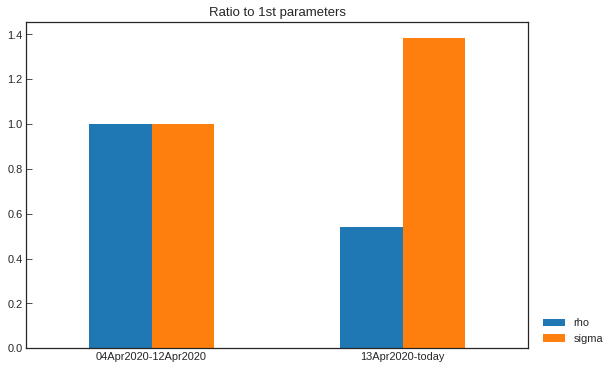

In [ ]:
usa_scenario.param_history(["rho", "sigma"])

## Predict the future with the last parameters

In a week,

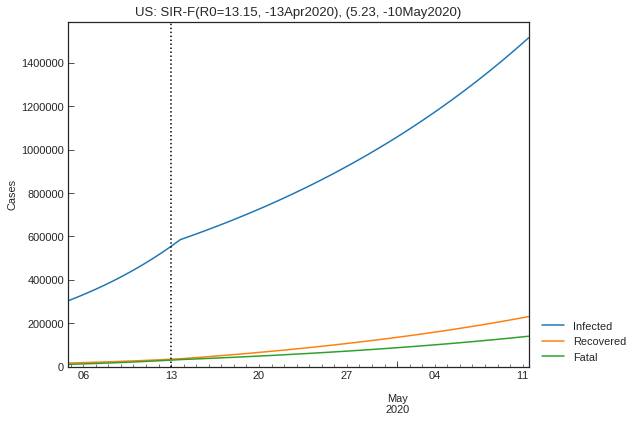

In [ ]:
usa_scenario.predict(days=7).tail(7).style.background_gradient(axis=0)

In 30 days,

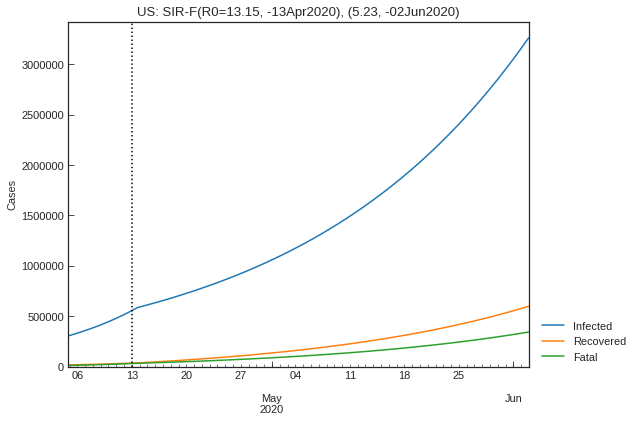

In [ ]:
usa_scenario.predict(days=30).tail(7).style.background_gradient(axis=0)

In the long-term,

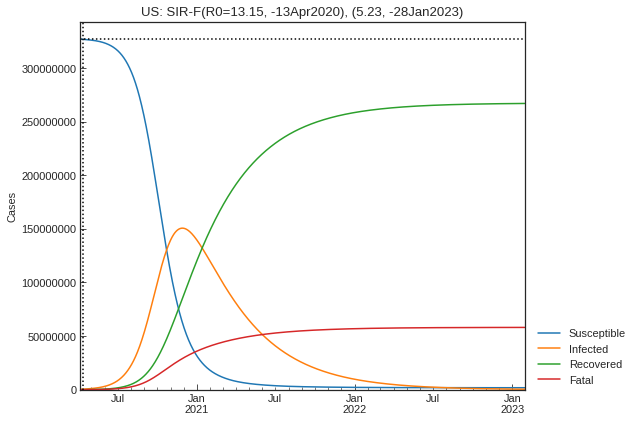

In [ ]:
_ = usa_scenario.predict(days=1000, min_infected=1)

# Scenario in New Zealand<a id="15"></a>
In this section, we will perform scenario analysis using the records of New Zealand.

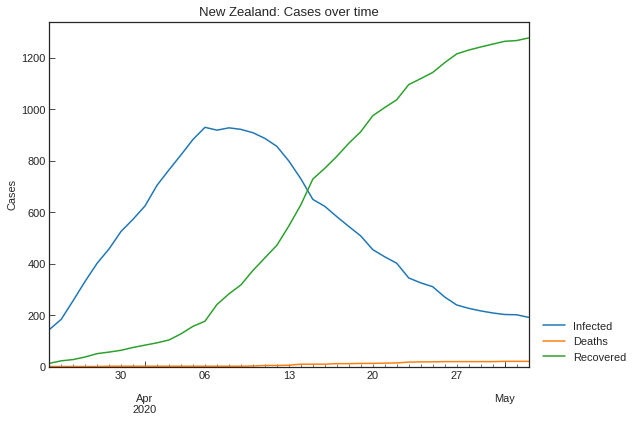

Date  Confirmed  Infected  Deaths  Recovered
36 2020-04-29       1476       216      19       1241
37 2020-04-30       1479       208      19       1252
38 2020-05-01       1485       202      20       1263
39 2020-05-02       1487       201      20       1266
40 2020-05-03       1487       191      20       1276

In [ ]:
nzl_scenario = Scenario(ncov_df, name="New Zealand", population_dict=population_dict)
nzl_scenario.show_record().tail()

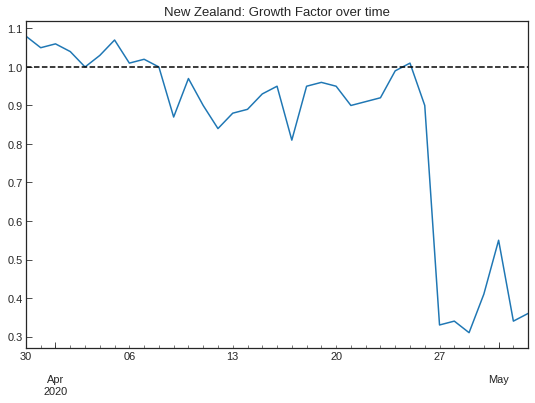

Date     Group  GF > 1 [straight days]  \
New Zealand 2020-05-03  Stopping                       0   

             GF < 1 [straight days]  
New Zealand                       8

In [ ]:
nzl_scenario.growth_factor()

## S-R Trend analysis

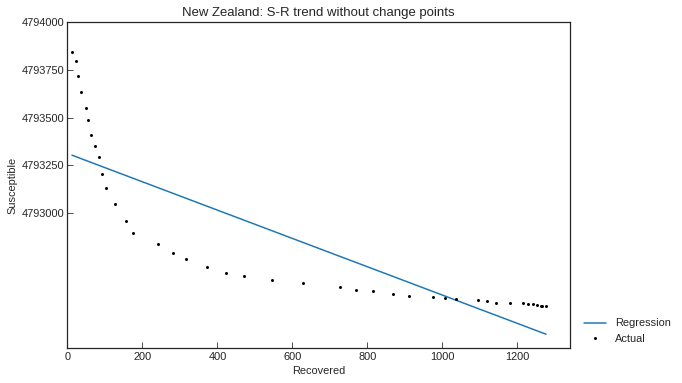

In [ ]:
_ = nzl_scenario.trend()

**We will find the time-points, assuming that there are three change points.**

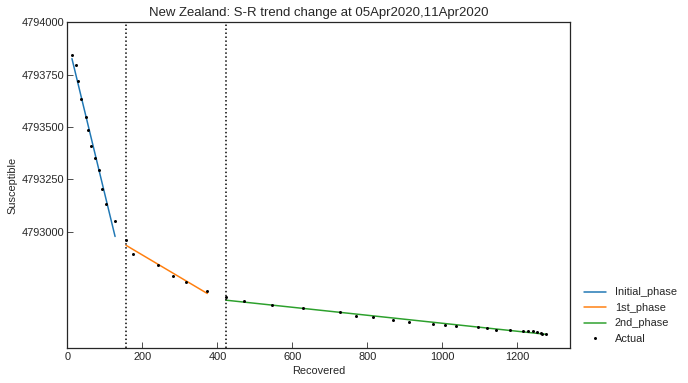

In [ ]:
nzl_change_points = nzl_scenario.trend(n_points=2)

## Phases in New Zealand
We will use the change points as the start date of phases. For each phase, will apply SIR-F model. $\tau$ values will be the same value.

In [ ]:
nzl_scenario.set_phase(start_dates=nzl_change_points)

start_date   end_date  population
1st  05Apr2020  10Apr2020     4794000
2nd  11Apr2020          -     4794000

In [ ]:
nzl_scenario.estimate(SIRF)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 23 sec.
		100 trials finished in 0 min 28 sec.
		100 trials finished in 0 min 25 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 21 sec.
		100 trials finished in 0 min 21 sec.
		100 trials finished in 0 min 21 sec.
	Successfully estimated.
Total: 2 min 22 sec.


### 1st phase

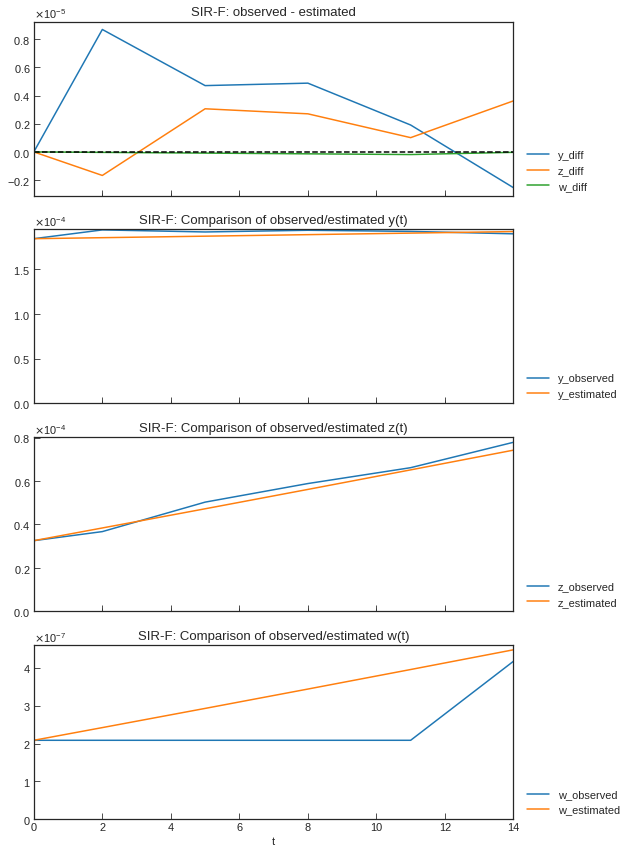

In [ ]:
nzl_scenario.accuracy_graph(phase_n=1)

### 2nd phase

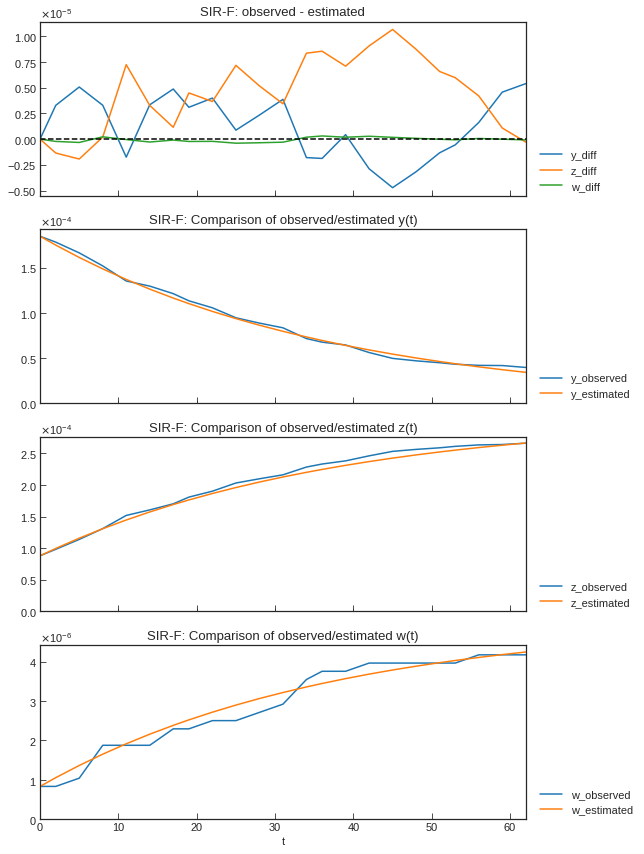

In [ ]:
nzl_scenario.accuracy_graph(phase_n=2)

### Compare predicted number of confirmed cases

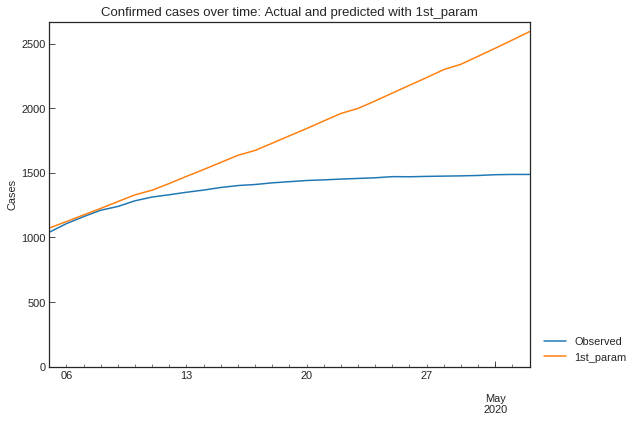

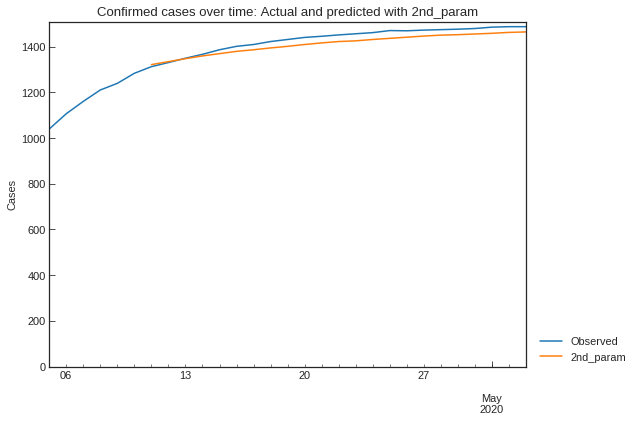

In [ ]:
nzl_scenario.compare_estimated_numbers(phases=["1st", "2nd"])

### Compare parameters

In [ ]:
nzl_scenario.show_parameters()

start_date   end_date  population  tau     theta     kappa       rho  \
1st  05Apr2020  10Apr2020     4794000  508  0.001237  0.000067  0.018949   
2nd  11Apr2020          -     4794000  508  0.018319  0.000511  0.005673   

        sigma    Rt     score  alpha1 [-]  1/alpha2 [day]  1/beta [day]  \
1st  0.015828  1.19  0.130792       0.001            5235            18   
2nd  0.032166  0.17  0.066694       0.018             690            62   

     1/gamma [day]  
1st             22  
2nd             10

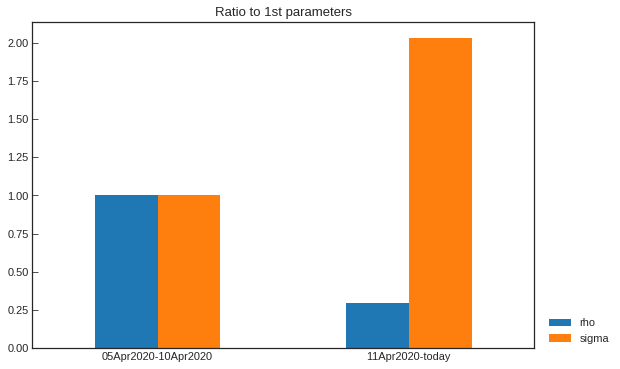

In [ ]:
nzl_scenario.param_history(["rho", "sigma"])

## Predict the future with the last parameters

In a week,

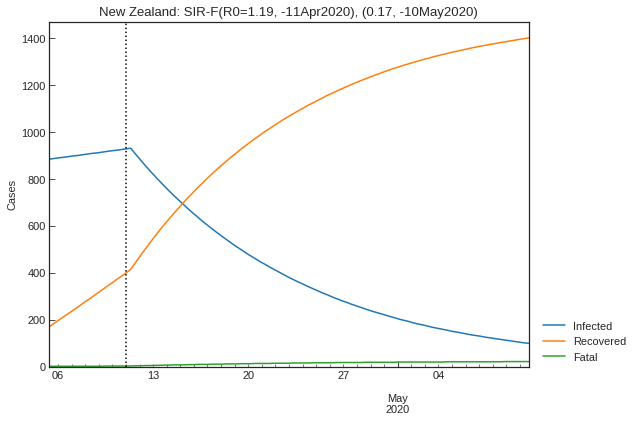

In [ ]:
nzl_scenario.predict(days=7).tail(7).style.background_gradient(axis=0)

In 30 days,

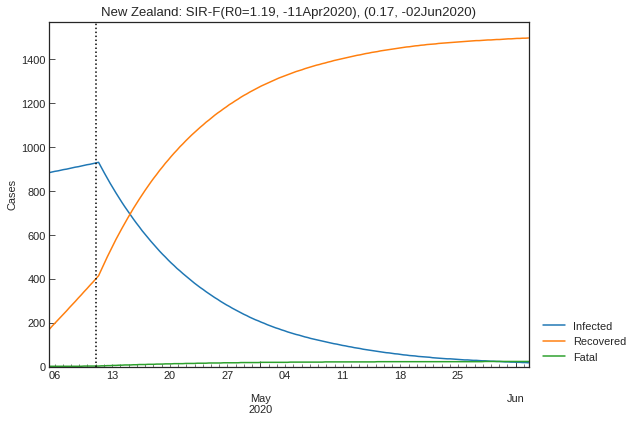

In [ ]:
nzl_scenario.predict(days=30).tail(7).style.background_gradient(axis=0)

In the long-term,

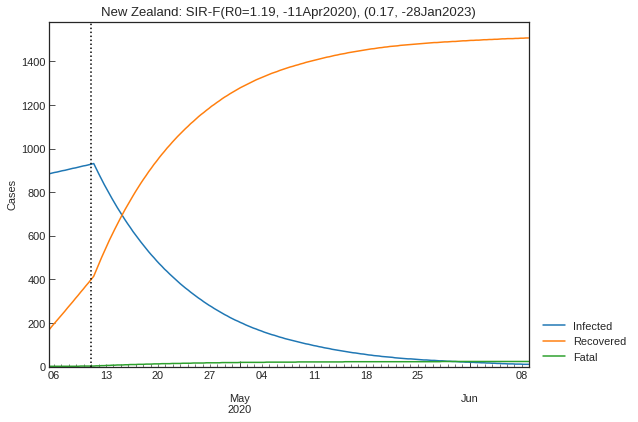

In [ ]:
nzl_ = nzl_scenario.predict(days=1000, min_infected=10)

# Remarks<a id="9"></a>
Thank you for reading!  
Lisphilar from Japan

## Conclusion
(Will be updated)

## Acknowledgement<a id="3"></a>
### Datasets in kaggle
* The number of cases: [Novel Corona Virus 2019 Dataset](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset)
* Total population: [covid19-global-forecasting-locations-population](https://www.kaggle.com/dgrechka/covid19-global-forecasting-locations-population/metadata)
* Population pyramid: [Population Pyramid 2019](https://www.kaggle.com/hotessy/population-pyramid-2019)
* Mesaures in each country: [COVID-19 containment and mitigation measures](https://www.kaggle.com/paultimothymooney/covid19-containment-and-mitigation-measures)
* Measures in Italy: [COVID-19 Prevention in Italy](https://www.kaggle.com/marcoferrante/covid19-prevention-in-italy)

#### Datasets created by the notebook auther
[COVID-19 dataset in Japan](https://www.kaggle.com/lisphilar/covid19-dataset-in-japan)
* The number of cases in Japan: PCR-tested, with/without symptoms, mild/severe, hospitalized or not etc.
* The number of cases at prefecture level: PCR-test, confirmed, discharged, fatal
* Basic information of each prefecture: Population, area, the number of beds

Data is from HP of Ministry of Health, Labour and Welefare, Japan:  
[Ministry of Health, Labour and Welefare HP (in Japanese)](https://www.mhlw.go.jp/)  
[Ministry of Health, Labour and Welefare HP (in English)](https://www.mhlw.go.jp/english/)  
[COVID-19 Japan 都道府県別 感染症病床数 (CC BY)](https://code4sabae.github.io/bedforinfection/)  
[Wikipedia](https://ja.wikipedia.org/wiki/)  

### Data provided by kagglers as a comment on this notebook
* The number of days persons of each age group usually go out provided by [Marco Ferrante](https://www.kaggle.com/marcoferrante)

### External resources
* Population pyramid: [PopulationPyramid.net](https://www.populationpyramid.net/) licensed under [Creative Commons license CC BY 3.0](https://creativecommons.org/licenses/by/3.0/)
* Movility report in Italy: [COVID-19 Mobility Monitoring project](https://covid19mm.github.io/) licenced under [Creative Commons license CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)
* Movility reports: [Google: COVID-19 Community Mobility Reports](https://www.google.com/covid19/mobility/)
* Gomperz curve: [Jia, Lin, et al. "Prediction and analysis of Coronavirus Disease 2019." arXiv preprint arXiv:2003.05447 (2020).](https://arxiv.org/ftp/arxiv/papers/2003/2003.05447.pdf)

(In Japanese)
* Mobility: [Report of 1st survey by Ministry of Health, Labor and Welfare & LINE Corporation](https://www.mhlw.go.jp/stf/newpage_10695.html)  
* Mobility: [Detailed report of 1st survey by Ministry of Health, Labor and Welfare & LINE Corporation](https://www.mhlw.go.jp/stf/newpage_10798.html)
* @ClusterJapan (expert team to prevent COVID-19 outbreak in Japan) comments: [Twitter @ClusterJapan on 11Apr2020](https://twitter.com/ClusterJapan/status/1248884086581514242?s=20)
* Gomperz curve: [(In Japanese) ゴンペルツ曲線とは何か？（3）](https://qiita.com/BMJr/items/4e2782e8f1d3c1db6801)

### References and reading materials

#### Papers
* Basic reproduction number: [Van den Driessche, P., & Watmough, J. (2002).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118/)
* Curve fitting with Logistic function and Gompertz function: [Jia, Lin, et al., 2020.](https://arxiv.org/ftp/arxiv/papers/2003/2003.05447.pdf)
* S-R place: [Balkew, Teshome Mogessie, "The SIR Model When S(t) is a Multi-Exponential Function." (2010).Electronic Theses and Dissertations.Paper 1747](https://dc.etsu.edu/cgi/viewcontent.cgi?article=3102&context=etd)
* Un-controlled clinical study of Remdesivir: [Grein, Jonathan, et al., 2020](https://www.nejm.org/doi/full/10.1056/NEJMoa2007016?query=RP)

#### KEGG
* KEGG DRUG DATABASE: [Remdesivir (USAN)](https://www.kegg.jp/dbget-bin/www_bget?dr:D11472)
* KEGG DRUG DATABASE: [Favipiravir (AVIGAN)](https://www.kegg.jp/dbget-bin/www_bget?dr:D09537)
* Medical package insert of AVIGAN (In Japanese): [KEGG database "AVIGAN"](https://www.kegg.jp/medicus-bin/japic_med?japic_code=00066852)

#### Kaggle
Curve fitting with Gamma PDF etc. by [Bill Holst](https://www.kaggle.com/wjholst). 
* [COVID-19 Growth Patterns in Critical Countries](https://www.kaggle.com/wjholst/covid-19-growth-patterns-in-critical-countries#Gaussian-Approximation-of-Active-Cases)
* [COVID-19 - Growth of Virus in Specific Countries](https://www.kaggle.com/wjholst/covid-19-growth-of-virus-in-specific-countries#Gaussian-Approximation-of-Active-Cases)
* [Prediction With a Gamma PDF](https://www.kaggle.com/wjholst/prediction-with-a-gamma-pdf)

#### YouTube
* Growth Factor: [YouTube "Exponential growth and epidemics"](https://www.youtube.com/watch?v=Kas0tIxDvrg)
* Physical distancing (social distancing): [YouTube "Simulating an epidemic"](https://www.youtube.com/watch?v=gxAaO2rsdIs)
* $\Delta$Confirmed vs. Confirmed plot: [YouTube: How To Tell If We're Beating COVID-19](https://www.youtube.com/watch?v=54XLXg4fYsc)

#### Other online resources
* Simple SIR model: [The SIR epidemic model](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/)
* SEIR model: [Introduction to SEIR model Models](http://indico.ictp.it/event/7960/session/3/contribution/19/material/slides/)
* Basic reproduction number: [Estimating the Impact of a Pathogen via Monte Carlo Simulation](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)
* RMSLE score: [What’s the Difference Between RMSE and RMSLE?](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a)


## Change log<a id="11"></a>

### In Feb2020
 * 13Feb2020: SIR model
 * 15Feb2020: SIR-D model
 * 22Feb2020: SIR-F model
 * 23Feb2020: Changed the dataset from 2019_ncov_data.csv to covid_19_data.csv
 * 23Feb2020: $\tau$ was fixed as "1 day" because the time format of ObservationDate is MM/DD/YYYY
 * 23Feb2020: SIR-F model with other countries
 * 23Feb2020: How to minimize the damage (Change of parameter, Vacctination)
 * 24Feb2020: Use $\tau$ again

### In Mar2020
 * 01Mar2020: $\tau$ definition was changed. $1\leq \tau \mathrm{[hour]} \leq 24$ $\to$ $1\leq \tau \mathrm{[min]} \leq 1440$ 
 * 01Mar2020: Added "Test of hyperparameter optimization using example data" in SIR model section
 * 02Mar2020: Analysis of Linelist (estimation of Effective contact/Recovery/Death rate using case reports)
 * 03Mar2020: Trend analysis
 * 03Mar2020: Update estimator error function; Exponential Weighted Moving Average (span=14days) of |observed - estimated|
 * 04Mar2020: "Analysis of Linelist" was moved to [EDA of linelist](https://www.kaggle.com/lisphilar/eda-of-linelist?scriptVersionId=29640733#Remarks)
 * 04Mar2020: Data in Hubei and China will be analysed in another notebook. Please refer to [Data in China with SIR model](https://www.kaggle.com/lisphilar/data-in-china-with-sir-model?scriptVersionId=29646940).
 * 06Mar2020: Random seed was fixed as 2019
 * 06Mar2020: Update estimator error function; Weighted Average of |Exponential Weighted Moving Average (span=14days) of observed - estimated|
 * 07Mar2020: Update estimator error function; Total population $\times$ Wighted Average of |observed - estimated| with step number t
 * 07Mar2020: Priorities of variables in estimator error function was set as $(x, y, z, w) = (1, 10, 10, 1)$ in SIR-F model.
 * 09Mar2020: Update estimator error function; $(\mathrm{Population})^2$ $\times$ (Wighted Average of |observed - estimated|/[observed $\times$ Population + 1] with step number t)
 * 09Mar2020: Priorities of variables in estimator error function were set as $(x, y, z, w) = (1, 10, 10, 2)$ in SIR-F model.
 * 11Mar2020: Update model.param_dict(); each parametor range was limited to 30%-70% quantiles of the estimated values ($\frac{\mathrm{d}z}{\mathrm{d}t}\left(\frac{1}{y}\right)$ for $\sigma$) of training dataset.
 * 12Mar2020: Update model.param_dict(); each parameter range was limited to 5%-95% quantiles
 * 12Mar2020: Detailed scenario analysis. Thank you, Marco Ferrante!
 * 13Mar2020: Update model.param_dict(); each parameter range was limited to 0%-100% quantiles
 * 13Mar2020: Update "Detailed scenario analysis" > "Real factors of effective contact rate $\beta$"
 * 14Mar2020: Update model.param_dict(); rho/sigma range was limited to 30%-70% quantiles of their estimated values
 * 14Mar2020: Applied trend analysis on country level data to use only a part of records for estimation
 * 14Mar2020: Recovered without confirmation was added to "Real factors of effective contact rate $\beta$"
 * 15Mar2020: Merge "How to minimize the damage (Change of parameter, Vacctination)" with "Scenario analysis" section
 * 15Mar2020: Update Estimator, int to np.int. Thank you Enrico Papalini!
 * 15Mar2020: Update Estimator, some parameters can be fixed. Some of SIR parameters can be applied to SIR-F model.
 * 17Mar2020: The number of exposed cases and waiting cases
 * 17Mar2020: Update Scenario analysis
 * 18Mar2020: Scenario analysis in Italy
 * 19Mar2020: Estimation of new drugs effect in "Scenario analysis in Italy" section
 * 29Mar2020: Grouping of countries by growth factor
 * 29Mar2020: Update "Scenario in Italy" section to include confirmed national lockdown effect

### In Apr2020
 * 05Apr2020: Update simulation() fucntion, dense_ouput=False
 * 05Apr2020: Create Scenario() class
 * 06Apr2020: Update Scenario() class to reduce running time
 * 11Apr2020: Italy entered 4th phase
 * 11Apr2020: Add "How to make way by 31May2020 for the number of cases peaking out" in Japan
 * 13Apr2020: "excluded_places" was used for SEWIR-F and showed incorrected graph in the previous versions. Replaced with "places"
 * 17Apr2020: Prepare the dataset in Japan
 * 18Apr2020: Update RMSLE score fucntion of Estimator, $\ln(x)$ to $log_{10}(x)$
 * 18Apr2020: Add explanation of accuracy index of hyperparameter estimation
 * 18Apr2020: Japan entered 3rd phase
 * 18Apr2020: Data in "Expalanation of concept part" was changed from actual data to example data